In [1]:
import sys
print(sys.version)

3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:21:09) 
[Clang 9.0.1 ]


In [2]:
"""
Created on September 8 2020
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
from Residual_1D_module import * 
from Zernike_Analysis_Module import *

# 0.35d or greater

print('Zernike_Module.__version__: '+str(Zernike_Module.__version__))
print('Zernike_Analysis_Module.__version__: '+str(Zernike_Analysis_Module.__version__))

Zernike_Module.__version__: 0.35d
Zernike_Analysis_Module.__version__: 0.26b


In [6]:
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle
import glob
import time

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

from astropy.io import fits

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c



print(np.__version__)
print(skimage.__version__)
print(scipy.__version__)
print(pd.__version__)

1.18.5
0.17.2
1.5.0
1.0.5


# PIPE2D-631 Oct26

In [556]:
def move_parametrizations_from_2d_shape_to_1d_shape(allparameters_best_parametrization_shape_2d):
    """ 
    change the linear parametrization array in 2d shape to parametrization array in 1d
    
    @param allparameters_best_parametrization_shape_2d        linear parametrization, 2d array
    
    """    
    
    
    if allparameters_best_parametrization_shape_2d.shape[0]>42:
        #  if you are using above Zernike above 22
        print('we are creating new result with Zernike above 22')
        allparameters_best_parametrization_shape_1d=np.concatenate((allparameters_best_parametrization_shape_2d[:19].ravel(),
                                                    allparameters_best_parametrization_shape_2d[19:19+23][:,1],\
                                                        allparameters_best_parametrization_shape_2d[19+23:].ravel()))
        
    else:
        print('we are creating new result with Zernike at 22')
        allparameters_best_parametrization_shape_1d=np.concatenate((allparameters_best_parametrization_shape_2d[:19].ravel(),
                                                    allparameters_best_parametrization_shape_2d[19:-1][:,1]))    
        
    return allparameters_best_parametrization_shape_1d

min_parametrization_1=array_of_polyfit_1_parameterizations_proposal_shape_2d=np.array([[   -7.48584024,     0.73497698],
       [    0.19568978,     0.15682353],
       [    0.03769565,     0.02577918],
       [   -0.03734586,     0.39183789],
       [    0.02550665,     0.556507  ],
       [    0.0072312 ,     0.1261021 ],
       [    0.01097693,    -0.26493479],
       [   -0.01831573,    -0.05247759],
       [    0.01020252,    -0.15314955],
       [    0.00343817,    -0.10475206],
       [    0.02711867,    -0.0137685 ],
       [    0.00445374,     0.0372618 ],
       [    0.01458828,    -0.02237409],
       [   -0.01880653,     0.03841714],
       [   -0.00188257,     0.02112357],
       [   -0.00910924,     0.01975998],
       [   -0.00067647,    -0.02366152],
       [    0.00463751,     0.012873  ],
       [   -0.00621102,     0.02695559],
       [    0.        ,     0.68904049],
       [    0.        ,     0.10290975],
       [    0.        ,    -0.20154677],
       [    0.        ,    -0.01441376],
       [    0.        ,     0.05355728],
       [    0.        ,     0.05813265],
       [    0.        ,     0.0000314 ],
       [    0.        ,     0.0000314 ],
       [    0.        ,     0.9767313 ],
       [    0.        ,     0.94836248],
       [    0.        ,     0.02461952],
       [    0.        ,    -0.05835101],
       [    0.        ,     0.93393462],
       [    0.        ,     0.04867201],
       [    0.        ,     0.49904901],
       [    0.        ,     1.01173008],
       [    0.        ,     0.63182418],
       [    0.        , 51347.90306188],
       [    0.        ,     2.32213302],
       [    0.        ,     0.00238991],
       [    0.        ,     0.37175131],
       [    0.        ,     1.79411345],
       [    0.        ,     0.99627532],
       [    0.00003301,    -0.00155895],
       [   -0.0007012 ,     0.00400087],
       [    0.00093449,     0.00437024],
       [    0.00096567,     0.00066246],
       [    0.00095771,     0.00368164],
       [    0.00029302,    -0.00083184],
       [    0.00196281,    -0.00503305],
       [    0.00055673,     0.00092236],
       [   -0.00170941,    -0.00397606],
       [    0.00222377,     0.01257303],
       [    0.00219571,     0.00159809],
       [   -0.00109161,     0.00276234],
       [   -0.00071055,    -0.00917837],
       [    0.00070316,    -0.00561311],
       [   -0.00074906,     0.00218633],
       [    0.00052506,     0.00031175],
       [   -0.00027124,     0.00124874],
       [    0.00056686,    -0.0004586 ],
       [   -0.00085383,     0.00176925],
       [   -0.00200233,    -0.00099071],
       [   -0.00017492,     0.00005366],
       [    0.00075724,    -0.00381397],
       [    0.0016349 ,    -0.00899893],
       [    0.00057199,    -0.01150359],
       [   -0.00085055,     0.00203238],
       [   -0.00052982,     0.0053546 ],
       [    0.00095456,    -0.00181697],
       [   -0.00055045,    -0.00379142],
       [   -0.00048768,     0.00804741],
       [   -0.00145526,     0.00574891],
       [   -0.0001161 ,    -0.00048279],
       [   -0.00099326,     0.00201623],
       [    0.00012449,     0.0103669 ],
       [    0.00272563,    -0.00187062]])



min_parametrization_1=move_parametrizations_from_2d_shape_to_1d_shape(array_of_polyfit_1_parameterizations_proposal_shape_2d)
print(min_parametrization_1)    

we are creating new result with Zernike above 22
[   -7.48584024     0.73497698     0.19568978     0.15682353
     0.03769565     0.02577918    -0.03734586     0.39183789
     0.02550665     0.556507       0.0072312      0.1261021
     0.01097693    -0.26493479    -0.01831573    -0.05247759
     0.01020252    -0.15314955     0.00343817    -0.10475206
     0.02711867    -0.0137685      0.00445374     0.0372618
     0.01458828    -0.02237409    -0.01880653     0.03841714
    -0.00188257     0.02112357    -0.00910924     0.01975998
    -0.00067647    -0.02366152     0.00463751     0.012873
    -0.00621102     0.02695559     0.68904049     0.10290975
    -0.20154677    -0.01441376     0.05355728     0.05813265
     0.0000314      0.0000314      0.9767313      0.94836248
     0.02461952    -0.05835101     0.93393462     0.04867201
     0.49904901     1.01173008     0.63182418 51347.90306188
     2.32213302     0.00238991     0.37175131     1.79411345
     0.99627532     0.00003301    -0.001

In [730]:
#date='Jul2020'
date='Sep2820'
obs=21448
#obs_multi=[21352, 21358, 21364, 21436, 21442, 21448 ]
obs_int=int(obs)
single_number='3'
image_index=int(single_number)
eps=6
arc='HgAr'
dataset=4

list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

single_analysis=Zernike_Analysis(date=date,obs='m3',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                 list_of_defocuses=list_of_defocuses_input_long)
double_sources,double_sources_positions_ratios=single_analysis.return_double_sources()
list_of_sci_images,list_of_var_images,list_of_mask_images=single_analysis.return_lists_of_images()
index_of_single_image=single_analysis.return_index_of_single_image_in_list_of_images()
columns,columns22,columns22_analysis=single_analysis.return_columns()

chain0_swarm_1,likechain0_swarm_1=single_analysis.create_chains_swarm_1()
#chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain_parametrization,like_min=single_analysis.create_likelihood()

labelInput: m3
self.single_number: 3
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [21352, 21358, 21364, 21394, 21400, 21406, 21436, 21442, 21448]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes/finalHgAr_Feb2020'>
analyzing label: 21364
double_sources_positions_ratios for this spot is: [0 0]
(7, 120, 129)
(7, 120, 129)
minimal likelihood is: 3382.5717778593516
minimal chi2 reduced is (makes no sense for multi_var): -5.422008666347685


In [731]:
import cosmoHammer
from Zernike_Module import LN_PFS_single,LN_PFS_multi_same_spot,create_parInit,PFSLikelihoodModule,svd_invert

In [732]:
stronger_wavefront_at_0=np.zeros((38+23,))
stronger_wavefront_at_0[19*2:19*2+23]=1

parInit1=create_parInit(allparameters_proposal=array_of_polyfit_1_parameterizations_proposal_shape_2d,multi=True,pupil_parameters=None,\
                        allparameters_proposal_err=None,\
                        stronger=stronger_wavefront_at_0,use_optPSF=None,deduced_scattering_slope=None,zmax=56)

globalparameters_flat.shape(774, 68)


In [545]:
model_multi=LN_PFS_multi_same_spot(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=0,zmax=56,verbosity=0,\
                      list_of_defocuses=list_of_defocuses_input_long,double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=True)   
list_of_minchain_1=model_multi.create_list_of_allparameters(min_parametrization_1,list_of_defocuses=list_of_defocuses_input_long,zmax=56)

Tokovinin_multi_instance=Tokovinin_multi(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=0,zmax=22,verbosity=0,\
                      list_of_defocuses=list_of_defocuses_input_long,double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=True)

# Fake_Tokovinin_multi_instance should take allparameterization, and tuple with first value being fake likelihood, and second value being fake allparameterization

def Fake_Tokovinin_multi_instance(input_allparameterization):
    #print('input_allparameterization in Fake_Tokovinin_multi_instance:'+str(input_allparameterization[0:5]))
    
    fake_allparameterization=input_allparameterization*(1+np.random.normal()/100)
    
    
    fake_likelihood=-np.sum((np.ones(5)*20-fake_allparameterization[0:5])**2)

    #print('fake_likelihood,fake_allparameterization in Fake_Tokovinin_multi_instance:'+str(fake_likelihood)+' '+str(fake_allparameterization[0:5]))    
    return (fake_likelihood,fake_allparameterization,fake_allparameterization,fake_allparameterization,fake_allparameterization)
"""
def Fake_Tokovinin_multi_instance(input_allparameterization):
    print('input_allparameterization in Fake_Tokovinin_multi_instance:'+str(input_allparameterization[0:5]))
    fake_likelihood=-np.sum(test[1])+np.random.normal()*100
    fake_allparameterization=input_allparameterization*(1+np.random.normal()/100)
    print('fake_likelihood,fake_allparameterization in Fake_Tokovinin_multi_instance:'+str(fake_likelihood)+' '+str(fake_allparameterization[0:5]))    
    return fake_likelihood
"""

"\ndef Fake_Tokovinin_multi_instance(input_allparameterization):\n    print('input_allparameterization in Fake_Tokovinin_multi_instance:'+str(input_allparameterization[0:5]))\n    fake_likelihood=-np.sum(test[1])+np.random.normal()*100\n    fake_allparameterization=input_allparameterization*(1+np.random.normal()/100)\n    print('fake_likelihood,fake_allparameterization in Fake_Tokovinin_multi_instance:'+str(fake_likelihood)+' '+str(fake_allparameterization[0:5]))    \n    return fake_likelihood\n"

In [546]:
#chain = cosmoHammer.LikelihoodComputationChain()
#chain.addLikelihoodModule(PFSLikelihoodModule(Tokovinin_multi_instance))
#test=chain(parInit1[12])



In [547]:
#test

In [548]:
chain_fake = cosmoHammer.LikelihoodComputationChain()
chain_fake.addLikelihoodModule(PFSLikelihoodModule(Fake_Tokovinin_multi_instance))
test_fake=chain_fake(parInit1[12])


In [549]:
np.ones(129)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [552]:
#pso = cosmoHammer.ParticleSwarmOptimizer(chain_fake, low=np.min(parInit1,axis=0), high=np.max(parInit1,axis=0),particleCount=30)
pso = cosmoHammer.ParticleSwarmOptimizer(chain_fake, low=np.ones(129), high=np.ones(129)*40,particleCount=4)
    
#for i in range(len(pso.swarm)):
#    pso.swarm[i].position=parInit1[i]

#returns all swarms and the best particle for all iterations
#swarms, gbests = pso.optimize(maxIter=nsteps,c1=options[1],c2=options[2])
list_of_swarms_time_1=[]
time_start_swarms_time_1=time.time()
print('pso.gbest before any nsteps: '+str(pso.gbest))
swarms=[]
gbests=[]
num_iter = 0
random_seed=42

nsteps=20
num_iter=0
for swarm in tqdm(pso.sample(nsteps)):
    swarms.append(swarm)
    gbests.append(pso.gbest.copy())
    num_iter += 1
    print('starting num_iter: '+str(num_iter))
    if pso.isMaster():
        time_end_swarms_time_1=time.time()
        list_of_swarms_time_1.append([num_iter,time_end_swarms_time_1-time_start_swarms_time_1])

        #print('pso.swarm[0] in step'+str(num_iter)+' '+str(pso.swarm[0]))
        #print('pso.swarm[1] in step'+str(num_iter)+' '+str(pso.swarm[1]))
        #swarm_positions_sum=[]
        #for i in range(len(pso.swarm)):
        #    swarm_positions_sum.append(np.sum(pso.swarm[i].position))

        print('pso.gbest in step '+str(num_iter)+': '+str(pso.gbest.position[0:5]))    
        #print('pso.swarm[0] in step '+str(num_iter)+': '+str(pso.swarm[0]))  
        #print('pso.swarm[1] in step '+str(num_iter)+': '+str(pso.swarm[1]))  
        #print('pso.swarm[0] in step '+str(num_iter)+': '+str(pso.swarm[0].position[0:5]))
        #print('pso.swarm[0].velocity in step '+str(num_iter)+': '+str(pso.swarm[0].velocity[0:5]))
        #print('swarm[0] in step '+str(num_iter)+': '+str(swarm[0].position[0:5]))        
        #print('swarm[0].velocity in step '+str(num_iter)+': '+str(swarm[0].velocity[0:5]))      
        #test that you are setting a position correctly   
        #pso.swarm[0].velocity=np.zeros(129)      
        #swarm[0].position=np.ones(129)       
        #swarm[0].velocity=np.zeros(129)  
        #print('pso.swarm[0].position in step '+str(num_iter)+': '+str(pso.swarm[0].position[0:5]))
        #print('pso.swarm[0].velocity in step '+str(num_iter)+': '+str(pso.swarm[0].velocity[0:5]))
        #print('swarm[0].position in step '+str(num_iter)+': '+str(swarm[0].position[0:5]))
        #print('swarm[0].velocity in step '+str(num_iter)+': '+str(swarm[0].velocity[0:5]))      
        #pso.swarm[0].position=np.ones(len(pso.swarm[0].position))
        
        #index_of_best_position=swarm_positions_sum.index(np.sum(pso.gbest.position))
        #print('pso.index_of_best_position in step'+str(num_iter)+' '+str(index_of_best_position))
        #print('pso.swarm[index_of_best_position] in step'+str(num_iter)+' '+str(pso.swarm[index_of_best_position]))            


        print('************************')

        print("First swarm: "+str(100*num_iter/(nsteps)))
        sys.stdout.flush()

0it [00:00, ?it/s]

pso.gbest before any nsteps: -inf, pos: [] velo: []
starting num_iter: 1
pso.gbest in step 1: [16.59210433 10.71243358 19.88881852 10.02864818 27.19468492]
************************
First swarm: 5.0
starting num_iter: 2
pso.gbest in step 2: [21.45951991 24.62813922 20.21946313 19.94265327 29.5658608 ]
************************
First swarm: 10.0
starting num_iter: 3
pso.gbest in step 3: [19.18793646 23.82861323 20.13622475 17.81654971 29.54093923]
************************
First swarm: 15.0
starting num_iter: 4
pso.gbest in step 4: [22.22670554 17.3081227  21.78024834 15.7589732  26.64759835]
************************
First swarm: 20.0
starting num_iter: 5
pso.gbest in step 5: [23.36284981 21.83576758 25.11848855 23.33193469 23.43304095]
************************
First swarm: 25.0
starting num_iter: 6
pso.gbest in step 6: [23.36284981 21.83576758 25.11848855 23.33193469 23.43304095]
************************
First swarm: 30.0
starting num_iter: 7
pso.gbest in step 7: [23.36284981 21.83576758 

10it [00:00, 89.43it/s]

starting num_iter: 11
pso.gbest in step 11: [22.25373826 20.2421234  23.48881    17.90729022 24.66064507]
************************
First swarm: 55.0
starting num_iter: 12
pso.gbest in step 12: [19.67088254 21.95292535 19.41246277 19.75039491 24.25718216]
************************
First swarm: 60.0
starting num_iter: 13
pso.gbest in step 13: [18.02431221 22.67387108 20.33317458 22.12133302 18.11316317]
************************
First swarm: 65.0
starting num_iter: 14
pso.gbest in step 14: [20.28085068 21.40367772 20.4351479  18.28267639 17.16070242]
************************
First swarm: 70.0
starting num_iter: 15
pso.gbest in step 15: [20.28085068 21.40367772 20.4351479  18.28267639 17.16070242]
************************
First swarm: 75.0
starting num_iter: 16
pso.gbest in step 16: [20.28085068 21.40367772 20.4351479  18.28267639 17.16070242]
************************
First swarm: 80.0
starting num_iter: 17
pso.gbest in step 17: [19.86162987 21.78650192 21.17079415 18.97705774 20.03410992]


20it [00:00, 91.26it/s]

max iteration reached! stoping

20it [00:00, 87.49it/s]

In [551]:
    minchain=gbests[-1].position
    minln=gbests[-1].fitness
    
    res=[]
    for i in range(len(swarms)):
        for j in range(len(swarms[0])):
            res.append(swarms[i][j].position)     
    res=np.array(res)
    chains=res.reshape(len(swarms),len(swarms[0]),parInit1.shape[1])
    
    res=[]
    for i in range(len(swarms)):
        for j in range(len(swarms[0])):
            res.append(swarms[i][j].fitness)         
    res=np.array(res)
    ln_chains=res.reshape(len(swarms),len(swarms[0]))
    
    res=[]
    for i in range(len(swarms)):
        for j in range(len(swarms[0])):
            res.append(swarms[i][j].velocity)         
    res=np.array(res)
    v_chains=res.reshape(len(swarms),len(swarms[0]),parInit1.shape[1])

In [517]:
minchain

array([ 19.7149894 ,  19.87057678,  19.58533499,  19.88684823,
        20.06711166,   8.06315054,  19.29087261,  29.01805529,
         2.15479329,  16.82094291,  41.69789895,  41.10233823,
         6.60938914,  23.4976171 ,  -6.78005853,  16.06931846,
        24.06982333, -12.29923275,  28.03058489,  27.2137421 ,
         9.35477768,  14.22157173,  20.22991281,  25.56879802,
        20.63230935,  10.59538729,  49.34632497,  18.11384217,
        19.97723667,  27.93786136,  47.41813215,  31.46949692,
        17.31558024,  24.54450671,  33.29815796, -13.21315785,
         7.79647374,  19.54663612,  34.17324768,  29.21450514,
        55.18749334,  16.82129099,  18.61740319,  16.19125826,
         2.6777025 ,  11.34454328,  11.29432745,  11.9018887 ,
        52.31829778,  42.59046874,   7.85829939,   6.26815629,
       -22.95942716,  32.53958457,  16.52089436,   6.53424061,
        16.97417926,  36.1349753 , -22.09770267,  23.79320285,
        35.39420992,  27.82787744,  26.57381386,  29.97

In [489]:
minln

-4463.088154378856

In [265]:
Fake_Tokovinin_multi_instance(np.ones(129))

input_allparameterization in Fake_Tokovinin_multi_instance:[1. 1. 1. 1. 1.]
fake_likelihood,fake_allparameterization in Fake_Tokovinin_multi_instance:-102330.02472946983 [0.99044682 0.99044682 0.99044682 0.99044682 0.99044682]


(-102330.02472946983,
 array([0.99044682, 0.99044682, 0.99044682, 0.99044682, 0.99044682,
        0.99044682, 0.99044682, 0.99044682, 0.99044682, 0.99044682,
        0.99044682, 0.99044682, 0.99044682, 0.99044682, 0.99044682,
        0.99044682, 0.99044682, 0.99044682, 0.99044682, 0.99044682,
        0.99044682, 0.99044682, 0.99044682, 0.99044682, 0.99044682,
        0.99044682, 0.99044682, 0.99044682, 0.99044682, 0.99044682,
        0.99044682, 0.99044682, 0.99044682, 0.99044682, 0.99044682,
        0.99044682, 0.99044682, 0.99044682, 0.99044682, 0.99044682,
        0.99044682, 0.99044682, 0.99044682, 0.99044682, 0.99044682,
        0.99044682, 0.99044682, 0.99044682, 0.99044682, 0.99044682,
        0.99044682, 0.99044682, 0.99044682, 0.99044682, 0.99044682,
        0.99044682, 0.99044682, 0.99044682, 0.99044682, 0.99044682,
        0.99044682, 0.99044682, 0.99044682, 0.99044682, 0.99044682,
        0.99044682, 0.99044682, 0.99044682, 0.99044682, 0.99044682,
        0.99044682, 0.9904

In [554]:
test_chain



array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [557]:
test_chain=chain(min_parametrization_1)

We are inside of the pool loop number 0 now
all_wavefront_z_parametrization_old in 0 [-7.48584024  0.73497698  0.19568978  0.15682353  0.03769565]
Tokovnin_proposal[:5] is: [0.00035166 0.00117287 0.00020018 0.00116323 0.0002357 ]
Tokovnin_proposal.shape (106,)
We are inside of the pool loop number 1 now
all_wavefront_z_parametrization_old in 1 [-7.48548858  0.73614985  0.19588996  0.15798676  0.03793135]
Tokovnin_proposal[:5] is: [0.00021779 0.00119929 0.00025943 0.00106821 0.00017137]
Tokovnin_proposal.shape (106,)


In [561]:
test_chain[1]-min_parametrization_1

array([0.00056945, 0.00237216, 0.0004596 , 0.00223144, 0.00040707,
       0.00151966, 0.00035347, 0.00098505, 0.00034755, 0.00111863,
       0.00029803, 0.00104471, 0.00031515, 0.00132246, 0.00025431,
       0.00112706, 0.0002724 , 0.00089122, 0.00030127, 0.0009878 ,
       0.00023012, 0.00114839, 0.0002237 , 0.00100199, 0.00018147,
       0.00078246, 0.00020176, 0.0009838 , 0.00022834, 0.00075462,
       0.00019215, 0.00076852, 0.00021092, 0.00065086, 0.00017884,
       0.00078762, 0.0002066 , 0.00078336, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00019413, 0.00075205, 0.00017375, 0.00060348,
       0.00020964, 0.00053482, 0.0001759 , 0.00068259, 0.00016328,
       0.00053889, 0.00017284, 0.0006576 , 0.0001332 , 0.00066

In [322]:
pos=[np.ones(129),np.ones(129),np.ones(129),np.ones(129)]
results =  map(chain_fake, pos)
allpar,lnprob = np.array([l[1] for l in results]),np.array([l[1] for l in results])
#lnprob = np.array([l[0] for l in results])


input_allparameterization in Fake_Tokovinin_multi_instance:[1. 1. 1. 1. 1.]
fake_likelihood,fake_allparameterization in Fake_Tokovinin_multi_instance:-102447.88172156786 [1.00391717 1.00391717 1.00391717 1.00391717 1.00391717]
input_allparameterization in Fake_Tokovinin_multi_instance:[1. 1. 1. 1. 1.]
fake_likelihood,fake_allparameterization in Fake_Tokovinin_multi_instance:-102240.46558434005 [1.00898602 1.00898602 1.00898602 1.00898602 1.00898602]
input_allparameterization in Fake_Tokovinin_multi_instance:[1. 1. 1. 1. 1.]
fake_likelihood,fake_allparameterization in Fake_Tokovinin_multi_instance:-102233.57544746937 [0.99853172 0.99853172 0.99853172 0.99853172 0.99853172]
input_allparameterization in Fake_Tokovinin_multi_instance:[1. 1. 1. 1. 1.]
fake_likelihood,fake_allparameterization in Fake_Tokovinin_multi_instance:-102277.67837702457 [1.00371174 1.00371174 1.00371174 1.00371174 1.00371174]


In [335]:
pos=[np.ones(129),np.ones(129),np.ones(129),np.ones(129)]
results =  map(chain_fake, pos)
t= np.array([l for l in results])

input_allparameterization in Fake_Tokovinin_multi_instance:[1. 1. 1. 1. 1.]
fake_likelihood,fake_allparameterization in Fake_Tokovinin_multi_instance:-102322.29648913241 [1.01027099 1.01027099 1.01027099 1.01027099 1.01027099]
input_allparameterization in Fake_Tokovinin_multi_instance:[1. 1. 1. 1. 1.]
fake_likelihood,fake_allparameterization in Fake_Tokovinin_multi_instance:-102353.10755843461 [0.99779998 0.99779998 0.99779998 0.99779998 0.99779998]
input_allparameterization in Fake_Tokovinin_multi_instance:[1. 1. 1. 1. 1.]
fake_likelihood,fake_allparameterization in Fake_Tokovinin_multi_instance:-102292.12048113025 [1.0026435 1.0026435 1.0026435 1.0026435 1.0026435]
input_allparameterization in Fake_Tokovinin_multi_instance:[1. 1. 1. 1. 1.]
fake_likelihood,fake_allparameterization in Fake_Tokovinin_multi_instance:-102200.99946413838 [0.99676515 0.99676515 0.99676515 0.99676515 0.99676515]


In [336]:
t[:,0]

array([-102322.29648913241, -102353.10755843461, -102292.12048113025,
       -102200.99946413838], dtype=object)

In [337]:
t[:,1]

array([None, None, None, None], dtype=object)

# Zernike_parameter_estimation 

In [583]:
    array_of_polyfit_1_parameterizations_proposal_shape_2d=np.array([[   -7.48584024,     0.73497698],
       [    0.19568978,     0.15682353],
       [    0.03769565,     0.02577918],
       [   -0.03734586,     0.39183789],
       [    0.02550665,     0.556507  ],
       [    0.0072312 ,     0.1261021 ],
       [    0.01097693,    -0.26493479],
       [   -0.01831573,    -0.05247759],
       [    0.01020252,    -0.15314955],
       [    0.00343817,    -0.10475206],
       [    0.02711867,    -0.0137685 ],
       [    0.00445374,     0.0372618 ],
       [    0.01458828,    -0.02237409],
       [   -0.01880653,     0.03841714],
       [   -0.00188257,     0.02112357],
       [   -0.00910924,     0.01975998],
       [   -0.00067647,    -0.02366152],
       [    0.00463751,     0.012873  ],
       [   -0.00621102,     0.02695559],
       [    0.        ,     0.68904049],
       [    0.        ,     0.10290975],
       [    0.        ,    -0.20154677],
       [    0.        ,    -0.01441376],
       [    0.        ,     0.05355728],
       [    0.        ,     0.05813265],
       [    0.        ,     0.0000314 ],
       [    0.        ,     0.0000314 ],
       [    0.        ,     0.9767313 ],
       [    0.        ,     0.94836248],
       [    0.        ,     0.02461952],
       [    0.        ,    -0.05835101],
       [    0.        ,     0.93393462],
       [    0.        ,     0.04867201],
       [    0.        ,     0.49904901],
       [    0.        ,     1.01173008],
       [    0.        ,     0.63182418],
       [    0.        , 51347.90306188],
       [    0.        ,     2.32213302],
       [    0.        ,     0.00238991],
       [    0.        ,     0.37175131],
       [    0.        ,     1.79411345],
       [    0.        ,     0.99627532],
       [    0.00003301,    -0.00155895],
       [   -0.0007012 ,     0.00400087],
       [    0.00093449,     0.00437024],
       [    0.00096567,     0.00066246],
       [    0.00095771,     0.00368164],
       [    0.00029302,    -0.00083184],
       [    0.00196281,    -0.00503305],
       [    0.00055673,     0.00092236],
       [   -0.00170941,    -0.00397606],
       [    0.00222377,     0.01257303],
       [    0.00219571,     0.00159809],
       [   -0.00109161,     0.00276234],
       [   -0.00071055,    -0.00917837],
       [    0.00070316,    -0.00561311],
       [   -0.00074906,     0.00218633],
       [    0.00052506,     0.00031175],
       [   -0.00027124,     0.00124874],
       [    0.00056686,    -0.0004586 ],
       [   -0.00085383,     0.00176925],
       [   -0.00200233,    -0.00099071],
       [   -0.00017492,     0.00005366],
       [    0.00075724,    -0.00381397],
       [    0.0016349 ,    -0.00899893],
       [    0.00057199,    -0.01150359],
       [   -0.00085055,     0.00203238],
       [   -0.00052982,     0.0053546 ],
       [    0.00095456,    -0.00181697],
       [   -0.00055045,    -0.00379142],
       [   -0.00048768,     0.00804741],
       [   -0.00145526,     0.00574891],
       [   -0.0001161 ,    -0.00048279],
       [   -0.00099326,     0.00201623],
       [    0.00012449,     0.0103669 ],
       [    0.00272563,    -0.00187062]])

In [709]:
twentytwo_or_extra=22
multi_var=True
zmax_input=twentytwo_or_extra
stronger_array_01=np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            1.2,1.2,1.2,1.2,1.2,1.2,
            0.0,0.0,0.0,0.0,
            1.2,1.2,1.2,
            1.2,1.2,1.2,1.2,
            1.2,1.2,1.2,
            1.2,1.2,1])     


parInit1=create_parInit(allparameters_proposal=array_of_polyfit_1_parameterizations_proposal_shape_2d,multi=multi_var,pupil_parameters=None,\
                            allparameters_proposal_err=None,\
                            stronger=stronger_array_01,use_optPSF=None,deduced_scattering_slope=None,zmax=zmax_input)

In [715]:
from multiprocessing import Pool
pool=Pool(4)

In [814]:
Tokovinin_multi_instance=Tokovinin_multi(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=0,zmax=22,verbosity=1,\
                      list_of_defocuses=list_of_defocuses_input_long,double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=True)
chain = cosmoHammer.LikelihoodComputationChain()
chain.addLikelihoodModule(PFSLikelihoodModule(Tokovinin_multi_instance))

tes_res=chain(parInit1[0])

list_of_defocuses analyzed: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
****************************
Starting Tokovinin procedure
Initial testing proposal is: [   -7.48584024     0.73497698     0.19568978     0.15682353
     0.03769565     0.02577918    -0.03734586     0.39183789
     0.02550665     0.556507       0.0072312      0.1261021
     0.01097693    -0.26493479    -0.01831573    -0.05247759
     0.01020252    -0.15314955     0.00343817    -0.10475206
     0.02711867    -0.0137685      0.00445374     0.0372618
     0.01458828    -0.02237409    -0.01880653     0.03841714
    -0.00188257     0.02112357    -0.00910924     0.01975998
    -0.00067647    -0.02366152     0.00463751     0.012873
    -0.00621102     0.02695559     0.68904049    10.
    -0.20154677    -0.01441376     0.05355728     0.05813265
     0.0000314      0.0000314      0.9767313     10.
     0.02461952    -0.05835101     0.93393462     0.04867201
     0.49904901     1.01173008     0.63182418 51347.90

up_to_z22_parametrization_start: [-7.48584024  0.73497698  0.19568978  0.15682353  0.03769565  0.02577918
 -0.03734586  0.39183789  0.02550665  0.556507    0.0072312   0.1261021
  0.01097693 -0.26493479 -0.01831573 -0.05247759  0.01020252 -0.15314955
  0.00343817 -0.10475206  0.02711867 -0.0137685   0.00445374  0.0372618
  0.01458828 -0.02237409 -0.01880653  0.03841714 -0.00188257  0.02112357
 -0.00910924  0.01975998 -0.00067647 -0.02366152  0.00463751  0.012873
 -0.00621102  0.02695559]
nonwavefront_par: [    0.68904049    10.            -0.20154677    -0.01441376
     0.05355728     0.05813265     0.0000314      0.0000314
     0.9767313     10.             0.02461952    -0.05835101
     0.93393462     0.04867201     0.49904901     1.01173008
     0.63182418 51347.90306188     2.32213302     0.00238991
     0.37175131     1.79411345     0.99627532]
from_z22_parametrization_start[]
initial input parameters in iteration 0 is: [   -7.48584024     0.73497698     0.19568978     0.15682353


(-17150.93163648802, array([[  3.05572495,   1.95070674,  -9.1397131 , ..., -16.10868274,
        -20.4777039 ,  13.68205429],
       [ -1.97656605,   7.27314976,   3.2830464 , ...,   6.56327207,
         12.20957496,   0.13422483],
       [-17.50432273,  33.47857688, -33.8421377 , ...,  10.28808334,
        -14.44857714, -27.38114613],
       ...,
       [ -5.78348811, -14.09060347,   2.89469225, ...,   8.50522962,
         -4.38096397,  30.61226042],
       [ 17.25658148,   4.50143907,   3.24092107, ...,   6.75269602,
        -13.53043802,  18.91083507],
       [  4.85770662,  28.66304169,   2.04043473, ...,   4.4116292 ,
         -4.89375387, -19.83715584]]), array([   30.79014134,    -0.62593559,    -0.12500342,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
          -0.08072721,     0.11364326,     0.02865385,     0.05619694,
          -0.02095564,    -0.00567704,     0.

(-17161.115123937194, array([[  3.06458329,   1.98597739,  -9.0266341 , ..., -16.16824898,
        -20.83643206,  13.61532727],
       [ -2.00721127,   7.05995057,   3.24771681, ...,   6.63196973,
         12.31791304,   0.13207772],
       [-17.76726732,  34.50868608, -33.16821979, ...,  10.26059396,
        -14.16894509, -27.17802512],
       ...,
       [ -5.99455178, -13.74757652,   2.90000008, ...,   8.5007594 ,
         -4.31852289,  30.04514038],
       [ 17.73963406,   4.52238382,   3.29679725, ...,   6.61053923,
        -13.50131127,  18.6129368 ],
       [  4.89830567,  28.21685989,   2.07156788, ...,   4.54462118,
         -4.92444831, -20.05476884]]), array([   30.67833794,    -0.53144447,    -0.12500342,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
          -0.08072721,     0.11364326,     0.02865385,     0.05619694,
          -0.02095564,    -0.00567704,     0

(-17140.041006119518, array([[  3.07255297,   1.97172062,  -8.94951994, ..., -15.90403206,
        -20.52974415,  13.80845207],
       [ -2.01026139,   7.07958925,   3.31794485, ...,   6.5945497 ,
         12.16660573,   0.12908338],
       [-17.72870219,  34.14018669, -33.61380615, ...,  10.19031064,
        -14.21987141, -27.08028965],
       ...,
       [ -5.79092687, -13.97739235,   2.95214481, ...,   8.33236   ,
         -4.38588863,  29.72986753],
       [ 17.46701902,   4.49474798,   3.27240368, ...,   6.67193222,
        -13.45547725,  18.70996038],
       [  4.82595394,  28.92710434,   2.06730463, ...,   4.52887855,
         -4.80569554, -19.75606992]]), array([   30.67833794,    -0.62593559,    -0.04167009,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
          -0.08072721,     0.11364326,     0.02865385,     0.05619694,
          -0.02095564,    -0.00567704,     0

(-17166.249957276494, array([[  3.03958137,   1.95734259,  -9.15589682, ..., -16.05053778,
        -20.22320219,  13.84531015],
       [ -2.04180233,   7.18388166,   3.29718982, ...,   6.64257407,
         12.44976195,   0.1307721 ],
       [-17.41856669,  33.90398407, -32.89462904, ...,  10.26656626,
        -14.21163392, -27.10218268],
       ...,
       [ -5.69116478, -13.82225767,   2.91766295, ...,   8.36872457,
         -4.33179627,  30.68668424],
       [ 17.54884616,   4.55631653,   3.28631233, ...,   6.70755718,
        -13.32774109,  18.59271851],
       [  4.80520965,  29.0579046 ,   2.06808479, ...,   4.51173654,
         -4.92444292, -20.13250784]]), array([   30.67833794,    -0.62593559,    -0.12500342,     0.61659917,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
          -0.08072721,     0.11364326,     0.02865385,     0.05619694,
          -0.02095564,    -0.00567704,     0

(-17163.653456218854, array([[  3.04123022,   1.97219646,  -8.97499446, ..., -16.00988739,
        -20.52118919,  13.50264985],
       [ -1.97302728,   7.19149255,   3.25896881, ...,   6.50203088,
         12.48088878,   0.13057556],
       [-17.48279175,  34.46673603, -33.24908868, ...,  10.31967492,
        -14.32471814, -26.86739607],
       ...,
       [ -5.7448978 , -13.82549893,   2.90852974, ...,   8.38508216,
         -4.4200017 ,  30.45399801],
       [ 17.25180474,   4.45541987,   3.30735994, ...,   6.73344642,
        -13.65925671,  18.83261228],
       [  4.75924483,  28.95342038,   2.06718244, ...,   4.51448624,
         -4.93975093, -20.04245757]]), array([   30.67833794,    -0.62593559,    -0.12500342,     0.54122133,
           0.52381792,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
          -0.08072721,     0.11364326,     0.02865385,     0.05619694,
          -0.02095564,    -0.00567704,     0

(-17146.23483175366, array([[  3.05652524,   1.97187985,  -9.09081812, ..., -16.1497273 ,
        -21.02828568,  13.80282025],
       [ -2.06222861,   7.18723442,   3.27578596, ...,   6.5352429 ,
         12.21842157,   0.12951631],
       [-17.57623782,  34.35325753, -33.65053804, ...,  10.3762532 ,
        -14.26367533, -26.45716437],
       ...,
       [ -5.8598087 , -14.05892227,   2.9143596 , ...,   8.37548961,
         -4.41405081,  30.3806804 ],
       [ 17.56417529,   4.59745775,   3.2829854 , ...,   6.67736938,
        -13.27976347,  19.0234618 ],
       [  4.7992183 ,  28.5579002 ,   2.04788663, ...,   4.49890368,
         -4.97787531, -20.11006356]]), array([   30.67833794,    -0.62593559,    -0.12500342,     0.54122133,
           0.4544804 ,     0.16172702,    -0.30884251,     0.02078533,
          -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
          -0.08072721,     0.11364326,     0.02865385,     0.05619694,
          -0.02095564,    -0.00567704,     0.

(-17123.780489990237, array([[  3.08707119,   1.97405957,  -9.04173138, ..., -16.04308906,
        -20.36885005,  13.58159045],
       [ -2.0241224 ,   7.15782586,   3.24725943, ...,   6.54277157,
         12.35832817,   0.13074647],
       [-17.41390655,  34.23163208, -32.82449893, ...,  10.28930028,
        -14.27994367, -26.59017003],
       ...,
       [ -5.83977109, -13.90093765,   2.91909345, ...,   8.2775061 ,
         -4.31695367,  30.48569678],
       [ 17.68001644,   4.53264003,   3.25574145, ...,   6.63372075,
        -13.53381607,  18.84405994],
       [  4.91889992,  28.56586184,   2.06011107, ...,   4.54327742,
         -4.92955177, -20.27180722]]), array([   30.67833794,    -0.62593559,    -0.12500342,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.2482086 ,     0.02078533,
          -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
          -0.08072721,     0.11364326,     0.02865385,     0.05619694,
          -0.02095564,    -0.00567704,     0

(-17147.43369057035, array([[  3.05713997,   1.95033797,  -8.98791523, ..., -16.26298739,
        -20.81191997,  13.79436464],
       [ -1.98542261,   7.10787936,   3.26042757, ...,   6.61990931,
         12.1319329 ,   0.13076724],
       [-17.78934149,  34.56057435, -32.95903029, ...,  10.21993089,
        -14.20048354, -27.11522401],
       ...,
       [ -5.83835499, -13.76737635,   2.96724743, ...,   8.3223283 ,
         -4.28447884,  29.95398156],
       [ 17.48776046,   4.56223242,   3.27629622, ...,   6.80195326,
        -13.22629164,  18.79936062],
       [  4.79076507,  28.48819222,   2.06293744, ...,   4.49482055,
         -4.91568439, -19.80271544]]), array([   30.67833794,    -0.62593559,    -0.12500342,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.07813926,
          -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
          -0.08072721,     0.11364326,     0.02865385,     0.05619694,
          -0.02095564,    -0.00567704,     0.

(-17131.09251705552, array([[  3.06504774,   1.95949396,  -9.02888683, ..., -16.02062081,
        -20.80897167,  13.8959009 ],
       [ -1.99779902,   7.24086396,   3.29616182, ...,   6.64369726,
         12.25914462,   0.12859506],
       [-17.66920153,  33.62041394, -33.39614754, ...,  10.38700894,
        -14.34814425, -26.96127767],
       ...,
       [ -5.82815848, -13.74477984,   2.86842833, ...,   8.33819978,
         -4.34289228,  30.45294031],
       [ 17.48536209,   4.51939994,   3.31159616, ...,   6.72939046,
        -13.52211399,  19.07002128],
       [  4.91482297,  28.68056782,   2.03908467, ...,   4.5509918 ,
         -4.89400701, -20.16793219]]), array([   30.67833794,    -0.62593559,    -0.12500342,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.13940516,    -0.11850474,    -0.12224318,     0.01944684,
          -0.08072721,     0.11364326,     0.02865385,     0.05619694,
          -0.02095564,    -0.00567704,     0.

(-17155.77984466144, array([[  3.05509881,   1.96087103,  -9.00916289, ..., -15.96891984,
        -20.48743945,  13.74996355],
       [ -2.01695576,   7.09060413,   3.3353362 , ...,   6.47820842,
         12.33007721,   0.12925091],
       [-17.40810332,  34.01748595, -33.04218822, ...,  10.21085037,
        -14.03640841, -27.0603723 ],
       ...,
       [ -5.92251325, -14.14255132,   2.88415402, ...,   8.39456486,
         -4.33027706,  30.80038193],
       [ 17.32292203,   4.58388932,   3.32307488, ...,   6.85848937,
        -13.37511986,  18.85635197],
       [  4.9179858 ,  29.02553592,   2.07077269, ...,   4.63291304,
         -4.8932634 , -19.92266247]]), array([   30.67833794,    -0.62593559,    -0.12500342,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.19395963,    -0.06637614,    -0.12224318,     0.01944684,
          -0.08072721,     0.11364326,     0.02865385,     0.05619694,
          -0.02095564,    -0.00567704,     0.

(-17163.85316883022, array([[  3.09063921,   1.98881389,  -8.89670528, ..., -16.01075704,
        -20.23587538,  13.68791786],
       [ -2.02664088,   7.10903873,   3.244923  , ...,   6.54269965,
         12.28856913,   0.13292498],
       [-17.65287622,  34.44222055, -33.51183055, ...,  10.36078883,
        -14.30685302, -26.82382637],
       ...,
       [ -5.82486819, -13.92924791,   2.89088789, ...,   8.28235684,
         -4.35531975,  29.87095184],
       [ 17.52974027,   4.5573531 ,   3.23949233, ...,   6.71003434,
        -13.40904532,  18.89582757],
       [  4.84269839,  28.36979977,   2.07102201, ...,   4.51245504,
         -4.92233294, -19.91693578]]), array([   30.67833794,    -0.62593559,    -0.12500342,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.19395963,    -0.11850474,    -0.07224318,     0.01944684,
          -0.08072721,     0.11364326,     0.02865385,     0.05619694,
          -0.02095564,    -0.00567704,     0.

(-17161.50055317738, array([[  3.06548481,   1.98231009,  -9.15385265, ..., -15.79908394,
        -20.32899256,  13.52463609],
       [ -2.01838461,   7.20710121,   3.29406992, ...,   6.53734914,
         12.10087072,   0.13158393],
       [-17.71579092,  34.63650621, -33.03050195, ...,  10.12683449,
        -14.24996791, -26.81667308],
       ...,
       [ -5.78351771, -13.92766133,   2.86136528, ...,   8.34595947,
         -4.27342151,  30.3321691 ],
       [ 17.53235619,   4.5208702 ,   3.26346519, ...,   6.79114764,
        -13.61455427,  19.11212467],
       [  4.83412845,  28.43048605,   2.08118637, ...,   4.51354073,
         -4.91076257, -19.71241649]]), array([   30.67833794,    -0.62593559,    -0.12500342,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.19395963,    -0.11850474,    -0.12224318,     0.06755936,
          -0.08072721,     0.11364326,     0.02865385,     0.05619694,
          -0.02095564,    -0.00567704,     0.

(-17146.21798313299, array([[  3.05069247,   1.98843229,  -9.04216499, ..., -16.04528196,
        -20.43130074,  13.80198596],
       [ -2.00865876,   7.15708886,   3.26639805, ...,   6.73516724,
         12.29574845,   0.13316976],
       [-17.68468495,  34.08814019, -33.31974837, ...,  10.22593317,
        -14.29892864, -27.10146343],
       ...,
       [ -5.82193913, -13.73803569,   2.88893839, ...,   8.3861131 ,
         -4.33143242,  30.51005698],
       [ 17.6423254 ,   4.53789226,   3.26355529, ...,   6.70504661,
        -13.45435774,  19.06495836],
       [  4.88172072,  28.86570746,   2.07952033, ...,   4.55964214,
         -4.81494015, -20.19136532]]), array([   30.67833794,    -0.62593559,    -0.12500342,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
          -0.03430338,     0.11364326,     0.02865385,     0.05619694,
          -0.02095564,    -0.00567704,     0.

(-17146.59114622373, array([[  3.04608686,   1.97164257,  -8.91968286, ..., -16.01215472,
        -20.56555536,  14.00927736],
       [ -2.04598509,   7.15949727,   3.20634215, ...,   6.61833844,
         12.3587787 ,   0.13086201],
       [-17.6365772 ,  34.37736451, -33.36055384, ...,  10.16187796,
        -14.49710187, -27.26576965],
       ...,
       [ -5.86970749, -13.82589618,   2.92102779, ...,   8.40032334,
         -4.31648197,  30.01048838],
       [ 17.51060582,   4.5123102 ,   3.31773844, ...,   6.7272143 ,
        -13.2904044 ,  19.03075055],
       [  4.74965292,  28.08968578,   2.08703832, ...,   4.47292391,
         -4.92196318, -20.23178291]]), array([   30.67833794,    -0.62593559,    -0.12500342,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
          -0.08072721,     0.15854459,     0.02865385,     0.05619694,
          -0.02095564,    -0.00567704,     0.

(-17125.66059384294, array([[  3.02603646,   1.95411802,  -8.98593864, ..., -16.11243901,
        -20.46758695,  13.74933441],
       [ -1.97214304,   7.05934415,   3.27073008, ...,   6.66622311,
         12.3263232 ,   0.13151784],
       [-17.64541639,  33.9477775 , -33.36055191, ...,  10.33517782,
        -14.39203854, -26.69875734],
       ...,
       [ -5.77516595, -13.74805164,   2.94737239, ...,   8.36924346,
         -4.33855141,  29.8261102 ],
       [ 17.64813474,   4.5590319 ,   3.26194818, ...,   6.68066959,
        -13.34970234,  18.37322718],
       [  4.84512448,  28.21508738,   2.05802687, ...,   4.58701925,
         -4.93284914, -20.22739703]]), array([   30.67833794,    -0.62593559,    -0.12500342,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
          -0.08072721,     0.11364326,     0.07217326,     0.05619694,
          -0.02095564,    -0.00567704,     0.

(-17110.2120846134, array([[  3.06210225,   2.00416   ,  -9.06926558, ..., -16.17044113,
        -20.411652  ,  13.89322226],
       [ -2.00401343,   7.24230767,   3.31189238, ...,   6.52936486,
         12.20257234,   0.13323572],
       [-18.15874932,  34.82920621, -33.05320749, ...,  10.23170314,
        -14.25329782, -27.51502106],
       ...,
       [ -5.72721114, -13.60236879,   2.93916408, ...,   8.27986773,
         -4.29401626,  30.41860837],
       [ 17.62228938,   4.55681893,   3.32126703, ...,   6.8479944 ,
        -13.45225494,  18.81157213],
       [  4.82340649,  28.60356578,   2.0713695 , ...,   4.46940526,
         -4.96327256, -19.92855743]]), array([   30.67833794,    -0.62593559,    -0.12500342,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
          -0.08072721,     0.11364326,     0.02865385,     0.09845465,
          -0.02095564,    -0.00567704,     0.0

(-17144.42422530891, array([[  2.98932105,   1.9608367 ,  -9.08817124, ..., -16.13063594,
        -20.53931106,  13.79764837],
       [ -2.0080152 ,   7.21245259,   3.32160556, ...,   6.65792563,
         12.03314667,   0.13316509],
       [-17.55866569,  34.13654888, -33.77032233, ...,  10.40256414,
        -14.31610495, -26.75788897],
       ...,
       [ -5.84952663, -13.82153979,   2.89323425, ...,   8.46185609,
         -4.32805423,  30.32811249],
       [ 17.3289286 ,   4.56064147,   3.27026974, ...,   6.73777516,
        -13.52906335,  18.96989652],
       [  4.87243225,  28.96169292,   2.07934023, ...,   4.57325421,
         -4.84071818, -19.74125895]]), array([   30.67833794,    -0.62593559,    -0.12500342,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
          -0.08072721,     0.11364326,     0.02865385,     0.05619694,
           0.02014411,    -0.00567704,     0.

(-17156.831799260817, array([[  3.08879714,   1.94274196,  -9.17424101, ..., -15.78285229,
        -20.59311925,  13.66671948],
       [ -1.98674378,   7.20605001,   3.29001291, ...,   6.49993881,
         12.12235075,   0.13083656],
       [-17.86555349,  34.29794849, -33.31181753, ...,  10.28856184,
        -14.27009933, -27.1287929 ],
       ...,
       [ -5.86213035, -13.83176503,   2.87361272, ...,   8.31585165,
         -4.43419707,  30.43001291],
       [ 17.61821275,   4.48286775,   3.27934248, ...,   6.69882864,
        -13.49308797,  18.57510472],
       [  4.85860681,  28.27205874,   2.07696457, ...,   4.56230486,
         -4.90316718, -20.03887985]]), array([   30.67833794,    -0.62593559,    -0.12500342,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
          -0.08072721,     0.11364326,     0.02865385,     0.05619694,
          -0.02095564,     0.034355  ,     0

(-17143.88807542728, array([[  3.09776521,   1.96964377,  -8.98300872, ..., -16.01349705,
        -20.77896265,  13.5707559 ],
       [ -2.04126907,   7.10750393,   3.26410428, ...,   6.56313582,
         12.21637589,   0.13320799],
       [-17.84639405,  34.67273485, -33.5186311 , ...,  10.16087043,
        -14.07565036, -26.92600301],
       ...,
       [ -5.80979676, -13.78888579,   2.88659829, ...,   8.32194942,
         -4.33510555,  30.34883055],
       [ 17.37532304,   4.52105666,   3.23749993, ...,   6.72679275,
        -13.67187302,  19.00194772],
       [  4.88287686,  28.07503113,   2.03935584, ...,   4.43196323,
         -4.94530032, -20.39661982]]), array([   30.67833794,    -0.62593559,    -0.12500342,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
          -0.08072721,     0.11364326,     0.02865385,     0.05619694,
          -0.02095564,    -0.00567704,     0.

(-17135.582056527302, array([[  3.05297817,   1.99011762,  -9.01450966, ..., -15.91129267,
        -20.63446401,  13.68447598],
       [ -2.05493084,   7.17512461,   3.24381287, ...,   6.60448656,
         12.13603411,   0.13199991],
       [-17.81152145,  34.13479082, -33.52733416, ...,  10.21127279,
        -14.00912936, -26.72609987],
       ...,
       [ -5.81187244, -13.83937775,   2.99345249, ...,   8.36162543,
         -4.35164292,  30.30593618],
       [ 17.61712266,   4.47621752,   3.29857675, ...,   6.751196  ,
        -13.48604264,  18.86638052],
       [  4.85739905,  29.23836912,   2.07671839, ...,   4.48745312,
         -4.88226756, -20.31997786]]), array([   30.67833794,    -0.62593559,    -0.12500342,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
          -0.08072721,     0.11364326,     0.02865385,     0.05619694,
          -0.02095564,    -0.00567704,     0

time_end-time_start for whole model_multi_out 6.085925102233887
images_normalized (uber).shape: (38, 11972)
Tokovnin_proposal[:5] is: [0.00079004 0.00297354 0.00060588 0.00222869 0.00059119]
(-17149.91561052763, array([[  3.0346532 ,   1.94440677,  -8.90524112, ..., -16.0520082 ,
        -20.96555031,  13.60194652],
       [ -2.03850495,   7.02241595,   3.3085516 , ...,   6.56683887,
         12.22404028,   0.12991348],
       [-17.74894618,  34.13093997, -33.09455522, ...,  10.27305188,
        -14.29366454, -27.06139065],
       ...,
       [ -5.84928468, -13.75364088,   2.9593186 , ...,   8.45424675,
         -4.38306566,  29.99873339],
       [ 17.67224029,   4.53330931,   3.29394999, ...,   6.71464719,
        -13.31817038,  18.880365  ],
       [  4.79717907,  28.78694832,   2.05895044, ...,   4.5496911 ,
         -4.82484775, -19.92656181]]), array([   30.67815133,    -0.62613042,    -0.12538481,     0.54118287,
           0.45473626,     0.09705451,    -0.30855856,     0.020491

I-M_start before iteration 0: 384972.9341026926
I-M_final after iteration 0: 384141.34328324604
I_std-M_start_std after iteration 0: 4570.396418618029
I_std-M_final_std after iteration 0: 4553.332509120062
Likelihood before iteration 0: -1448.0020593965664
Likelihood after iteration 0: -1446.919424677699
IM_final/IM_start 0.9978398719863648
IM_final_std/IM_start_std 0.9962664268183706
#########################################################


In [794]:
Tokovinin_multi_instance=Tokovinin_multi(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=0,zmax=22,verbosity=1,\
                      list_of_defocuses=list_of_defocuses_input_long,double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=False,pool=pool)
chain = cosmoHammer.LikelihoodComputationChain()
chain.addLikelihoodModule(PFSLikelihoodModule(Tokovinin_multi_instance))

test=parInit1[1]
test[47]=10
tes_res=chain(test)

list_of_defocuses analyzed: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
****************************
Starting Tokovinin procedure
Initial testing proposal is: [   -7.48584024     0.73497698     0.19568978     0.15682353
     0.03769565     0.02577918    -0.03734586     0.39183789
     0.02550665     0.556507       0.0072312      0.1261021
     0.01097693    -0.26493479    -0.01831573    -0.05247759
     0.01020252    -0.15314955     0.00343817    -0.10475206
     0.02711867    -0.0137685      0.00445374     0.0372618
     0.01458828    -0.02237409    -0.01880653     0.03841714
    -0.00188257     0.02112357    -0.00910924     0.01975998
    -0.00067647    -0.02366152     0.00463751     0.012873
    -0.00621102     0.02695559     0.76307109     0.12023197
    -0.23727817     0.06473377     0.05446327     0.09842733
     0.31873785     1.87413384     0.83438476    10.
     0.21609037    -0.02415995     0.80764039     0.19399544
     0.71019269     0.9864741      0.70186394 

np.sum(np.abs(I-M0)) before iteration 0: 23724504.0
We are inside of the pool loop number 0 now
self.pool parameter is: <multiprocessing.pool.Pool state=RUN pool_size=4>
time_end-time_start for creating model_multi_out 249.12318420410156
pre_input_parameters.shape (9, 42)
pre_input_parameters[0] [   30.67833794    -0.62593559    -0.12500342     0.54122133
     0.4544804      0.0971773     -0.30884251     0.02078533
    -0.19395963    -0.11850474    -0.12224318     0.01944684
    -0.08072721     0.11364326     0.02865385     0.05619694
    -0.02095564    -0.00567704     0.05179967     0.76307109
     0.12023197    -0.23727817     0.06473377     0.05446327
     0.09842733     0.31873785     1.87413384     0.83438476
    10.             0.21609037    -0.02415995     0.80764039
     0.19399544     0.71019269     0.9864741      0.70186394
 34375.98743894     2.50781302     0.01389797     0.54896813
     1.8716195      0.98      ]
time_end-time_start for whole model_multi_out 249.20334887504

list_of_defocuses analyzed: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
****************************
Starting Tokovinin procedure
Initial testing proposal is: [   -7.48584024     0.73497698     0.19568978     0.15682353
     0.03769565     0.02577918    -0.03734586     0.39183789
     0.02550665     0.556507       0.0072312      0.1261021
     0.01097693    -0.26493479    -0.01831573    -0.05247759
     0.01020252    -0.15314955     0.00343817    -0.10475206
     0.02711867    -0.0137685      0.00445374     0.0372618
     0.01458828    -0.02237409    -0.01880653     0.03841714
    -0.00188257     0.02112357    -0.00910924     0.01975998
    -0.00067647    -0.02366152     0.00463751     0.012873
    -0.00621102     0.02695559     0.68904049     0.10290975
    -0.20154677    -0.01441376     0.05355728     0.05813265
     0.0000314      0.0000314      0.9767313      0.94836248
     0.02461952    -0.05835101     0.93393462     0.04867201
     0.49904901     1.01173008     0.6

In [603]:
tes_res[1]-parInit1[0]

array([ 0.00535356,  0.02291636,  0.00333523,  0.03136438, -0.00340457,
       -0.0271767 ,  0.00214883, -0.00470637, -0.00360426,  0.0115316 ,
       -0.00180338, -0.00131929,  0.00111656,  0.00916675, -0.00146037,
       -0.00790407, -0.00308888,  0.0008366 , -0.00260217,  0.00144242,
        0.00033529,  0.00675222,  0.00220433, -0.00192656, -0.00040255,
        0.0017943 , -0.00009266,  0.00390787,  0.00094468, -0.00109009,
        0.00001363, -0.00159352, -0.002274  ,  0.00102888,  0.00054839,
        0.00553162, -0.00035678,  0.00854512,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [605]:
10*38/360

1.0555555555555556

In [ ]:
H_1_3.npy

In [609]:
H.shape

(11972, 106)

In [646]:
singlular_parameters=np.arange(H.shape[1])[np.abs(np.mean(H,axis=0))<0.1]
non_singlular_parameters=np.arange(H.shape[1])[np.abs(np.mean(H,axis=0))>0.1]

print(singlular_parameters)
print(non_singlular_parameters)
print(len(singlular_parameters))
print(len(non_singlular_parameters))

[33 34]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104]
2
103


In [623]:
np.min(np.abs(np.mean(H,axis=0)))

0.07138917990405429

In [650]:
H=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Results/H_1_0.npy')
uber_I=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Results/uber_I.npy')
uber_M0=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Results/uber_M_final_1_0.npy')

singlular_parameters=np.arange(H.shape[1])[np.abs(np.mean(H,axis=0))<0.1]
non_singlular_parameters=np.arange(H.shape[1])[np.abs(np.mean(H,axis=0))>0.1]

print(singlular_parameters)
print(non_singlular_parameters)
print(len(singlular_parameters))
print(len(non_singlular_parameters))


first_proposal_Tokovnin=np.matmul(invHHtHt,uber_I-uber_M0)
H=H[:,non_singlular_parameters]
HHt=np.matmul(np.transpose(H),H)
invHHt=np.linalg.inv(HHt)   
invHHtHt=np.matmul(invHHt,np.transpose(H))
first_proposal_Tokovnin=np.matmul(invHHtHt,uber_I-uber_M0)
Tokovnin_proposal=first_proposal_Tokovnin

Tokovnin_proposal.shape

if len(singlular_parameters)>0:
    for i in range(len(singlular_parameters)):
        Tokovnin_proposal=np.insert(Tokovnin_proposal,singlular_parameters[i],0)

[33 34 56]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105]
3
103


In [653]:
Tokovnin_proposal[56]

0.0

In [637]:
non_singlular_parameters

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105])

# Nov 03 

## scripts 

## which are avaliable 

## single image 

In [8]:
#date='Jul2020'
date='Nov1720'
#obs=21652
#obs_multi=[21352, 21358, 21364, 21436, 21442, 21448 ]
#obs_int=int(obs)
single_number='3'
image_index=int(single_number)
eps=6
arc='HgAr'
dataset=4

list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

labelInput: 0
self.single_number: 3
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [21352, 21358, 21364, 21394, 21400, 21406, 21436, 21442, 21448]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes/finalHgAr_Feb2020'>
analyzing label: 21400
double_sources_positions_ratios for this spot is: [0 0]


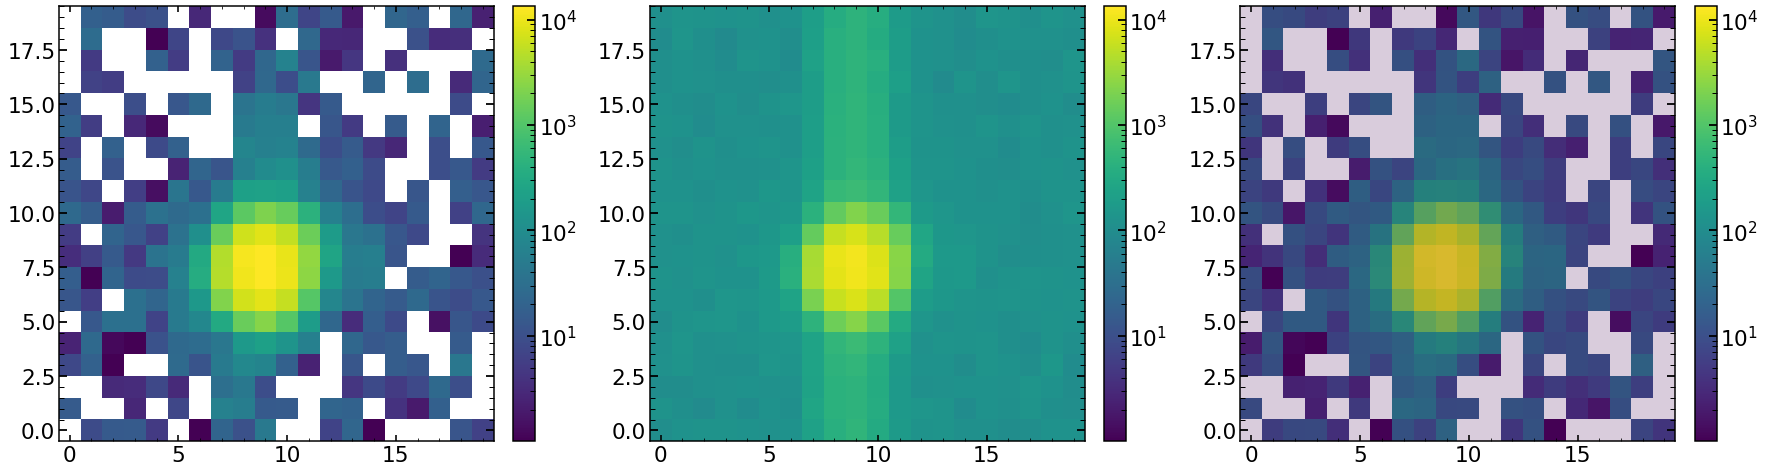

In [9]:
single_analysis=Zernike_Analysis(date=date,obs='0',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                 list_of_defocuses=list_of_defocuses_input_long)
single_analysis.create_basic_data_image()

In [10]:
#single_analysis=Zernike_Analysis(date=date,obs='m4',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
#                                 list_of_defocuses=['m4','m35','m3','m05','0','p05','p3','p35','p4'])


double_sources,double_sources_positions_ratios=single_analysis.return_double_sources()
list_of_sci_images,list_of_var_images,list_of_mask_images=single_analysis.return_lists_of_images()
index_of_single_image=single_analysis.return_index_of_single_image_in_list_of_images()
columns,columns22,columns22_analysis=single_analysis.return_columns()

chain0_swarm_1,likechain0_swarm_1=single_analysis.create_chains_swarm_1()
#chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain_parametrization,like_min=single_analysis.create_likelihood()

(101, 240, 129)
(101, 240, 129)
minimal likelihood is: 3013.6601812412187
average chi2 reduced is: 9.568279748260164


Text(0, 0.5, 'par_1')

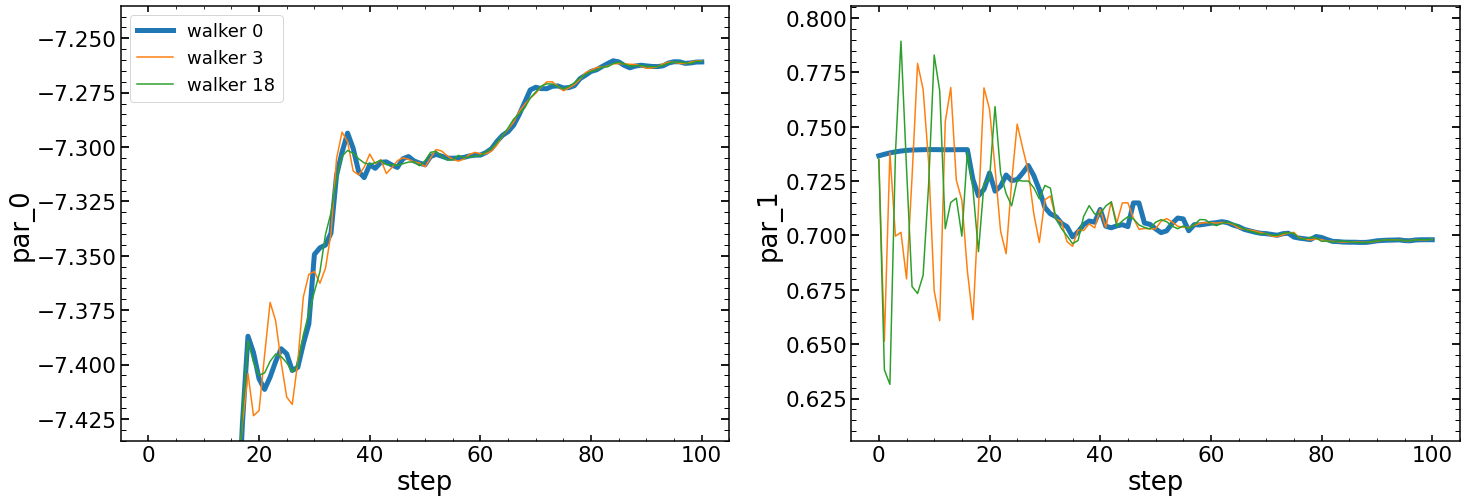

In [11]:
# wavefront paramter
plt.figure(figsize=(24,8))
i=0*2
plt.subplot(121)
# two different walkers, parameter 0
plt.plot(chain0_swarm_1[:,0][:,i],lw=5,label='walker 0')
plt.plot(chain0_swarm_1[:,3][:,i],label='walker 3')
plt.plot(chain0_swarm_1[:,18][:,i],label='walker 18')
plt.xlabel('step')
plt.ylabel('par_'+str((i)))
mean_one_walker=np.mean(chain0_swarm_1[:,18][:,i])
plt.ylim(mean_one_walker-0.1,mean_one_walker+0.1)
plt.legend()

plt.subplot(122)
#  paramter 2 (z5)

mean_one_what=np.mean(chain0_swarm_1[:,:,i+1][:,2])
plt.plot(chain0_swarm_1[:,:,i+1][:,0],lw=5)
plt.plot(chain0_swarm_1[:,:,i+1][:,3])
plt.plot(chain0_swarm_1[:,:,i+1][:,18])
plt.ylim(mean_one_what-0.1,mean_one_what+0.1)
plt.xlabel('step')
plt.ylabel('par_'+str((i+1)))

Text(0, 0.5, 'par_39')

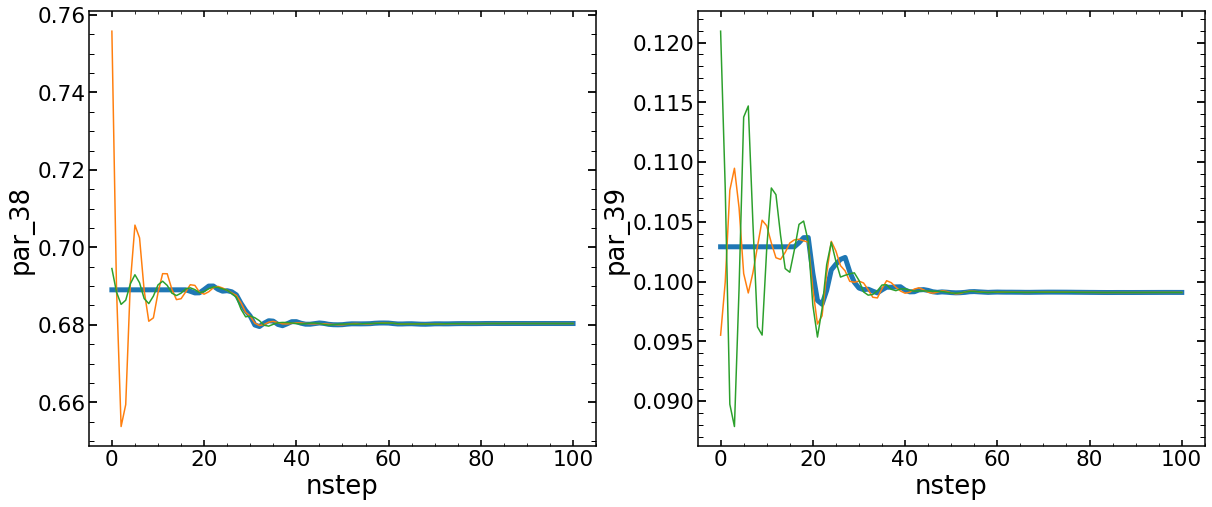

In [12]:
# pupil paramter
plt.figure(figsize=(20,8))
i=19*2
plt.subplot(121)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i],lw=5,label='walker 0')
plt.plot(chain0_swarm_1[:,3][:,i],label='walker 3')
plt.plot(chain0_swarm_1[:,18][:,i],label='walker 18')

plt.xlabel('nstep')
plt.ylabel('par_'+str((i)))

plt.subplot(122)
plt.plot(chain0_swarm_1[:,:,i+1][:,0],lw=5,label='walker 0')
plt.plot(chain0_swarm_1[:,:,i+1][:,3],label='walker 3')
plt.plot(chain0_swarm_1[:,:,i+1][:,18],label='walker 18')
plt.xlabel('nstep')
plt.ylabel('par_'+str((i+1)))

Text(0, 0.5, 'std. devation of a single parameter 38')

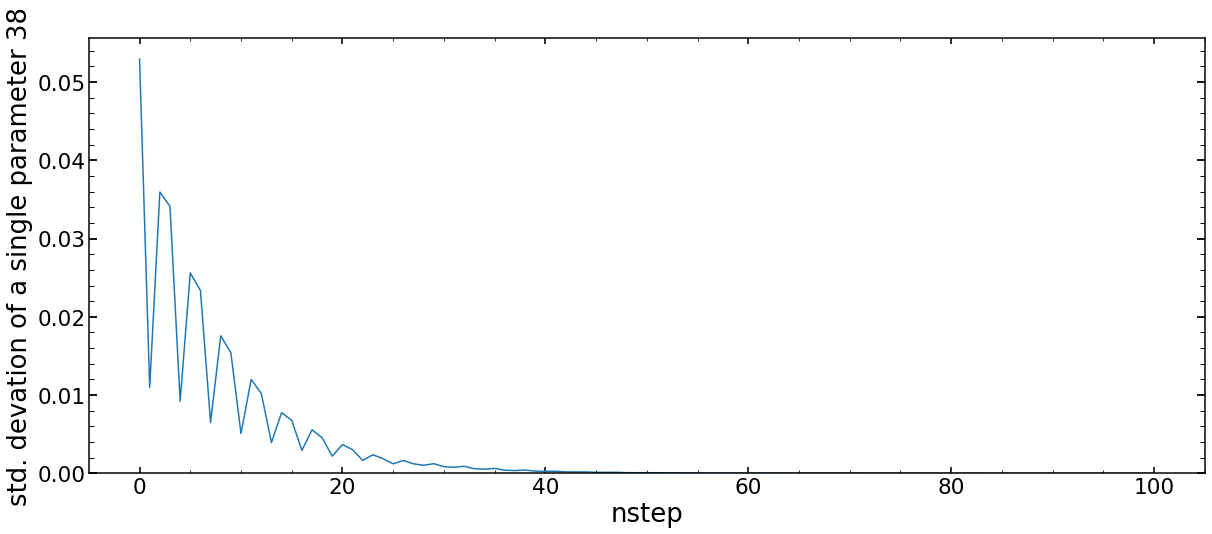

In [13]:
list_of_std=[]
i=19*2+0
for j in range(len(chain0_swarm_1)):
    list_of_std.append(np.std(chain0_swarm_1[:,:,i][j]))

plt.figure(figsize=(20,8))
plt.plot(list_of_std)
plt.ylim(0)
plt.xlabel('nstep')
plt.ylabel('std. devation of a single parameter '+str(i))

(101, 240, 129)
minimal likelihood is: 3013.6601812412187
average chi2 reduced is: 9.568279748260164
(101, 240, 129)


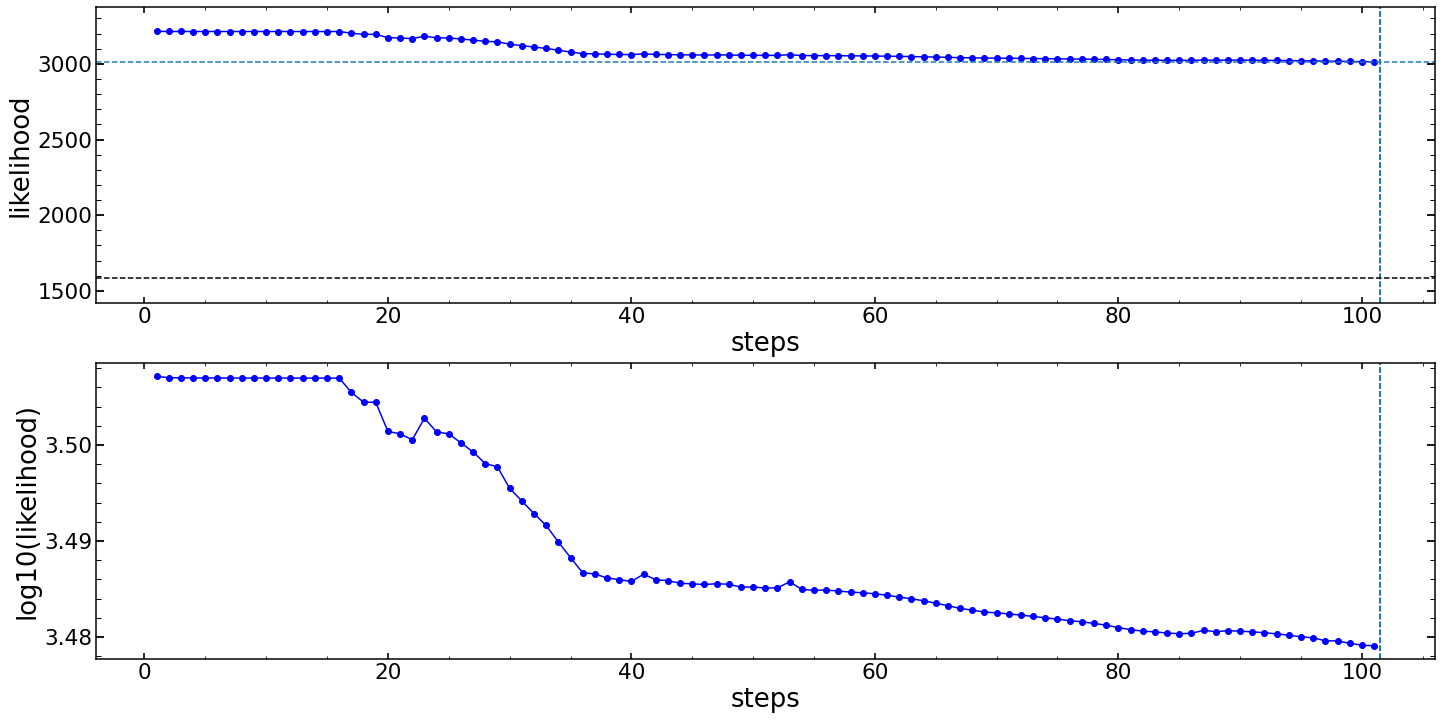

In [14]:
single_analysis.create_fitting_evolution_plot()

## Image creation and image analysis

In [71]:
minchain_parametrization_custom=np.copy(minchain_parametrization)

In [88]:
minchain_parametrization_custom[39]=minchain_parametrization[39]*1.25
minchain_parametrization_custom[39]

0.12386366975514886

In [130]:
model_multi=LN_PFS_multi_same_spot(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=1,zmax=56,verbosity=1,\
                      double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=False)   

#list_of_minchain=model_multi.create_list_of_allparameters(t1,list_of_defocuses=list_of_defocuses_input_long,zmax=56)
list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=list_of_defocuses_input_long,zmax=22)
#list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=['m4','p4'],zmax=56)

res_multi=model_multi(list_of_minchain,return_Images=True)


mean_res_of_multi_same_spot,list_of_single_res,list_of_single_model_image,\
                list_of_single_allparameters,list_of_single_chi_results,array_of_psf_positions_output=res_multi

#model = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],dithering=1,save=1,zmax=22,verbosity=1,\
#                      double_sources=None,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)  

#res_with_Image=model(list_of_minchain[index_of_single_image],return_Image=True)

################################
analyzing image 1 out of 9
 
Science image shape is: (60, 60)
Top left pixel value of the science image is: 3.0530858
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 155.51562
Mask image shape is: (60, 60)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.35d
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56

Entering lnlike_Neven
allparameters [   29.74012355    -0.75523216    -0.23951805     0.45260875
     0.26301342     0.08946656    -0.31954446    -0.11245643
    -0.12872774    -0.11961647    -0.1102447      0.01533952
    -0.01442428     0.09725185     0.03025749     0.05549057
    -0.02202338    -0.00672429     0.13002242     0.68034106
     0.09909094    -0.20649468    -0.01763408     0.05362782
     0.0568914      

chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.692442
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.692362
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.69237
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.692366
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.692379
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.692364
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.692358
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.692366
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.692373
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.692358
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.692366
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.692366
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.692364


Time for wavefront and wavefront/pupil combining is 0.00037288665771484375
type(expwf_grid)<class 'numpy.complex64'>
Time for FFT is 0.3829939365386963
type(img_apod)<class 'numpy.float32'>
Finished with _getOptPsf_naturalResolution
 
 
Entering optPsf_postprocessing
optPsf.shape: (3072, 3072)
oversampling_original: 35.374287997579025
size_of_central_cut: 2476
optPsf_cut.shape(2477, 2477)
oversampling:9.0
optPsf_cut.shape[0]2477
size_of_optPsf_cut_downsampled: 630.0
optPsf_cut_downsampled.shape: (631, 631)
size_of_optPsf_cut_in_Microns: 1051.6666666666667
postprocessing parameters:
['grating_lines', 'scattering_slope', 'scattering_amplitude', 'pixel_effect', 'fiber_r']
[50892.06684106284, 2.3415997345664468, 0.0024117876626375562, 0.38477490423418814, 1.795393085378514]
type(pointsx): <class 'numpy.float32'>
optPsf_cut_downsampled_scattered.shape:(631, 631)
simulation_00 parameter:None
are we invoking double sources (1 or True if yes): False
double source position/ratio is:[0 0]
Time f

chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.250181
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.250183
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.250181
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.250183
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.250181
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.250183
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.250183
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.250181
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.250185
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.250183
chi2 within shgo optimization routine (chi_2_almost_multi_values): 17.250183
We are fitting for only one source
One source fitting result is [ 9.18326027 -4.47298722]
type(complete_realization_renormalized)<class 'numpy.float32'>


We are fitting for only one source
One source fitting result is [12.6012687   4.26269613]
type(complete_realization_renormalized)<class 'numpy.float32'>
Time for single_Psf_position protocol is 0.26521801948547363
Sucesfully created optPsf_cut_fiber_convolved_downsampled
Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.9941839287586526
Finished with lnlike_Neven
chi_2_almost/d.o.f is 18.539602; chi_2_almost_max_dof is 3634.3384 log(improvment) is -2.292325
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4760384960
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4760384960 is: 4.698805093765259 seconds
 
###############

chi2 within shgo optimization routine (chi_2_almost_multi_values): 4.3165746
chi2 within shgo optimization routine (chi_2_almost_multi_values): 4.3150606
chi2 within shgo optimization routine (chi_2_almost_multi_values): 4.3150997
chi2 within shgo optimization routine (chi_2_almost_multi_values): 4.3149824
chi2 within shgo optimization routine (chi_2_almost_multi_values): 4.3152285
chi2 within shgo optimization routine (chi_2_almost_multi_values): 4.314964
chi2 within shgo optimization routine (chi_2_almost_multi_values): 4.3152013
chi2 within shgo optimization routine (chi_2_almost_multi_values): 4.3149548
chi2 within shgo optimization routine (chi_2_almost_multi_values): 4.314966
chi2 within shgo optimization routine (chi_2_almost_multi_values): 4.3149505
chi2 within shgo optimization routine (chi_2_almost_multi_values): 4.314989
chi2 within shgo optimization routine (chi_2_almost_multi_values): 4.314951
chi2 within shgo optimization routine (chi_2_almost_multi_values): 4.3149667
chi

Time for wavefront and wavefront/pupil combining is 0.00036406517028808594
type(expwf_grid)<class 'numpy.complex64'>
Time for FFT is 0.3218832015991211
type(img_apod)<class 'numpy.float32'>
Finished with _getOptPsf_naturalResolution
 
 
Entering optPsf_postprocessing
optPsf.shape: (3072, 3072)
oversampling_original: 35.374287997579025
size_of_central_cut: 990
optPsf_cut.shape(991, 991)
oversampling:9.0
optPsf_cut.shape[0]991
size_of_optPsf_cut_downsampled: 252.0
optPsf_cut_downsampled.shape: (253, 253)
size_of_optPsf_cut_in_Microns: 421.6666666666667
postprocessing parameters:
['grating_lines', 'scattering_slope', 'scattering_amplitude', 'pixel_effect', 'fiber_r']
[50892.06684106284, 2.3415997345664468, 0.0024117876626375562, 0.38477490423418814, 1.795393085378514]
type(pointsx): <class 'numpy.float32'>
optPsf_cut_downsampled_scattered.shape:(253, 253)
simulation_00 parameter:None
are we invoking double sources (1 or True if yes): False
double source position/ratio is:[0 0]
Time for po

Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.9925636828170651
Finished with lnlike_Neven
chi_2_almost/d.o.f is 2.7218103; chi_2_almost_max_dof is 421.04288 log(improvment) is -2.1894684
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4760384960
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4760384960 is: 3.239731788635254 seconds
 
################################
analyzing image 6 out of 9
 
Science image shape is: (20, 20)
Top left pixel value of the science image is: 3.451853
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 120.553505
Mask image shape is: (20, 20)
Sum of mask image is: 0.0
Dithering value is: 1

sup

/Users/nevencaplar/anaconda2/envs/idp2_pyfftw/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


chi2 within shgo optimization routine (chi_2_almost_multi_values): 11.066703
chi2 within shgo optimization routine (chi_2_almost_multi_values): 2.6963012
chi2 within shgo optimization routine (chi_2_almost_multi_values): 3.6682801
chi2 within shgo optimization routine (chi_2_almost_multi_values): 2.6660821
chi2 within shgo optimization routine (chi_2_almost_multi_values): 3.559693
chi2 within shgo optimization routine (chi_2_almost_multi_values): 2.4994972
chi2 within shgo optimization routine (chi_2_almost_multi_values): 3.6941192
chi2 within shgo optimization routine (chi_2_almost_multi_values): 2.4668994
chi2 within shgo optimization routine (chi_2_almost_multi_values): 2.5361729
chi2 within shgo optimization routine (chi_2_almost_multi_values): 2.4570746
chi2 within shgo optimization routine (chi_2_almost_multi_values): 2.6080947
chi2 within shgo optimization routine (chi_2_almost_multi_values): 2.450056
chi2 within shgo optimization routine (chi_2_almost_multi_values): 2.5126748
c

Time for postprocessing pupil after _get_Pupil 0.28636908531188965
Time for pupil and illumination calculation is 0.29267311096191406

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -21.08346550909346, 0.859396447274559, 0.19317363233951562, 0.27849946688274524, 0.7155773212815519, 0.12885641595437125, -0.18414014092625658, -0.02259156762377472, -0.13425217784167354, -0.08606035015707628, 0.06247213692313615, 0.0419225811845038, -0.018143786752417967, -0.01587842327204915, 0.015137000669454167, -0.004318298831865283, -0.020393480515396467, 0.02392816225378281, -0.046493024532484786, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, 0.859396447274559, 0.19317363233951562, 0.27849946688274524, 0.7155773212815519, 0.12885641595437125, -0.18414014092625658, 0, -0.13425217784167354, -0.0

We are fitting for only one source
One source fitting result is [-6.08860091 -9.88663194]
type(complete_realization_renormalized)<class 'numpy.float32'>
Time for single_Psf_position protocol is 0.4606947898864746
Sucesfully created optPsf_cut_fiber_convolved_downsampled
Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.9956451496255466
Finished with lnlike_Neven
chi_2_almost/d.o.f is 10.523656; chi_2_almost_max_dof is 2382.1985 log(improvment) is -2.3548114
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4760384960
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4760384960 is: 4.235203981399536 seconds
 
###############

chi2 within shgo optimization routine (chi_2_almost_multi_values): 14.318378
chi2 within shgo optimization routine (chi_2_almost_multi_values): 14.292014
chi2 within shgo optimization routine (chi_2_almost_multi_values): 14.3224325
chi2 within shgo optimization routine (chi_2_almost_multi_values): 14.348638
chi2 within shgo optimization routine (chi_2_almost_multi_values): 14.364588
chi2 within shgo optimization routine (chi_2_almost_multi_values): 14.373329
chi2 within shgo optimization routine (chi_2_almost_multi_values): 14.373329
chi2 within shgo optimization routine (chi_2_almost_multi_values): 14.373329
chi2 within shgo optimization routine (chi_2_almost_multi_values): 14.373329
chi2 within shgo optimization routine (chi_2_almost_multi_values): 13.098512
chi2 within shgo optimization routine (chi_2_almost_multi_values): 23.017376
chi2 within shgo optimization routine (chi_2_almost_multi_values): 14.010657
chi2 within shgo optimization routine (chi_2_almost_multi_values): 14.14726

Time to apodize the pupil: 0.13378095626831055
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.2841510772705078
Time for pupil and illumination calculation is 0.2892589569091797

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -28.343978232150587, 1.090057676734888, 0.2549867300915077, 0.25362671153461364, 0.7802293075415667, 0.13448353830910476, -0.16479666639981805, -0.009753729448359158, -0.13504138335280622, -0.08126661812705425, 0.08714597142703566, 0.045720161153145165, -0.018675144687164552, -0.03203989100585068, 0.01297693037978785, -0.01286242361686623, -0.02016063810765572, 0.028307084676098916, -0.07170951726603432, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, 1.090057676734888, 0.2549867300915077, 0.253626711534

chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.118942
chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.118942
chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.118946
chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.118946
chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.118948
We are fitting for only one source
One source fitting result is [10.24423067 15.55195748]
type(complete_realization_renormalized)<class 'numpy.float32'>
Time for single_Psf_position protocol is 0.729708194732666
Sucesfully created optPsf_cut_fiber_convolved_downsampled
Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.9958003195672505
Finished with lnlike_Neven
chi_2_almost/d.o.f is 18.067877; chi_2_almost_max_dof is 2889.1006 log(improvment) is -2.2038555
multiprocessing.current_process(

In [131]:
minchain=list_of_minchain[0]

print(minchain.shape)

    
dfz11 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns22[0:8])
print(dfz11)

dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][8:19]]),columns=columns22[8:19])
print(dfz22)

print('')
#dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][19:len(columns)]]),columns=columns[19:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][19:30]]),columns=columns22[19:30])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][30:41]]),columns=columns22[30:41])
print(dfglobal2)

(42,)
          z4        z5        z6        z7        z8        z9       z10  \
0  29.740124 -0.755232 -0.239518  0.452609  0.263013  0.089467 -0.319544   

        z11  
0 -0.112456  
        z12       z13       z14      z15       z16       z17       z18  \
0 -0.128728 -0.119616 -0.110245  0.01534 -0.014424  0.097252  0.030257   

        z19       z20       z21       z22  
0  0.055491 -0.022023 -0.006724  0.130022  

    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.680341   0.099091 -0.206495 -0.017634  0.053628     0.056891   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum   x_fiber  
0           0.000031             0.000031  0.976731  0.948362  0.053938  
    y_fiber  effective_radius_illumination  frd_sigma  frd_lorentz_factor  \
0 -0.077112                       0.985411   0.045041            0.475151   

   det_vert  slitHolder_frac_dx  grating_lines  scattering_slope  \
0  1.012424            0.656877   50892.066841            2.3416 

(-2.8, -1.5)

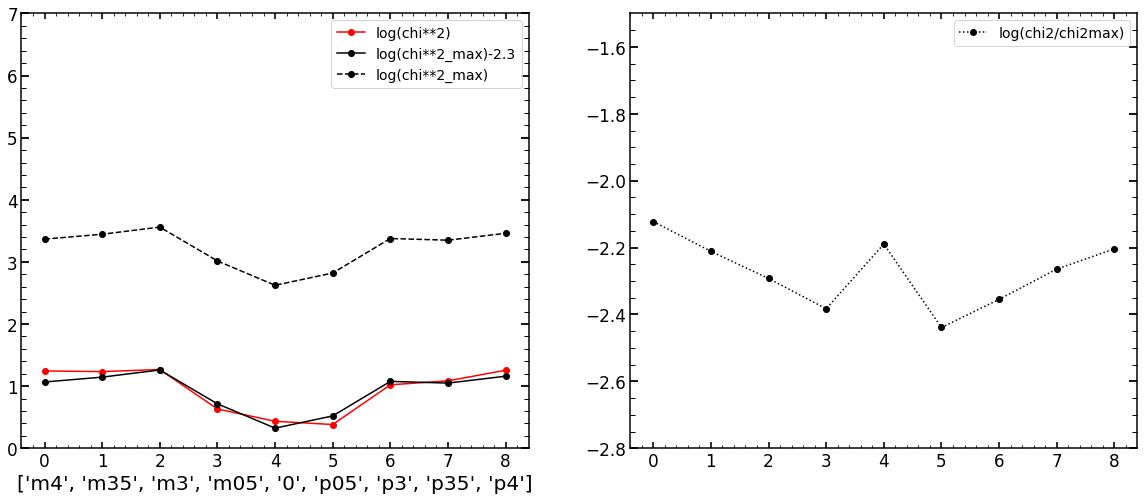

In [132]:
chi_results_array=np.array(res_multi[4])

plt.figure(figsize=(20,8))

plt.subplot(121)

plt.plot(np.log10(chi_results_array[:,2]),color='red',label='log(chi**2)',marker='o')
plt.plot(np.log10(chi_results_array[:,3])-2.3,color='black',label='log(chi**2_max)-2.3',marker='o')
plt.plot(np.log10(chi_results_array[:,3]),color='black',label='log(chi**2_max)',marker='o',ls='--')
plt.ylim(0,7)
plt.xlabel(list_of_defocuses_input_long)
plt.legend()
plt.subplot(122)

plt.plot(np.log10(chi_results_array[:,2]/chi_results_array[:,3]),color='black',label='log(chi2/chi2max)',marker='o',ls=':')
plt.legend()
plt.ylim(-2.8,-1.5)

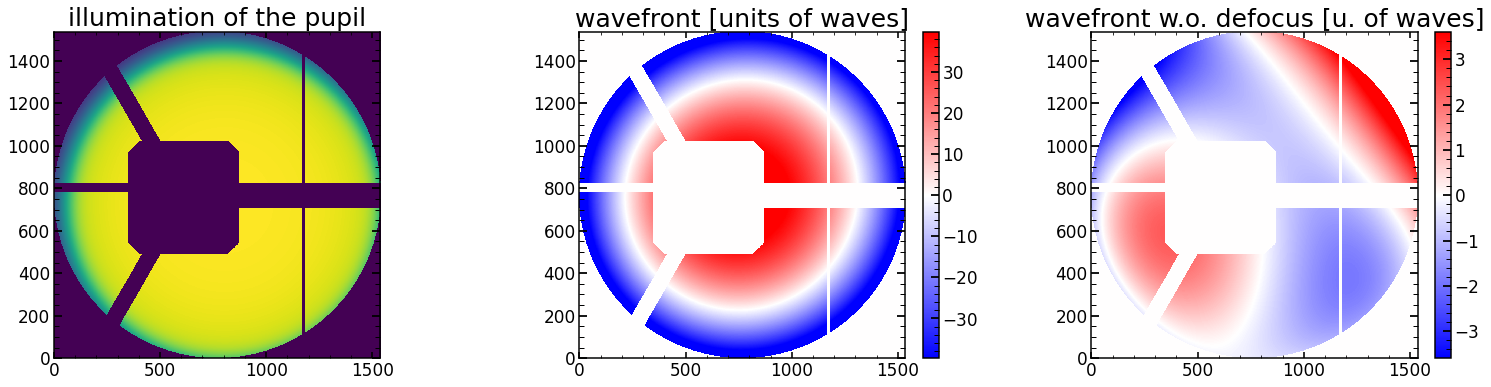

In [137]:
single_analysis.illumination_wavefront_plot()

chi**2 reduced is: 18.539602
Abs of residual divided by total flux is: 0.056572933
Abs of residual divided by largest value of a flux in the image is: 0.13522556


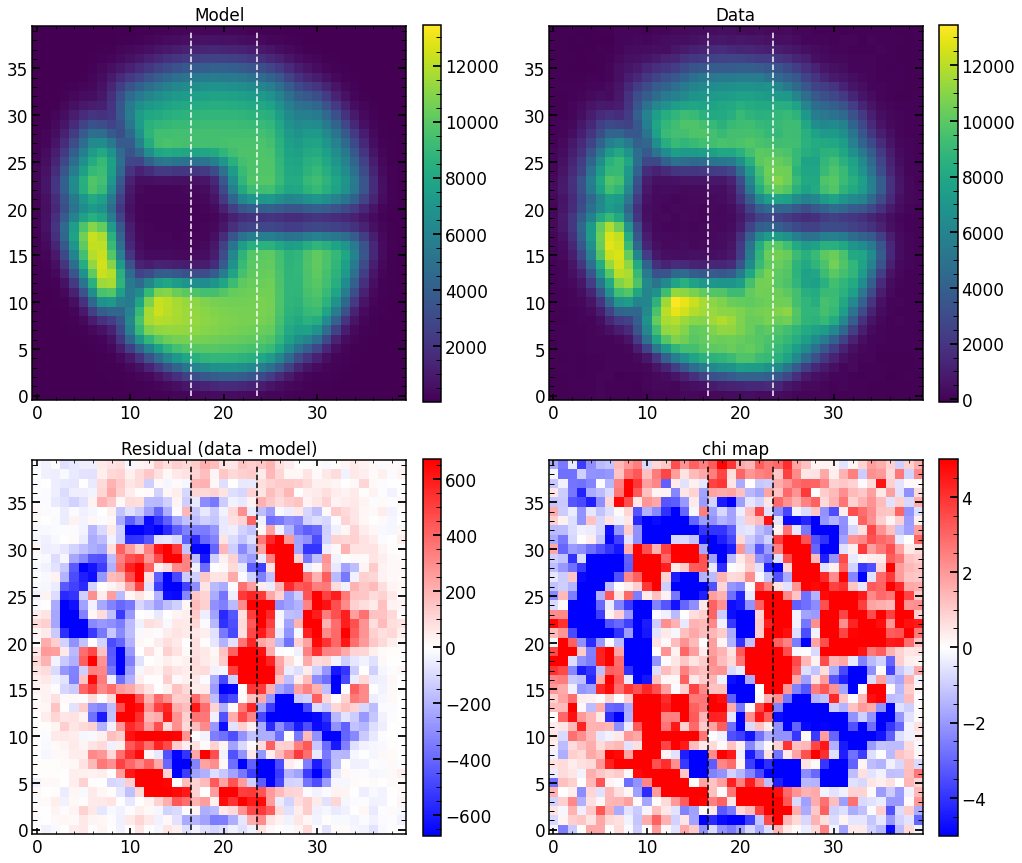

In [138]:
index_of_single_image=2

matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot(custom_model_image=list_of_single_model_image[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image],\
                                             show_flux_mask=False)

chi**2 max reduced is: 3615.7993
chi**2 reduced is: 18.539602
Abs of residual divided by total flux is: 0.056572933
Abs of residual divided by largest value of a flux in the image is: 0.13522556


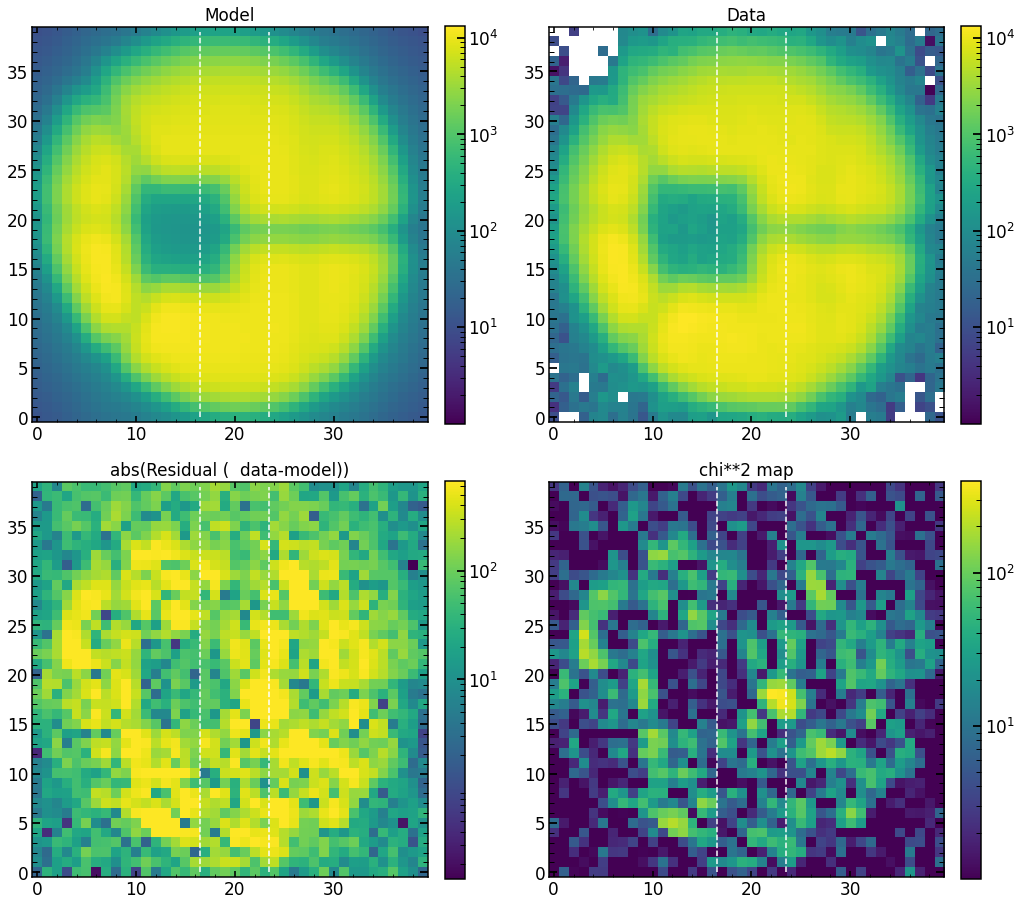

In [139]:
single_analysis.create_basic_comparison_plot_log(custom_model_image=list_of_single_model_image[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image],\
                                                show_flux_mask=False)

18.539602
chi**2 reduced is: 18.539602
Abs of residual divided by total flux is: 0.056572933
Abs of residual divided by largest value of a flux in the image is: 0.13522556


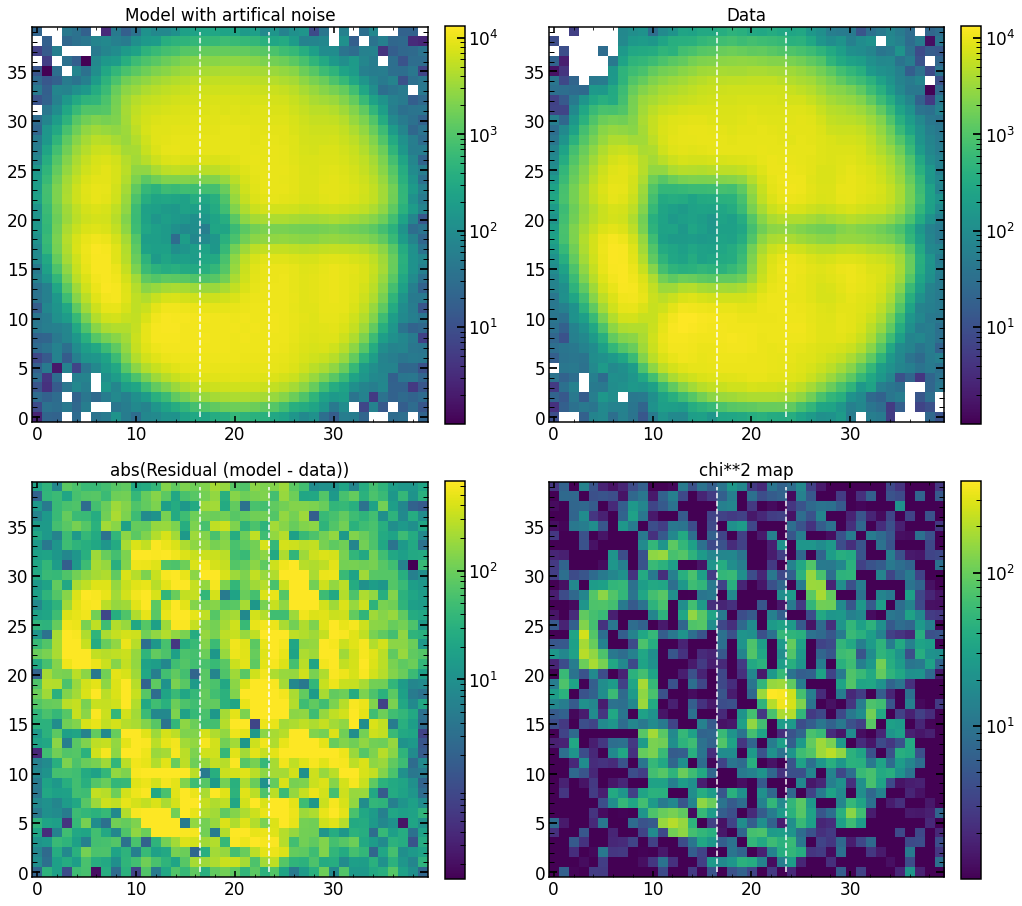

In [140]:
single_analysis.create_basic_comparison_plot_log_artifical(custom_model_image=list_of_single_model_image[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image])

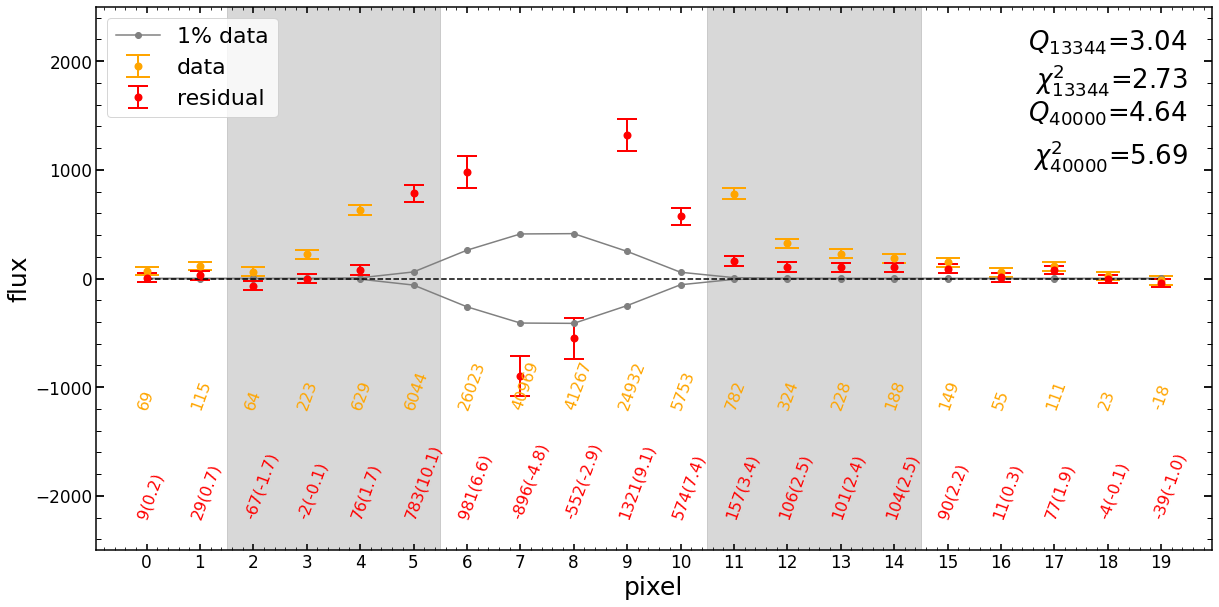

In [112]:
index_of_single_image=4
plot_1D_residual(sci_image=list_of_sci_images[index_of_single_image],var_image=list_of_var_images[index_of_single_image],model_image=list_of_single_model_image[index_of_single_image])

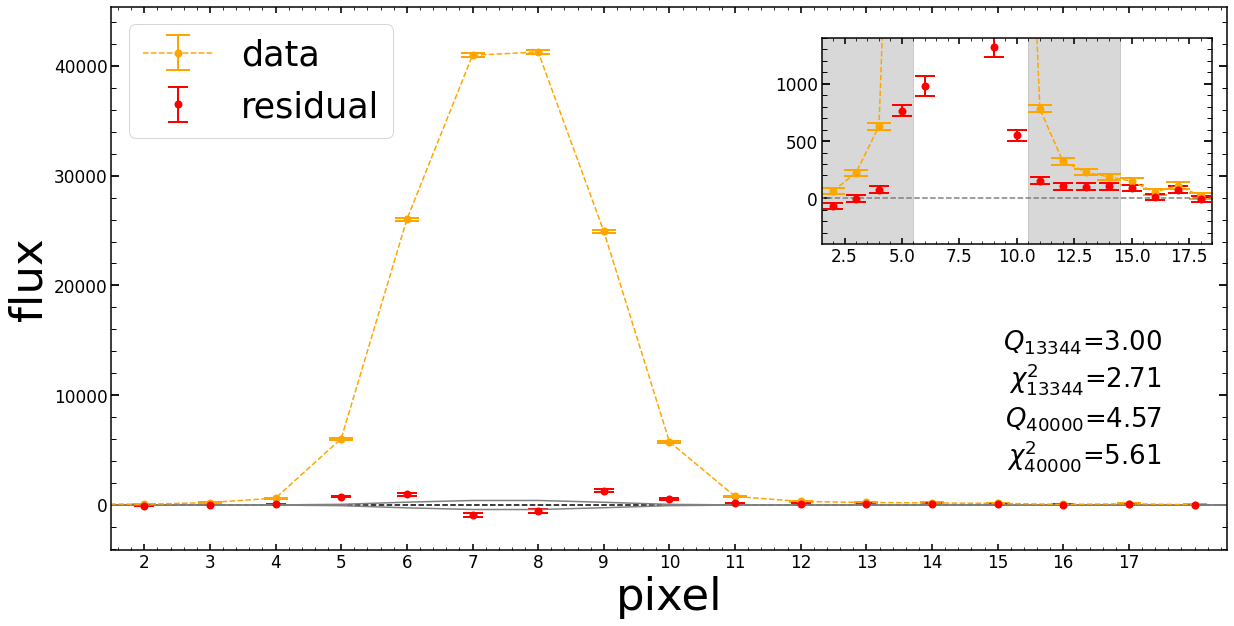

In [97]:
plot_1D_residual_custom_large(sci_image=list_of_sci_images[index_of_single_image],var_image=list_of_var_images[index_of_single_image],model_image=list_of_single_model_image[index_of_single_image])

# Attempt at predicting change, again

In [28]:
minchain_parametrization=minchain_parametrization[:42+19]

In [29]:
model_multi=LN_PFS_multi_same_spot(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=0,zmax=22,verbosity=1,\
                      double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=False)   

#list_of_minchain=model_multi.create_list_of_allparameters(t1,list_of_defocuses=list_of_defocuses_input_long,zmax=56)
list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=list_of_defocuses_input_long,zmax=22)
#list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=['m4','p4'],zmax=56)

res_multi=model_multi(list_of_minchain,return_Images=True)

################################
analyzing image 1 out of 9
 
Science image shape is: (60, 60)
Top left pixel value of the science image is: 3.0530858
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 155.51562
Mask image shape is: (60, 60)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.35b
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22

Entering lnlike_Neven
allparameters [   30.68136654    -0.641571      -0.09937984     0.53726784
     0.45495572     0.10345705    -0.30465154     0.03918097
    -0.19345223    -0.11808221    -0.11662542     0.02552906
    -0.08183847     0.11202542     0.02498072     0.05760417
    -0.02625805    -0.03172565    -0.07836136     0.70473287
     0.06042617     1.25526793     0.02567396     0.07007222
    -0.14921405     

In [27]:
mean_res_of_multi_same_spot,list_of_single_res,list_of_single_model_image,\
                list_of_single_allparameters,list_of_single_chi_results,array_of_psf_positions_output=res_multi

TypeError: cannot unpack non-iterable float object

In [741]:
list_of_single_model_image[0]

array([[ 5.9707503,  6.3685412,  6.7820024, ...,  6.3234787,  5.9705997,
         5.638842 ],
       [ 6.3901086,  6.824877 ,  7.278482 , ...,  6.7747006,  6.385947 ,
         6.0214767],
       [ 6.827508 ,  7.302539 ,  7.8000784, ...,  7.2475986,  6.8193164,
         6.4187803],
       ...,
       [ 8.630907 ,  9.31055  , 10.03944  , ...,  8.482618 ,  7.9267664,
         7.4129   ],
       [ 8.066921 ,  8.679117 ,  9.331659 , ...,  7.9401345,  7.436526 ,
         6.9693055],
       [ 7.533326 ,  8.086405 ,  8.673715 , ...,  7.4208384,  6.9647346,
         6.540301 ]], dtype=float32)

In [44]:
#date='Jul2020'
date='Sep2820'
obs=21448
#obs_multi=[21352, 21358, 21364, 21436, 21442, 21448 ]
obs_int=int(obs)
single_number='3'
image_index=int(single_number)
eps=6
arc='HgAr'
dataset=4

list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

single_analysis=Zernike_Analysis(date=date,obs='m3',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                 list_of_defocuses=list_of_defocuses_input_long)
double_sources,double_sources_positions_ratios=single_analysis.return_double_sources()
list_of_sci_images,list_of_var_images,list_of_mask_images=single_analysis.return_lists_of_images()
index_of_single_image=single_analysis.return_index_of_single_image_in_list_of_images()
columns,columns22,columns22_analysis=single_analysis.return_columns()

chain0_swarm_1,likechain0_swarm_1=single_analysis.create_chains_swarm_1()
#chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain_parametrization,like_min=single_analysis.create_likelihood()

model_multi=LN_PFS_multi_same_spot(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=0,zmax=56,verbosity=1,\
                      double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536)   
list_of_minchain_1=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=list_of_defocuses_input_long,zmax=56)

labelInput: m3
self.single_number: 3
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [21352, 21358, 21364, 21394, 21400, 21406, 21436, 21442, 21448]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes/finalHgAr_Feb2020'>
analyzing label: 21364
double_sources_positions_ratios for this spot is: [0 0]
(7, 120, 129)
(7, 120, 129)
minimal likelihood is: 3382.5717778593516
minimal chi2 reduced is (makes no sense for multi_var): -5.422008666347685


In [746]:
minchain_test_change=np.array([   30.68113253,    -0.54224251,    -0.21778256,     0.53538385,
           0.43835588,     0.14313753,    -0.24146913,     0.03315581,
          -0.17942337,    -0.16280891,    -0.12288053,     0.03915888,
          -0.08155131,     0.11049127,     0.03611835,     0.04363126,
          -0.02529712,    -0.00183564,     0.05092222,     0.68904049,
           0.10290975,    -0.20154677,    -0.01441376,     0.05355728,
           0.05813265,     0.0000314 ,     0.0000314 ,     0.9767313 ,
           0.94836248,     0.02461952,    -0.05835101,     0.93393462,
           0.04867201,     0.49904901,     1.01173008,     0.63182418,
       51347.90306188,     2.32213302,     0.00238991,     0.37175131,
           1.79411345,     0.99627532,    -0.00095261,     0.00855313,
          -0.00046638,    -0.00345273,     0.00276937,     0.00093478,
          -0.01273449,    -0.00043051,    -0.00172966,     0.01098682,
          -0.00888265,     0.00650977,    -0.00416378,    -0.0108779 ,
           0.00295909,    -0.00045689,     0.0028767 ,    -0.00295547,
           0.00203661,     0.00340682,     0.00967699,    -0.00008546,
          -0.01357098,    -0.01201829,     0.00688158,     0.00828355,
          -0.00743031,    -0.00265967,     0.01032454,     0.01266948,
           0.00069986,     0.00681056,     0.00686048,    -0.01582771])

sci_image_unit=list_of_sci_images[0]
var_image_unit=list_of_var_images[0]

# model with everything
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,mask_image=list_of_mask_images[0],dithering=1,save=0,verbosity=0,npix=1536,\
                      zmax=56,fit_for_flux=True,explicit_psf_position=None)   


res=model(minchain_test_change,return_Image=True)

print(res[0])

initial_model_0=res[1]
explicit_position_of_default=res[-1]

# cut the values below the treshold to consider only pixels with a lot of flux to get the flux mask
mean_value_of_background=np.mean([np.median(sci_image_unit[0]),np.median(sci_image_unit[-1]),\
                                  np.median(sci_image_unit[:,0]),np.median(sci_image_unit[:,-1])])*50


flux_mask=sci_image_unit>(mean_value_of_background)

version of the code is: 0.35a
-48892.8671875


In [775]:
# move the wavefront parameters in 0 image

model_with_explicit_psf_position=LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=0,zmax=56,verbosity=0,\
                   double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,\
                   explicit_psf_position=explicit_position_of_default)   
    
list_of_model_movement_one_wavefront=[]
list_of_model_movement_one_wavefront_renormalized=[]
for k in tqdm(range(53)):
   

        if k<19:
            minchain_0=np.copy(minchain_test_change)
            minchain_0[k]=0.03+minchain_test_change[k]
        else:
            minchain_0=np.copy(minchain_test_change)
            minchain_0[k+23]=0.03+minchain_test_change[k+23]            

            
        #minchain_0[19]=0
        #minchain_0[20]=0

        res_0=model_with_explicit_psf_position(minchain_0,return_Image=True)
        model_movement_one_wavefront=np.copy(res_0[1])
        
        np.save('/Users/nevencaplar/Documents/PFS/TigerAnalysis/51_51_3/res_0_'+str(k),model_movement_one_wavefront)
        list_of_model_movement_one_wavefront.append(model_movement_one_wavefront)
        model_movement_one_wavefront_renormalized=model_movement_one_wavefront*np.sum(initial_model_0)/np.sum(model_movement_one_parameter)
        
        list_of_model_movement_one_wavefront_renormalized.append(model_movement_one_wavefront_renormalized)
        
array_of_model_movement_one_wavefront=np.array(list_of_model_movement_one_wavefront)
array_of_model_movement_one_wavefront_renormalized=np.array(list_of_model_movement_one_wavefront_renormalized)
np.save('/Users/nevencaplar/Documents/PFS/TigerAnalysis/51_51_3/array_of_res_0',array_of_model_movement_one_wavefront)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [01:35<00:00,  1.81s/it]


In [777]:
# i.e., move the global paramters, one by one
model_with_explicit_psf_position=LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=0,zmax=56,verbosity=0,\
                   double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,\
                   explicit_psf_position=explicit_position_of_default)


list_of_model_movement_one_global_parameter_renormalized=[]
list_of_model_movement_one_global_parameter=[]
for i in tqdm(range(-10,11)):
    minchain_1=np.copy(minchain_test_change)
    minchain_1[22]=minchain_test_change[22]+i*0.001
    res=model_with_explicit_psf_position(minchain_1,return_Image=True)
    model_movement_one_parameter=np.copy(res[1])
    list_of_model_movement_one_global_parameter.append(model_movement_one_parameter)
    model_movement_one_parameter_renormalized=res[1]*np.sum(initial_model_0)/np.sum(model_movement_one_parameter)
    list_of_model_movement_one_global_parameter_renormalized.append(model_movement_one_parameter_renormalized)

array_of_model_movement_one_global_parameter=np.array(list_of_model_movement_one_global_parameter)
array_of_model_movement_one_global_parameter_renormalized=np.array(list_of_model_movement_one_global_parameter_renormalized)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:46<00:00,  2.21s/it]


In [787]:
# i.e., move the global paramter, and also the wavefront
model_with_explicit_psf_position=LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=0,zmax=56,verbosity=0,\
                   double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,\
                   explicit_psf_position=explicit_position_of_default)


list_of_model_movement_one_global_parameter_one_wavefront_renormalized=[]
list_of_model_movement_one_global_parameter_one_wavefront=[]
i=range(-10,11)[7]
minchain_1=np.copy(minchain_test_change)
minchain_1[22]=minchain_test_change[22]+i*0.001

for k in tqdm(range(53)):
   

        if k<19:
            minchain_1_w=np.copy(minchain_1)
            minchain_1_w[k]=0.03+minchain_1[k]
        else:
            minchain_1_w=np.copy(minchain_1)
            minchain_1_w[k+23]=0.03+minchain_1[k+23]        


        res=model_with_explicit_psf_position(minchain_1_w,return_Image=True)
        model_movement_one_parameter_one_wavefront=np.copy(res[1])
        list_of_model_movement_one_global_parameter_one_wavefront.append(model_movement_one_parameter_one_wavefront)
        model_movement_one_parameter_renormalized=res[1]*np.sum(initial_model_0)/np.sum(model_movement_one_parameter)
        list_of_model_movement_one_global_parameter_one_wavefront_renormalized.append(model_movement_one_parameter_renormalized)

array_of_model_movement_one_global_parameter_one_wavefront=np.array(list_of_model_movement_one_global_parameter_one_wavefront)
array_of_model_movement_one_global_parameter_one_wavefront_renormalized=np.array(list_of_model_movement_one_global_parameter_one_wavefront_renormalized)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [01:27<00:00,  1.64s/it]


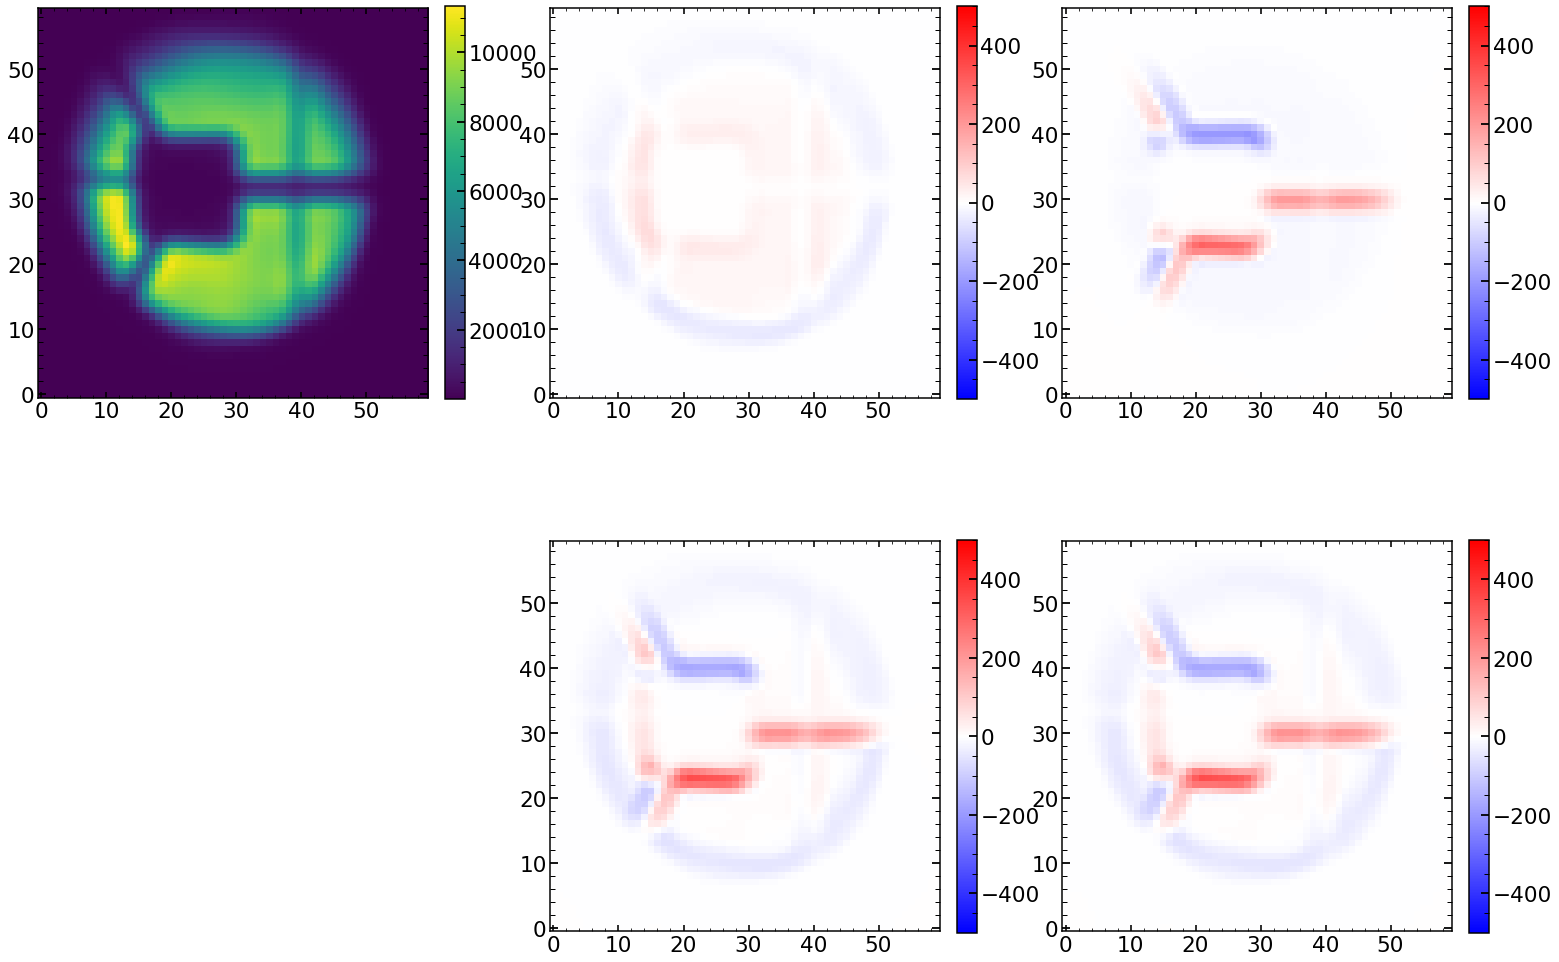

In [806]:
plt.figure(figsize=(26,18))
plt.subplot(231)
plt.imshow(initial_model_0)
cbar=plt.colorbar(fraction=0.046, pad=0.04)

wavefront_change=initial_model_0-array_of_model_movement_one_wavefront_renormalized[0]
wavefront_change_percentage=1-array_of_model_movement_one_wavefront_renormalized[0]/initial_model_0
plt.subplot(232)
plt.imshow(wavefront_change,cmap='bwr',vmax=500,vmin=-500)
cbar=plt.colorbar(fraction=0.046, pad=0.04)

global_change=initial_model_0-array_of_model_movement_one_global_parameter_renormalized[7]
global_change_percentage=(1-array_of_model_movement_one_global_parameter_renormalized[7]/initial_model_0)
plt.subplot(233)
plt.imshow(initial_model_0-array_of_model_movement_one_global_parameter_renormalized[7],cmap='bwr',vmax=500,vmin=-500)
cbar=plt.colorbar(fraction=0.046, pad=0.04)

total_change=initial_model_0-array_of_model_movement_one_global_parameter_one_wavefront_renormalized[0]
total_change_percentage=1-array_of_model_movement_one_global_parameter_one_wavefront_renormalized[0]/initial_model_0
plt.subplot(235)
plt.imshow(initial_model_0-array_of_model_movement_one_global_parameter_one_wavefront_renormalized[0],cmap='bwr',vmax=500,vmin=-500)
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(236)
plt.imshow((wavefront_change)+\
           (global_change),cmap='bwr',vmax=500,vmin=-500)
cbar=plt.colorbar(fraction=0.046, pad=0.04)

In [804]:
print(np.sum(total_change))
print(np.sum(wavefront_change))
print(np.sum(global_change))

print(np.sum(wavefront_change+global_change))

-2.8476562
-1.994873
-0.58984375
-2.5888672


In [ ]:
Tokovinin_multi_instance(parInit1Init_)

In [812]:
res_input=tes_res

In [813]:
res_input

(-1449.3709932201075,
 array([   -7.48584024,     0.73497698,     0.19568978,     0.15682353,
            0.03769565,     0.02577918,    -0.03734586,     0.39183789,
            0.02550665,     0.556507  ,     0.0072312 ,     0.1261021 ,
            0.01097693,    -0.26493479,    -0.01831573,    -0.05247759,
            0.01020252,    -0.15314955,     0.00343817,    -0.10475206,
            0.02711867,    -0.0137685 ,     0.00445374,     0.0372618 ,
            0.01458828,    -0.02237409,    -0.01880653,     0.03841714,
           -0.00188257,     0.02112357,    -0.00910924,     0.01975998,
           -0.00067647,    -0.02366152,     0.00463751,     0.012873  ,
           -0.00621102,     0.06599903,     0.68904049,    10.        ,
           -0.20154677,    -0.01441376,     0.05355728,     0.05813265,
            0.0000314 ,     0.0000314 ,     0.9767313 ,    10.        ,
            0.02461952,    -0.05835101,     0.93393462,     0.04867201,
            0.49904901,     1.01173008,   

In [908]:
Tokovinin_multi_instance=Tokovinin_multi(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=0,zmax=22,verbosity=0,\
                      list_of_defocuses=list_of_defocuses_input_long,double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=True)
tes_res=Tokovinin_multi_instance(parInit1[110])

In [ ]:
tes_res

In [846]:
uber_images_normalized_previous_best,uber_M0_previous_best,H_previous_best,array_of_delta_all_parametrizations_None_previous_best=tes_res[-1]

In [ ]:
def create_simplied_H(uber_M0_after_global,array_of_wavefront_changes_of_best_model_input,array_of_wavefront_changes_of_best_model_input_parameters,pre_model_proposal):
    
    
    
    

In [847]:
uber_M0=uber_M0_previous_best
uber_images_normalized=uber_images_normalized_previous_best
array_of_delta_all_parametrizations_None=array_of_delta_all_parametrizations_None_previous_best


H=np.transpose(np.array((uber_images_normalized-uber_M0))/array_of_delta_all_parametrizations_None) 

In [849]:
np.mean(H==H_previous_best)

1.0

In [ ]:
# stays the same
uber_images_normalized


# changes 
uber_M0
array_of_delta_all_parametrizations_None

# describes wavefront changes
H_previous_best

In [851]:
uber_M0.shape

(11972,)

In [891]:
#lets just say it is the same
array_of_delta_wavefront_parametrizations_in_global_step_None=array_of_delta_all_parametrizations_None_previous_best

# array_of_delta_wavefront_parametrizations_in_global_step_None array_of_delta_wavefront_parametrizations_in_global_step[:,None]

In [892]:
# wavefront changes from the default -> array_of_delta_wavefront_parametrizations_in_global_step
array_of_wavefront_changes=(H_previous_best*array_of_delta_wavefront_parametrizations_in_global_step_None[:,0])

print(array_of_wavefront_changes.shape)

(11972, 38)


In [893]:
global_change=uber_M0-uber_M0_previous_best

In [894]:
H=array_of_wavefront_changes+global_change[:,None]

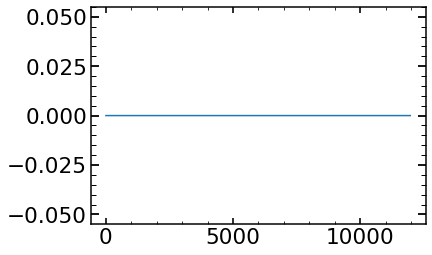

In [888]:
plt.plot(global_change)

In [ ]:
previous_best_result

In [904]:
def create_simplied_H(previous_best_result,uber_M0):
    
    uber_images_normalized_previous_best=previous_best_result[0]
    uber_M0_previous_best=previous_best_result[1]
    H_previous_best=previous_best_result[2]
    array_of_delta_all_parametrizations_None_previous_best=previous_best_result[3]

    
    ratio_of_parametrizations=(array_of_delta_all_parametrizations[:,None]/array_of_delta_all_parametrizations_None_previous_best)
    #array_of_wavefront_changes=(H_previous_best*array_of_delta_wavefront_parametrizations_in_global_step_None[:,0])
    array_of_wavefront_changes=np.transpose(ratio_of_parametrizations*np.array(uber_images_normalized_previous_best-uber_M0_previous_best)/(array_of_delta_all_parametrizations_None_previous_best))  
    
    global_change=uber_M0-uber_M0_previous_best
    H=array_of_wavefront_changes+global_change[:,None]
    return H

In [897]:
create_simplied_H(uber_images_normalized_previous_best,uber_M0_previous_best,H_previous_best,array_of_delta_all_parametrizations_None_previous_best,uber_M0)

NameError: name 'array_of_delta_all_parametrizations' is not defined

In [ ]:
    def create_simplified_H(self,previous_best_result,uber_M0):
        
        uber_images_normalized_previous_best=previous_best_result[0]
        uber_M0_previous_best=previous_best_result[1]
        H_previous_best=previous_best_result[2]
        array_of_delta_all_parametrizations_None_previous_best=previous_best_result[3]
        
        ratio_of_parametrizations=(array_of_delta_all_parametrizations[:,None]/array_of_delta_all_parametrizations_None_previous_best)
        #array_of_wavefront_changes=(H_previous_best*array_of_delta_wavefront_parametrizations_in_global_step_None[:,0])
        array_of_wavefront_changes=np.transpose(ratio_of_parametrizations*np.array(uber_images_normalized_previous_best-uber_M0_previous_best)/(array_of_delta_all_parametrizations_None_previous_best))  
        
        global_change=uber_M0-uber_M0_previous_best
        H=array_of_wavefront_changes+global_change[:,None]
        return H

In [900]:
ratio_of_parametrizations=array_of_delta_all_parametrizations_None_previous_best/array_of_delta_all_parametrizations_None_previous_best

In [902]:
np.transpose(ratio_of_parametrizations*np.array(uber_images_normalized_previous_best-uber_M0_previous_best)/(array_of_delta_all_parametrizations_None_previous_best)) 

array([[-34.21420649,   2.2960097 , -53.94907097, ..., -79.01274744,
        -77.78253602, -13.16640711],
       [-76.25369627,   2.43992237,  44.53876572, ...,  16.71890797,
         89.67863529,  77.88411842],
       [ 42.74230827,   2.98435301,  94.27070845, ...,  55.29078637,
         86.68459532,  50.1134992 ],
       ...,
       [-19.71206802,  10.07099579,  54.20988253, ..., -31.77430862,
         60.3775909 ,  21.82693148],
       [-16.6598389 ,  -0.8334137 ,  11.33560375, ...,   1.07719825,
        -36.25602089,  -0.08145078],
       [ 33.91439594,   5.38522548,  47.57742627, ...,   5.63836437,
         42.69363594,   2.69976657]])

In [918]:
tes_res2=Tokovinin_multi_instance(parInit1[110],return_Images=True,previous_best_result=tes_res[-1])

In [907]:
test_res[-1]

NameError: name 'test_res' is not defined

In [911]:
tes_res[-1]

[array([[115.53218435, 166.89815779, 121.88629995, ...,  90.85352136,
          39.6682313 ,  37.34063916],
        [115.54563871, 166.81509141, 124.9488441 , ...,  91.37687257,
          39.99136579,  37.73035609],
        [114.77971743, 166.28213966, 122.40593143, ...,  93.51472335,
          40.30369315,  37.12941664],
        ...,
        [115.23761909, 169.9305386 , 125.47141341, ...,  91.05382072,
          40.13357406,  37.03247118],
        [113.59564726, 170.62748046, 122.56963026, ...,  90.18156682,
          40.29191345,  37.70627831],
        [114.04079846, 169.33852778, 124.11027778, ...,  93.69386536,
          40.13976118,  36.82732666]]),
 array([115.65271729, 167.83352969, 124.75061925, ...,  91.73736167,
         40.46212244,  37.13564566]),
 array([[  -3.85705408,   -0.95773997,  -34.21446759, ...,  -10.36914989,
         -208.1608518 ,  -41.28526629],
        [ -29.93190082,   -9.10918887,  -60.80182355, ...,   52.38326577,
          282.72793942,   38.54675894],
  

In [931]:
Tokovinin_multi_instance=Tokovinin_multi(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=0,zmax=22,verbosity=1,\
                      list_of_defocuses=list_of_defocuses_input_long,double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=True)
chain = cosmoHammer.LikelihoodComputationChain()
chain.addLikelihoodModule(PFSLikelihoodModule(Tokovinin_multi_instance))

tes_res=chain([parInit1[0],True])

list_of_defocuses analyzed: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
****************************
Starting Tokovinin procedure
Initial testing proposal is: [   -7.48584024     0.73497698     0.19568978     0.15682353
     0.03769565     0.02577918    -0.03734586     0.39183789
     0.02550665     0.556507       0.0072312      0.1261021
     0.01097693    -0.26493479    -0.01831573    -0.05247759
     0.01020252    -0.15314955     0.00343817    -0.10475206
     0.02711867    -0.0137685      0.00445374     0.0372618
     0.01458828    -0.02237409    -0.01880653     0.03841714
    -0.00188257     0.02112357    -0.00910924     0.01975998
    -0.00067647    -0.02366152     0.00463751     0.012873
    -0.00621102     0.02695559     0.68904049    10.
    -0.20154677    -0.01441376     0.05355728     0.05813265
     0.0000314      0.0000314      0.9767313     10.
     0.02461952    -0.05835101     0.93393462     0.04867201
     0.49904901     1.01173008     0.63182418 51347.90

In [938]:
    pso = cosmoHammer.ParticleSwarmOptimizer(chain, low=np.min(parInit1,axis=0), high=np.max(parInit1,axis=0),particleCount=20)

In [940]:
    list_of_swarms_time_1=[]
    time_start_swarms_time_1=time.time()
    print('pso.gbest before any nsteps: '+str(pso.gbest))
    swarms=[]
    gbests=[]
    num_iter = 0
    random_seed=42
    for swarm in pso.sample(nsteps):
        print('starting num_iter: '+str(num_iter))
        swarms.append(swarm)
        gbests.append(pso.gbest.copy())

pso.gbest before any nsteps: -inf, pos: [] velo: []
params-7.48584024
list_of_defocuses analyzed: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
****************************
Starting Tokovinin procedure
Initial testing proposal is: -7.48584024


IndexError: invalid index to scalar variable.

In [967]:
Tokovinin_multi_instance=Tokovinin_multi(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=0,zmax=22,verbosity=0,\
                      list_of_defocuses=list_of_defocuses_input_long,double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,\
                                         fit_for_flux=True,test_run=True,pool=None)
tes_res=Tokovinin_multi_instance(parInit1[110])

In [954]:

input_parametrization=parInit1[110]



In [998]:
particleCount=13
particle_likelihood=np.array([-999999])
paramCount=len(parInit1[0])
particle_position=np.zeros(paramCount)
particle_velocity=np.zeros(paramCount)
best_particle_likelihood=particle_likelihood[0]
list_of_particle_postion_proposal=[]
nsteps=3

best_result=Tokovinin_multi_instance(input_parametrization,return_Images=True,previous_best_result=None)

array_of_particle_position_proposal=parInit1[0:particleCount]
list_of_swarm=[]
list_of_best_particle=[]

for step in tqdm(range(nsteps)):


    for i in range(particleCount):

        particle_position=array_of_particle_position_proposal[i]

        particle_result=Tokovinin_multi_instance(particle_position,return_Images=True,previous_best_result=best_result[-1])
        particle_likelihood=particle_result[0]

        if i==0:

            swarm=np.array([particle_likelihood,particle_position,particle_velocity])
        else:
            swarm=np.vstack((swarm,np.array([particle_likelihood,particle_position,particle_velocity])))

    # find best overall       
    swarm_likelihood=swarm[:,0]

    index_of_best=np.arange(len(swarm_likelihood))[swarm_likelihood==np.max(swarm_likelihood)][0]
    best_particle_this_step=swarm[index_of_best]      
    best_particle_likelihood_this_step=best_particle_this_step[0]

    if best_particle_likelihood_this_step>best_particle_likelihood:
        best_particle=best_particle_this_step
        best_particle_likelihood=best_particle[0]
    # find best for each particle



    c1=1.193
    c2=1.193
    # updating velocity    
    list_of_particle_position_proposal=[]
    for i in range(particleCount):
        particle_velocity=swarm[i][2]
        particle_position=swarm[i][1]
        best_particle_position=best_particle[1]

        w = 0.5 + np.random.uniform(0,1,size=paramCount)/2
        #w=0.72
        part_vel = w * particle_velocity
        #cog_vel = c1 * numpy.random.uniform(0,1,size=paramCount) * (particle.pbest.position - particle.position)
        cog_vel = c1 * np.random.uniform(0,1,size=paramCount) * (particle_position - particle_position)    

        soc_vel = c2 * np.random.uniform(0,1,size=paramCount) * (best_particle_position - particle_position)
        particle_velocity = part_vel + cog_vel + soc_vel
        #print('part_vel, cog_vel,soc_vel:' +str([part_vel[0:5],cog_vel[0:5],soc_vel[0:5]]))
        particle_position = particle_position + particle_velocity

        swarm[i][2]=particle_velocity

        list_of_particle_position_proposal.append(particle_position)

    list_of_best_particle.append(best_particle)   
    list_of_swarm.append(swarm)
    array_of_particle_position_proposal=np.array(list_of_particle_position_proposal)

    
    


        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.28s/it]


In [999]:
list_of_best_particle

[array([-1447.0230181395543,
        array([    -7.48584024,      0.73497698,      0.19568978,      0.15682353,
             0.03769565,      0.02577918,     -0.03734586,      0.39183789,
             0.02550665,      0.556507  ,      0.0072312 ,      0.1261021 ,
             0.01097693,     -0.26493479,     -0.01831573,     -0.05247759,
             0.01020252,     -0.15314955,      0.00343817,     -0.10475206,
             0.02711867,     -0.0137685 ,      0.00445374,      0.0372618 ,
             0.01458828,     -0.02237409,     -0.01880653,      0.03841714,
            -0.00188257,      0.02112357,     -0.00910924,      0.01975998,
            -0.00067647,     -0.02366152,      0.00463751,      0.012873  ,
            -0.00621102,      0.02695559,      0.7402686 ,      0.10888819,
            -0.21580837,     -0.16129658,      0.06987238,      0.0998359 ,
             0.08109918,      0.77774119,      1.10371891,      1.03870757,
            -0.12181576,     -0.03950902,      0.860

In [38]:
parInit_0=np.array([   -7.48584024,     0.73497698,     0.19568978,     0.15682353,
            0.03769565,     0.02577918,    -0.03734586,     0.39183789,
            0.02550665,     0.556507  ,     0.0072312 ,     0.1261021 ,
            0.01097693,    -0.26493479,    -0.01831573,    -0.05247759,
            0.01020252,    -0.15314955,     0.00343817,    -0.10475206,
            0.02711867,    -0.0137685 ,     0.00445374,     0.0372618 ,
            0.01458828,    -0.02237409,    -0.01880653,     0.03841714,
           -0.00188257,     0.02112357,    -0.00910924,     0.01975998,
           -0.00067647,    -0.02366152,     0.00463751,     0.012873  ,
           -0.00621102,     0.06599903,     0.68904049,    0.1        ,
           -0.20154677,    -0.01441376,     0.05355728,     0.05813265,
            0.0000314 ,     0.0000314 ,     0.9767313 ,    0.1        ,
            0.02461952,    -0.05835101,     0.93393462,     0.04867201,
            0.49904901,     1.01173008,     0.63182418, 51347.90306188,
            2.32213302,     0.00238991,     0.37175131,     1.79411345,
            0.99627532])

In [39]:
Tokovinin_multi_instance=Tokovinin_multi(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=0,zmax=22,verbosity=1,\
                      list_of_defocuses=list_of_defocuses_input_long,double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=True)

best_result=Tokovinin_multi_instance(parInit_0)

list_of_defocuses analyzed: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
****************************
Starting Tokovinin procedure
Initial testing proposal is: [   -7.48584024     0.73497698     0.19568978     0.15682353
     0.03769565     0.02577918    -0.03734586     0.39183789
     0.02550665     0.556507       0.0072312      0.1261021
     0.01097693    -0.26493479    -0.01831573    -0.05247759
     0.01020252    -0.15314955     0.00343817    -0.10475206
     0.02711867    -0.0137685      0.00445374     0.0372618
     0.01458828    -0.02237409    -0.01880653     0.03841714
    -0.00188257     0.02112357    -0.00910924     0.01975998
    -0.00067647    -0.02366152     0.00463751     0.012873
    -0.00621102     0.06599903     0.68904049     0.1
    -0.20154677    -0.01441376     0.05355728     0.05813265
     0.0000314      0.0000314      0.9767313      0.1
     0.02461952    -0.05835101     0.93393462     0.04867201
     0.49904901     1.01173008     0.63182418 51347.

In [40]:
Tokovinin_multi_instance=Tokovinin_multi(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=0,zmax=22,verbosity=1,\
                      list_of_defocuses=list_of_defocuses_input_long,double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,\
                                         fit_for_flux=True,test_run=False,pool=None)


In [86]:
particle_result=Tokovinin_multi_instance(parInit_0,return_Images=True,previous_best_result=best_result[-1])

list_of_defocuses analyzed: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
****************************
Starting Tokovinin procedure
Initial testing proposal is: [   -7.48584024     0.73497698     0.19568978     0.15682353
     0.03769565     0.02577918    -0.03734586     0.39183789
     0.02550665     0.556507       0.0072312      0.1261021
     0.01097693    -0.26493479    -0.01831573    -0.05247759
     0.01020252    -0.15314955     0.00343817    -0.10475206
     0.02711867    -0.0137685      0.00445374     0.0372618
     0.01458828    -0.02237409    -0.01880653     0.03841714
    -0.00188257     0.02112357    -0.00910924     0.01975998
    -0.00067647    -0.02366152     0.00463751     0.012873
    -0.00621102     0.06599903     0.68904049     0.1
    -0.20154677    -0.01441376     0.05355728     0.05813265
     0.0000314      0.0000314      0.9767313      0.1
     0.02461952    -0.05835101     0.93393462     0.04867201
     0.49904901     1.01173008     0.63182418 51347.

In [47]:
len(particle_result[3])

61

In [48]:
np.zeros((40,len(particle_result[3]))).shape

(40, 61)

In [79]:

swarm_likelihood=np.zeros(len(particle_result[3]))
swarm_positions=np.zeros((40,len(particle_result[3])))
swarm_velocities=np.ones((40,len(particle_result[3])))

In [55]:
swarm=np.hstack((swarm_positions,swarm_velocities))

In [56]:
swarm[:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [81]:
particleCount=40
swarm_list=[]
for i in range(particleCount):
        swarm_list.append([swarm_likelihood[i],swarm_positions[i],swarm_velocities[i]])
swarm=np.array(swarm_list)

In [83]:
swarm[0]

array([0.0,
       array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
       array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])], dtype=object)

In [89]:
out21=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/out21.npy',allow_pickle=True)
out22=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/out22.npy',allow_pickle=True)

In [91]:
out21.shape

(20, 7)

In [92]:
out22.shape

(20,)

In [105]:
for i in range(20):
    print([i,len(out21[i][3])])

[0, 61]
[1, 61]
[2, 61]
[3, 61]
[4, 61]
[5, 61]
[6, 61]
[7, 61]
[8, 61]
[9, 61]
[10, 61]
[11, 61]
[12, 61]
[13, 61]
[14, 61]
[15, 61]
[16, 61]
[17, 61]
[18, 61]
[19, 61]


In [106]:
for i in range(20):
    print([i,len(out22[i][3])])

[0, 61]
[1, 61]
[2, 61]
[3, 61]
[4, 61]
[5, 61]
[6, 9]
[7, 9]
[8, 61]
[9, 61]
[10, 61]
[11, 61]
[12, 61]
[13, 61]
[14, 61]
[15, 61]
[16, 61]
[17, 61]
[18, 61]
[19, 61]


In [109]:
out22[6][3]

[array([   30.70640576,    -0.69288558,    -0.26309292,     0.5278474 ,
            0.45078047,     0.11727157,    -0.38694071,     0.01391135,
           -0.17196269,    -0.08426556,    -0.13501153,    -0.01800546,
           -0.07160167,     0.11172071,     0.0221033 ,     0.05341663,
           -0.01046468,    -0.00711819,     0.06219883,     0.66919361,
            0.10154415,    -0.1353034 ,     0.06770575,     0.05362784,
            0.03906986,     0.0000314 ,     0.0000314 ,     0.9767313 ,
            0.94836248,     0.02498195,    -0.08616198,     0.95054499,
           -0.01724117,     0.57184604,     0.99775308,     0.6335052 ,
        70443.29697817,     2.16378337,    -0.00643816,     0.37326608,
            1.6785406 ,     0.98      ]),
 array([   26.96124393,    -0.59415144,    -0.24663059,     0.51034081,
            0.46185391,     0.11825786,    -0.38210477,     0.00453571,
           -0.16925062,    -0.08440208,    -0.12194942,    -0.01454536,
           -0.06452129

In [110]:
out22[5][3]

array([   -7.47864442,     0.81841671,     0.19595336,     0.19708541,
           0.03201381,    -0.30551613,    -0.02613883,     0.38874024,
           0.02389928,     0.60635504,     0.00223858,     0.18596729,
           0.00991094,    -0.29540929,    -0.02235225,    -0.07192356,
           0.00370393,    -0.13271162,     0.00092848,    -0.09826516,
           0.02712526,    -0.01761144,     0.00641536,     0.05252224,
           0.01396259,    -0.00893956,    -0.01960072,     0.0444801 ,
           0.00054673,     0.01311377,    -0.0097511 ,     0.01838486,
          -0.00278062,    -0.04279724,     0.00536736,    -0.0047923 ,
          -0.0074821 ,     0.07803131,     0.68993241,     0.07595713,
          -0.14889962,    -0.04605425,     0.04903778,     0.04875192,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
          -0.00492046,    -0.01174977,     0.91412128,    -0.00485211,
           0.49674835,     1.0034481 ,     0.87421439, 50316.27883492,
      

In [11]:
array_of_particle_position_proposal2=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/array_of_particle_position_proposal2.npy')

In [15]:
best_result2=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/best_result2.npy',allow_pickle=True)

In [16]:
best_result2

array([-1416.697998046875,
       list([-16723.935546875, -11766.3193359375, -7720.1787109375, -1530.10791015625, -1416.697998046875, -1475.1346435546875, -11027.513671875, -15850.880859375, -16600.880859375]),
       list([array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
  

In [17]:
best_particle3=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/best_particle3.npy',allow_pickle=True)

In [18]:
best_particle3

array([-1416.697998046875,
       array([   -7.46085899,     0.84091237,     0.20828724,     0.43078117,
           0.04300624,     0.24186369,    -0.03536983,     0.45141531,
           0.02324736,     0.66598697,     0.00830803,     0.16103148,
           0.01719591,    -0.12908686,    -0.0317544 ,    -0.08381961,
           0.00751596,    -0.15804339,     0.00085147,    -0.12505373,
           0.03042125,     0.01737457,     0.00595143,     0.09475547,
           0.01668967,    -0.04998058,    -0.01819717,     0.0520339 ,
          -0.00209512,     0.00462717,    -0.00910322,     0.01732962,
          -0.00297499,    -0.01563639,     0.0059217 ,    -0.01826018,
          -0.00858888,     0.06518113,     0.68471194,     0.11034038,
          -0.2296668 ,    -0.14929458,     0.04684553,     0.02684839,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
           0.00373633,    -0.12502437,     1.10524674,    -0.07717359,
           0.52031659,     1.02685838,     

In [19]:
array_of_particle_position_proposal3=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/array_of_particle_position_proposal3.npy')

In [21]:
array_of_particle_position_proposal3[0]

array([   -7.47970028,     0.76426652,     0.20053154,     0.16886779,
           0.03362934,    -0.02119604,    -0.03602265,     0.38145413,
           0.02095648,     0.60780872,     0.0061832 ,     0.12235975,
           0.01208636,    -0.25073653,    -0.01959182,    -0.06444378,
           0.00702635,    -0.15543763,     0.00070282,    -0.10365546,
           0.02748003,    -0.00766852,     0.00565401,     0.03406122,
           0.01473582,    -0.02656681,    -0.01893219,     0.0492936 ,
          -0.00058183,     0.01977126,    -0.00880614,     0.01678586,
          -0.00272748,    -0.02383639,     0.00506791,     0.01767231,
          -0.00682617,     0.03090396,     0.68904049,     0.10290975,
          -0.20154677,    -0.01441376,     0.05355728,     0.05813265,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
           0.02461952,    -0.05835101,     0.93393462,     0.04867201,
           0.49904901,     1.01173008,     0.63182418, 51347.90306188,
      

In [35]:
best_result_m13=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/best_result_m13.npy',allow_pickle=True)
best_result_m14=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/best_result_m14.npy',allow_pickle=True)

best_result2=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/best_result2.npy',allow_pickle=True)
best_result3=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/best_result3.npy',allow_pickle=True)

best_particle_this_step3=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/best_particle_this_step3.npy',allow_pickle=True)

In [147]:
Tokovinin_multi_instance=Tokovinin_multi(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=1,zmax=22,verbosity=2,\
                      list_of_defocuses=list_of_defocuses_input_long,double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,\
                                         fit_for_flux=True,test_run=False,pool=None)


particle_result=Tokovinin_multi_instance(best_particle_this_step3[1],return_Images=True,previous_best_result=None)

list_of_defocuses analyzed: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
****************************
Starting Tokovinin procedure
Initial testing proposal is: [   -7.4791677      0.72777321     0.19308277     0.05966006
     0.03062985    -0.04134412    -0.03403011     0.39088906
     0.01343311     0.56053797     0.00434165     0.07746895
    -0.00032642    -0.27453555    -0.01935465    -0.04854302
     0.00482984    -0.12693675     0.00160086    -0.09567376
     0.02742099    -0.02359497     0.00632401     0.03839515
     0.01465061    -0.02234004    -0.01929696     0.03901043
     0.00033203     0.02688605    -0.00925635     0.01857523
    -0.00563865    -0.0364417      0.00450307     0.02075072
    -0.00763114     0.0538397      0.68244668     0.10603612
    -0.19840056    -0.04860292     0.04665893     0.04263506
     0.0000314      0.0000314      0.9767313      0.94836248
    -0.14242459    -0.05447488     0.97780678     0.08430799
     0.30853302     1.00576373    

In [148]:
particle_result

nan

In [34]:
best_result2

array([-3416.878345391693,
       list([-50997.0625, -35063.39453125, -23975.79296875, -2433.798095703125, -1969.815185546875, -1991.0634765625, -26243.021484375, -41020.609375, -54340.5546875]),
       list([array([[ 5.982601 ,  6.380551 ,  6.79424  , ...,  6.313831 ,  5.9613647,
         5.6299005],
       [ 6.4037075,  6.838746 ,  7.2927074, ...,  6.7644525,  6.376142 ,
         6.0119724],
       [ 6.8427734,  7.3181953,  7.816235 , ...,  7.2369504,  6.809175 ,
         6.4089737],
       ...,
       [ 8.6397295,  9.318255 , 10.045954 , ...,  8.481071 ,  7.924623 ,
         7.410185 ],
       [ 8.074954 ,  8.68613  ,  9.337678 , ...,  7.938506 ,  7.4344215,
         6.9667077],
       [ 7.5407996,  8.092994 ,  8.679509 , ...,  7.4190273,  6.96255  ,
         6.537694 ]], dtype=float32), array([[ 7.7425766,  8.398782 ,  9.120068 , ..., 10.500769 ,  9.684932 ,
         8.966455 ],
       [ 8.357195 ,  9.086365 ,  9.890512 , ..., 11.461793 , 10.531385 ,
         9.7157955],
       [ 9

In [60]:
np.load('/Users/nevencaplar/Documents/PFS/Testing/Final_Images/initial_complete_realization.npy')
optPsf=np.load('/Users/nevencaplar/Documents/PFS/Testing/Final_Images/optPsf.npy')


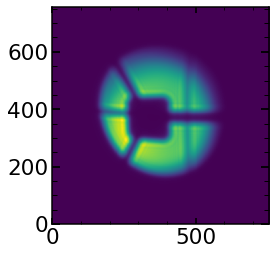

In [73]:
optPsf_cut_grating_convolved=np.load('/Users/nevencaplar/Documents/PFS/Testing/Final_Images/optPsf_cut_grating_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load('/Users/nevencaplar/Documents/PFS/Testing/Final_Images/optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_fiber_convolved=np.load('/Users/nevencaplar/Documents/PFS/Testing/Final_Images/optPsf_cut_fiber_convolved.npy')
pixel_gauss_padded=np.load('/Users/nevencaplar/Documents/PFS/Testing/Final_Images/pixel_gauss_padded.npy')
plt.imshow(optPsf_cut_fiber_convolved)

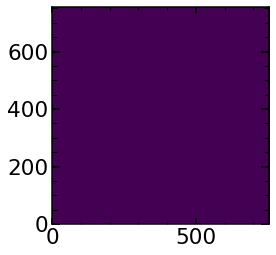

In [71]:
plt.imshow(pixel_gauss_padded)

In [72]:
np.sum(pixel_gauss_padded)

0.0

In [78]:
swarm0=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/swarm0.npy',allow_pickle=True)
swarm1=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/swarm1.npy',allow_pickle=True)
swarm2=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/swarm2.npy',allow_pickle=True)
swarm3=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/swarm3.npy',allow_pickle=True)

In [88]:
swarm_likelihood=swarm0[:,0]

index_of_best=np.arange(len(swarm_likelihood))[swarm_likelihood==np.max(swarm_likelihood)][0]
best_particle_this_step=swarm0[index_of_best]
print(best_particle_this_step[1][-3])
best_particle_this_step

0.37175131


array([-3418.813725436272,
       array([   -7.48065204,     0.75761329,     0.19909601,     0.1882954 ,
           0.03456669,    -0.00108643,    -0.0353142 ,     0.38719725,
           0.02200749,     0.56861922,     0.00555678,     0.12478656,
           0.01194986,    -0.25525182,    -0.01992819,    -0.06043928,
           0.00719616,    -0.15200679,     0.00097902,    -0.10360443,
           0.02729911,    -0.00710428,     0.00659581,     0.03546763,
           0.01417652,    -0.0206327 ,    -0.01904899,     0.04223927,
          -0.00106704,     0.02026218,    -0.00908736,     0.01847032,
          -0.00288765,    -0.02254508,     0.0051569 ,     0.01803494,
          -0.00664588,     0.03568946,     0.68904049,     0.10290975,
          -0.20154677,    -0.01441376,     0.05355728,     0.05813265,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
           0.02461952,    -0.05835101,     0.93393462,     0.04867201,
           0.49904901,     1.01173008,     

In [89]:
swarm_likelihood=swarm1[:,0]

index_of_best=np.arange(len(swarm_likelihood))[swarm_likelihood==np.max(swarm_likelihood)][0]
best_particle_this_step=swarm1[index_of_best]
print(best_particle_this_step[1][-3])
best_particle_this_step

0.37175131


array([-3416.908162632038,
       array([   -7.48063609,     0.75987848,     0.19971831,     0.1870262 ,
           0.03467897,    -0.0042252 ,    -0.03503376,     0.38751664,
           0.02112747,     0.57270192,     0.00549606,     0.12442856,
           0.01181784,    -0.2541583 ,    -0.01966617,    -0.06098305,
           0.00715579,    -0.15262148,     0.00078086,    -0.10361311,
           0.02741672,    -0.00700328,     0.00662621,     0.03560331,
           0.01437585,    -0.02178574,    -0.01905526,     0.04285056,
          -0.00092415,     0.01997524,    -0.00904856,     0.0180409 ,
          -0.00287769,    -0.02283201,     0.00520139,     0.01837806,
          -0.00671846,     0.0377778 ,     0.68904049,     0.10290975,
          -0.20154677,    -0.01441376,     0.05355728,     0.05813265,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
           0.02461952,    -0.05835101,     0.93393462,     0.04867201,
           0.49904901,     1.01173008,     

In [90]:
swarm_likelihood=swarm2[:,0]

index_of_best=np.arange(len(swarm_likelihood))[swarm_likelihood==np.max(swarm_likelihood)][0]
best_particle_this_step=swarm2[index_of_best]
print(best_particle_this_step[1][-3])
best_particle_this_step

0.37175131


array([-3416.747905283494,
       array([   -7.48062252,     0.76041583,     0.1998481 ,     0.18643205,
           0.03472024,    -0.00468244,    -0.03507337,     0.38750626,
           0.02085495,     0.57429856,     0.0054901 ,     0.12434296,
           0.01173116,    -0.25351359,    -0.01959072,    -0.06149861,
           0.0071549 ,    -0.15268852,     0.00076829,    -0.1036636 ,
           0.02743168,    -0.00692209,     0.00659609,     0.03570186,
           0.01444154,    -0.02214043,    -0.01906407,     0.04302365,
          -0.00090574,     0.01996816,    -0.00902618,     0.01798609,
          -0.00286246,    -0.02297245,     0.00520559,     0.01838573,
          -0.00678531,     0.03723291,     0.68904049,     0.10290975,
          -0.20154677,    -0.01441376,     0.05355728,     0.05813265,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
           0.02461952,    -0.05835101,     0.93393462,     0.04867201,
           0.49904901,     1.01173008,     

In [91]:
swarm_likelihood=swarm3[:,0]

index_of_best=np.arange(len(swarm_likelihood))[swarm_likelihood==np.max(swarm_likelihood)][0]
best_particle_this_step=swarm3[index_of_best]
print(best_particle_this_step[1][-3])
best_particle_this_step

-0.032193363027714916


array([-1416.697998046875,
       array([   -7.4791677 ,     0.72777321,     0.19308277,     0.05966006,
           0.03062985,    -0.04134412,    -0.03403011,     0.39088906,
           0.01343311,     0.56053797,     0.00434165,     0.07746895,
          -0.00032642,    -0.27453555,    -0.01935465,    -0.04854302,
           0.00482984,    -0.12693675,     0.00160086,    -0.09567376,
           0.02742099,    -0.02359497,     0.00632401,     0.03839515,
           0.01465061,    -0.02234004,    -0.01929696,     0.03901043,
           0.00033203,     0.02688605,    -0.00925635,     0.01857523,
          -0.00563865,    -0.0364417 ,     0.00450307,     0.02075072,
          -0.00763114,     0.0538397 ,     0.68244668,     0.10603612,
          -0.19840056,    -0.04860292,     0.04665893,     0.04263506,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
          -0.14242459,    -0.05447488,     0.97780678,     0.08430799,
           0.30853302,     1.00576373,     

In [94]:
swarm3[swarm3[:,0]==-1416.697998046875]

array([[-1416.697998046875,
        array([   -7.4791677 ,     0.72777321,     0.19308277,     0.05966006,
           0.03062985,    -0.04134412,    -0.03403011,     0.39088906,
           0.01343311,     0.56053797,     0.00434165,     0.07746895,
          -0.00032642,    -0.27453555,    -0.01935465,    -0.04854302,
           0.00482984,    -0.12693675,     0.00160086,    -0.09567376,
           0.02742099,    -0.02359497,     0.00632401,     0.03839515,
           0.01465061,    -0.02234004,    -0.01929696,     0.03901043,
           0.00033203,     0.02688605,    -0.00925635,     0.01857523,
          -0.00563865,    -0.0364417 ,     0.00450307,     0.02075072,
          -0.00763114,     0.0538397 ,     0.68244668,     0.10603612,
          -0.19840056,    -0.04860292,     0.04665893,     0.04263506,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
          -0.14242459,    -0.05447488,     0.97780678,     0.08430799,
           0.30853302,     1.00576373,   

In [98]:
np.array(swarm2[:,1])

array([array([   -7.48062252,     0.76041583,     0.1998481 ,     0.18643205,
           0.03472024,    -0.00468244,    -0.03507337,     0.38750626,
           0.02085495,     0.57429856,     0.0054901 ,     0.12434296,
           0.01173116,    -0.25351359,    -0.01959072,    -0.06149861,
           0.0071549 ,    -0.15268852,     0.00076829,    -0.1036636 ,
           0.02743168,    -0.00692209,     0.00659609,     0.03570186,
           0.01444154,    -0.02214043,    -0.01906407,     0.04302365,
          -0.00090574,     0.01996816,    -0.00902618,     0.01798609,
          -0.00286246,    -0.02297245,     0.00520559,     0.01838573,
          -0.00678531,     0.03723291,     0.68904049,     0.10290975,
          -0.20154677,    -0.01441376,     0.05355728,     0.05813265,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
           0.02461952,    -0.05835101,     0.93393462,     0.04867201,
           0.49904901,     1.01173008,     0.63182418, 51347.90306188,

In [109]:
swarm3[11]

array([-1416.697998046875,
       array([   -7.4791677 ,     0.72777321,     0.19308277,     0.05966006,
           0.03062985,    -0.04134412,    -0.03403011,     0.39088906,
           0.01343311,     0.56053797,     0.00434165,     0.07746895,
          -0.00032642,    -0.27453555,    -0.01935465,    -0.04854302,
           0.00482984,    -0.12693675,     0.00160086,    -0.09567376,
           0.02742099,    -0.02359497,     0.00632401,     0.03839515,
           0.01465061,    -0.02234004,    -0.01929696,     0.03901043,
           0.00033203,     0.02688605,    -0.00925635,     0.01857523,
          -0.00563865,    -0.0364417 ,     0.00450307,     0.02075072,
          -0.00763114,     0.0538397 ,     0.68244668,     0.10603612,
          -0.19840056,    -0.04860292,     0.04665893,     0.04263506,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
          -0.14242459,    -0.05447488,     0.97780678,     0.08430799,
           0.30853302,     1.00576373,     

In [110]:
swarm2[11]

array([-7606.841073245449,
       array([   -7.48551385,     0.66604565,     0.18031651,     0.0360451 ,
           0.02471149,    -0.21146187,    -0.03145465,     0.3455865 ,
           0.01288084,     0.53888383,     0.00640498,     0.07453102,
          -0.00222863,    -0.34084014,    -0.01303449,    -0.04469565,
           0.00582816,    -0.1230388 ,     0.00516063,    -0.08893917,
           0.02574748,    -0.03856323,     0.00272952,     0.0081017 ,
           0.01519738,    -0.01051206,    -0.01599792,     0.03198803,
           0.00079312,     0.02837122,    -0.01047808,     0.01886111,
          -0.00379608,    -0.03737038,     0.00347517,    -0.00526653,
          -0.00861809,     0.05196138,     0.68347707,     0.10302483,
          -0.21192708,    -0.04412433,     0.05189517,     0.05250352,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
           0.00268171,    -0.05540478,     0.93901308,     0.05719821,
           0.3786577 ,     1.00581501,     

In [137]:
best_particle2=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/best_particle2.npy',allow_pickle=True)
best_particle1=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/best_particle1.npy',allow_pickle=True)

In [138]:
best_particle_position=best_particle1[1]

In [139]:
paramCount=len(best_particle_position)

c1=1.193
c2=1.193
particle_position=swarm1[11][1]
particle_velocity=swarm1[11][2]
w = 0.5 + np.random.uniform(0,1,size=paramCount)/2
#w=0.72
part_vel = w * particle_velocity
#cog_vel = c1 * numpy.random.uniform(0,1,size=paramCount) * (particle.pbest.position - particle.position)
cog_vel = c1 * np.random.uniform(0,1,size=paramCount) * (particle_position - particle_position)    

soc_vel = c2 * np.random.uniform(0,1,size=paramCount) * (best_particle_position - particle_position)

particle_velocity = part_vel + cog_vel + soc_vel

particle_velocity

array([     0.00199413,      0.01331917,      0.00305679,      0.0175825 ,
           -0.00086814,     -0.01682877,      0.00155651,     -0.00214147,
           -0.00438487,      0.01733948,     -0.00168268,     -0.00137979,
            0.00056945,      0.00438729,     -0.00054868,     -0.00753575,
           -0.00313159,      0.00027372,     -0.00204215,      0.0007057 ,
            0.00017446,      0.00512479,      0.00088673,     -0.00119693,
           -0.00011531,      0.00134453,     -0.00008033,      0.00152086,
            0.00060526,     -0.0008774 ,      0.00002593,     -0.0005657 ,
           -0.00141392,      0.0003123 ,      0.00056706,      0.00445934,
           -0.00040248,     -0.07679262,     -0.00915075,      0.00067947,
            0.03268699,     -0.04164307,     -0.00774614,     -0.01028658,
            0.        ,      0.        ,      0.        ,      0.        ,
           -0.08821161,      0.00355539,      0.07785334,      0.03310196,
           -0.17329939,  

In [141]:
best_particle_position

array([   -7.48068093,     0.76024892,     0.19980591,     0.18628906,
           0.03467383,    -0.00432241,    -0.03503238,     0.38722567,
           0.02094488,     0.57407793,     0.0054795 ,     0.12435297,
           0.0117702 ,    -0.25357317,    -0.01963523,    -0.06162783,
           0.00716231,    -0.15260105,     0.00076238,    -0.10359061,
           0.02744382,    -0.00686257,     0.00660753,     0.03564495,
           0.0144195 ,    -0.02205208,    -0.01906375,     0.04299673,
          -0.00090296,     0.01995107,    -0.00903921,     0.01797794,
          -0.002875  ,    -0.02301601,     0.00519982,     0.01837632,
          -0.00677344,     0.03677692,     0.68904049,     0.10290975,
          -0.20154677,    -0.01441376,     0.05355728,     0.05813265,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
           0.02461952,    -0.05835101,     0.93393462,     0.04867201,
           0.49904901,     1.01173008,     0.63182418, 51347.90306188,
      

In [142]:
particle_position

array([   -7.4856319 ,     0.74818965,     0.19723261,     0.18927432,
           0.03717091,     0.00107584,    -0.03497953,     0.38980599,
           0.02328099,     0.55973108,     0.00548934,     0.12522487,
           0.011124  ,    -0.25637241,    -0.01920406,    -0.05372935,
           0.00663409,    -0.1528817 ,     0.00247206,    -0.1041481 ,
           0.02731343,    -0.01044283,     0.00508414,     0.03574194,
           0.01417157,    -0.02032482,    -0.01891087,     0.03889802,
          -0.00150487,     0.02022999,    -0.00908439,     0.01944453,
          -0.00167807,    -0.02361406,     0.00522863,     0.01658665,
          -0.00663913,     0.10912229,     0.69039773,     0.09868425,
          -0.23058666,    -0.01234672,     0.06025267,     0.06387512,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
           0.21881326,    -0.05963458,     0.88102844,     0.02213669,
           0.59483714,     1.01131715,     0.71187699, 95214.41106653,
      

In [145]:
particle_position=swarm0[11][1]
particle_position

array([    -7.48584024,      0.73497698,      0.19568978,      0.15682353,
            0.03769565,      0.02577918,     -0.03734586,      0.39183789,
            0.02550665,      0.556507  ,      0.0072312 ,      0.1261021 ,
            0.01097693,     -0.26493479,     -0.01831573,     -0.05247759,
            0.01020252,     -0.15314955,      0.00343817,     -0.10475206,
            0.02711867,     -0.0137685 ,      0.00445374,      0.0372618 ,
            0.01458828,     -0.02237409,     -0.01880653,      0.03841714,
           -0.00188257,      0.02112357,     -0.00910924,      0.01975998,
           -0.00067647,     -0.02366152,      0.00463751,      0.012873  ,
           -0.00621102,      0.06599903,      0.70020542,      0.09824526,
           -0.25718098,      0.02746428,      0.06400937,      0.07121174,
            0.0000314 ,      0.0000314 ,      0.9767313 ,      0.94836248,
            0.26558014,     -0.06334094,      0.83196925,      0.01667766,
            0.75502159,  

In [223]:
best_particle_this_step0=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/best_particle_this_step0.npy',allow_pickle=True)
best_particle_this_step1=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/best_particle_this_step1.npy',allow_pickle=True)
best_particle_this_step2=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/best_particle_this_step2.npy',allow_pickle=True)
best_particle_this_step3=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/best_particle_this_step3.npy',allow_pickle=True)
best_particle_this_step4=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/best_particle_this_step4.npy',allow_pickle=True)

best_particle0=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/best_particle0.npy',allow_pickle=True)
best_particle1=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/best_particle1.npy',allow_pickle=True)
best_particle2=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/best_particle2.npy',allow_pickle=True)

swarm0=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/swarm0.npy',allow_pickle=True)
swarm1=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/swarm1.npy',allow_pickle=True)
swarm2=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/swarm2.npy',allow_pickle=True)
swarm3=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/swarm3.npy',allow_pickle=True)

In [191]:
v_chains=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/chainNov0420_Single_P_2144836HgArvelocity_Swarm1.npy',allow_pickle=True)
chains=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/chainNov0420_Single_P_2144836HgArSwarm1.npy',allow_pickle=True)
ln_chains=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov0420/likechainNov0420_Single_P_2144836HgArSwarm1.npy',allow_pickle=True)

In [248]:
c1=1.193
c2=1.193

particle_position=swarm0[particle][1]
particle_pre_velocity=swarm0[particle][2]

best_particle_position=best_particle0[1]

w=0.72
part_vel = w * particle_pre_velocity
#cog_vel = c1 * numpy.random.uniform(0,1,size=paramCount) * (particle.pbest.position - particle.position)   
cog_vel = c1 * np.random.uniform(0,1,size=paramCount) * (particle_position - particle_position)         

#soc_vel = c2 * np.random.uniform(0,1,size=paramCount) * (best_particle_position - particle_position)
soc_vel = c2 * w * (best_particle_position - particle_position)

particle_velocity = part_vel + cog_vel + soc_vel
particle_velocity

array([   0.00681252,    0.11767112,    0.00857698,    0.19239933,
          0.01572046,    0.22443406,    0.00122248,    0.04755185,
          0.00012301,    0.04851306,   -0.00069565,    0.0597798 ,
          0.0065513 ,    0.11089802,   -0.00441804,   -0.01804608,
         -0.0021107 ,   -0.03232948,   -0.00207066,   -0.01792231,
          0.00022233,    0.03847851,    0.00097212,    0.03511529,
          0.00070988,   -0.01266237,   -0.00162114,    0.0105911 ,
         -0.00041349,   -0.00915051,    0.00105407,   -0.00086444,
          0.00043614,    0.01474547,    0.00151012,    0.03163721,
          0.0002574 ,    0.05627659,    0.04165946,    0.00938216,
         -0.06771357,    0.04950873,   -0.0208584 ,   -0.03680381,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.27771173,    0.23942043,   -0.00539997,   -0.04537727,
         -0.03469803,    0.00748123,    0.04676191, 6981.54725373,
         -0.34345679,   -0.01172802,   -0.13211187,   -0.13460

In [239]:
particle_post_positions=swarm1[particle][1]
particle_post_velocity=swarm1[particle][2]

In [251]:
particle_post_positions-(particle_position+particle_post_velocity)

array([-0.01257557, -0.10094544, -0.01102573, -0.17385169, -0.02072031,
       -0.2089647 , -0.00967942, -0.04280281, -0.01310132, -0.0354462 ,
        0.00197595, -0.05517333, -0.00742206, -0.09798259,  0.00841343,
        0.01586205,  0.00384388,  0.02975779,  0.00250737,  0.01725471,
       -0.00038284, -0.03476125, -0.00158433, -0.03056913,  0.00060966,
        0.0095092 ,  0.00487967, -0.00896859,  0.00034184,  0.00812022,
       -0.00131842, -0.00088909, -0.00097016, -0.01357097, -0.00134584,
       -0.02816598,  0.00082485, -0.02508914,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [246]:
particle_post_velocity

array([   0.00681252,    0.11767112,    0.00857698,    0.19239933,
          0.01572046,    0.22443406,    0.00122248,    0.04755185,
          0.00012301,    0.04851306,   -0.00069565,    0.0597798 ,
          0.0065513 ,    0.11089802,   -0.00441804,   -0.01804608,
         -0.0021107 ,   -0.03232948,   -0.00207066,   -0.01792231,
          0.00022233,    0.03847851,    0.00097212,    0.03511529,
          0.00070988,   -0.01266237,   -0.00162114,    0.0105911 ,
         -0.00041349,   -0.00915051,    0.00105407,   -0.00086444,
          0.00043614,    0.01474547,    0.00151012,    0.03163721,
          0.0002574 ,    0.05627659,    0.04165946,    0.00938216,
         -0.06771357,    0.04950873,   -0.0208584 ,   -0.03680381,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.27771173,    0.23942043,   -0.00539997,   -0.04537727,
         -0.03469803,    0.00748123,    0.04676191, 6981.54725373,
         -0.34345679,   -0.01172802,   -0.13211187,   -0.13460

In [166]:
v_chains[0]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00445258,  0.01943807,  0.00291597, ..., -0.20272907,
        -0.131018  ,  0.00531643],
       [ 0.00898667,  0.1328968 ,  0.01342576, ..., -0.46235492,
        -0.10430459,  0.01698908],
       ...,
       [ 0.0038775 ,  0.28679421,  0.02737356, ..., -0.37091103,
        -0.26519139, -0.00703797],
       [ 0.00724438,  0.2259299 ,  0.02262493, ..., -0.52190554,
        -0.19845026, -0.0030092 ],
       [ 0.00966853,  0.18210759,  0.01920592, ..., -0.37123646,
        -0.16798628, -0.0038105 ]])

In [176]:
# positions at start of 1
chains[1]

array([[-7.48061527,  0.75988235,  0.19970703, ...,  0.37175131,
         1.79411345,  0.99627532],
       [-7.497262  ,  0.65867365,  0.19737728, ...,  0.40503913,
         1.81562642,  0.99540237],
       [-7.4783999 ,  0.75207872,  0.19932429, ...,  0.27773716,
         1.70141782,  0.99794209],
       ...,
       [-7.46749189,  0.90993808,  0.21273464, ...,  0.23256275,
         1.57044435,  0.98452414],
       [-7.47859586,  0.96090688,  0.21831471, ...,  0.14654131,
         1.60440919,  0.99087004],
       [-7.47617171,  0.91708457,  0.2148957 , ..., -0.00476541,
         1.65535099,  0.99437862]])

In [175]:
v_chains[1]

array([[ 0.00690467,  0.13141599,  0.01390214, ..., -0.26729025,
        -0.12095012, -0.00274356],
       [ 0.01921357,  0.18185226,  0.01208458, ..., -0.22104189,
        -0.10556287, -0.00122554],
       [ 0.0118742 ,  0.13793515,  0.00910353, ..., -0.07839576,
         0.00361658, -0.00231408],
       ...,
       [-0.03576088, -0.27708495, -0.02857519, ...,  0.73866152,
         0.52098388,  0.01044116],
       [-0.02753909, -0.37187467, -0.03648352, ...,  0.72528268,
         0.53805677,  0.01216056],
       [-0.02370165, -0.40248166, -0.03924071, ...,  0.84561633,
         0.50659227,  0.01038479]])

-9999999.0

In [215]:
particle=1

print(ln_chains[1][particle])

particle_velocity=v_chains[0][particle]

particle_position=chains[1][particle]
best_particle_position=best_particle1[1]

w=0.72
part_vel = w * particle_velocity

soc_vel = c2 * w * (best_particle_position - particle_position)

particle_velocity = part_vel + cog_vel + soc_vel

-6976.112304837781


In [222]:
 c2 * w

0.8589600000000001

In [216]:
# particle velocity at step 0
v_chains[0][particle]

array([    0.00445258,     0.01943807,     0.00291597,     0.02701545,
          -0.0026815 ,    -0.02307483,     0.0017353 ,    -0.00398582,
          -0.00301952,     0.01042268,    -0.00143876,    -0.00112737,
           0.00082842,     0.00832051,    -0.00138098,    -0.006842  ,
          -0.00258423,     0.00098183,    -0.00210798,     0.00098562,
           0.00015469,     0.00572423,     0.00183645,    -0.00153832,
          -0.0003502 ,     0.00148958,    -0.00020584,     0.00328282,
           0.0007005 ,    -0.00073855,     0.00001841,    -0.00110898,
          -0.00189811,     0.0009566 ,     0.0004454 ,     0.00443397,
          -0.00037604,     0.03165181,     0.05761279,    -0.00947341,
           0.13571144,    -0.06177136,    -0.01845073,     0.02260487,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.00115144,     0.15760453,     0.00279705,    -0.04356328,
           0.08391385,    -0.05128959,     0.2832398 , 14275.73605298,
      

In [217]:
particle_velocity

array([    0.01744806,     0.10122816,     0.00417453,     0.16596551,
          -0.00728802,     0.15268901,     0.0088835 ,     0.03126577,
           0.00013794,     0.04458131,    -0.0000247 ,     0.04762247,
           0.00607888,     0.09122245,    -0.00715682,    -0.02040552,
          -0.00185108,    -0.02232955,    -0.0022355 ,    -0.01236141,
           0.00055391,     0.03390057,     0.00155591,     0.02524331,
          -0.0019476 ,    -0.00820951,    -0.00124428,     0.00854797,
           0.00000166,    -0.00813493,     0.00011196,    -0.00178275,
          -0.00299719,     0.0123263 ,     0.00128762,     0.0275435 ,
           0.00182868,    -0.0021106 ,     0.04960691,    -0.00815699,
           0.11685298,    -0.05318761,    -0.01588682,     0.0194637 ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.00099144,     0.13570381,     0.00240837,    -0.03750972,
           0.07225318,    -0.04416239,     0.24388079, 12291.97977105,
      

In [218]:
v_chains[1][particle]

array([     0.01921357,      0.18185226,      0.01208458,      0.29254685,
            0.00272067,      0.27392812,      0.00870984,      0.05753859,
            0.00044598,      0.07949102,     -0.00054923,      0.08261995,
            0.00846055,      0.16186314,     -0.00985866,     -0.03510878,
           -0.00472022,     -0.04136306,     -0.00412296,     -0.02253678,
            0.00153234,      0.05982467,      0.00307226,      0.04532163,
           -0.00184181,     -0.01500007,     -0.00299832,      0.01696108,
            0.00034985,     -0.01384198,      0.0003509 ,     -0.00281792,
           -0.00388338,      0.02121208,      0.00249682,      0.04876676,
            0.00034152,      0.01811597,     -0.04605518,      0.006273  ,
           -0.03558439,     -0.10507485,     -0.02921011,      0.03284422,
            0.        ,      0.        ,      0.        ,      0.        ,
           -0.01266087,     -0.04929292,      0.06208938,     -0.10150408,
            0.11481625,  

In [208]:
swarm1[particle]

array([-6976.112304837781,
       array([   -7.497262  ,     0.65867365,     0.19737728,     0.01576166,
           0.04091576,    -0.20138051,    -0.04392515,     0.34750491,
           0.01824875,     0.53085974,     0.00429696,     0.06797809,
           0.00538121,    -0.35280761,    -0.01245901,    -0.04360144,
           0.00714951,    -0.12577458,     0.00160174,    -0.08837552,
           0.02692829,    -0.04152649,     0.00633565,     0.00498073,
           0.01639358,    -0.01123557,    -0.01778395,     0.0357791 ,
          -0.00031943,     0.02880499,    -0.00915544,     0.01912648,
          -0.00097671,    -0.03656238,     0.00407423,    -0.00996837,
          -0.00921742,     0.065752  ,     0.67958055,     0.10446527,
          -0.22383039,    -0.00427099,     0.05658686,     0.05442096,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
           0.02443045,    -0.08422945,     0.93347535,     0.05582504,
           0.48527048,     1.02015176,     

In [210]:
chains[1][particle]

array([   -7.497262  ,     0.65867365,     0.19737728,     0.01576166,
           0.04091576,    -0.20138051,    -0.04392515,     0.34750491,
           0.01824875,     0.53085974,     0.00429696,     0.06797809,
           0.00538121,    -0.35280761,    -0.01245901,    -0.04360144,
           0.00714951,    -0.12577458,     0.00160174,    -0.08837552,
           0.02692829,    -0.04152649,     0.00633565,     0.00498073,
           0.01639358,    -0.01123557,    -0.01778395,     0.0357791 ,
          -0.00031943,     0.02880499,    -0.00915544,     0.01912648,
          -0.00097671,    -0.03656238,     0.00407423,    -0.00996837,
          -0.00921742,     0.065752  ,     0.67958055,     0.10446527,
          -0.22383039,    -0.00427099,     0.05658686,     0.05442096,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
           0.02443045,    -0.08422945,     0.93347535,     0.05582504,
           0.48527048,     1.02015176,     0.58531661, 49003.84767756,
      

In [252]:
num_iter='m1'
if num_iter!=None:
    print('do it')

do it


# checking the algorithm 

## Tokovinin 

In [396]:
H=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_2/H_1_0.npy')
H_std=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_2/H_std_1_0.npy')
uber_I=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_2/uber_I_1.npy')
uber_M0=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_2/uber_M0_1_0.npy')
uber_std=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_2/uber_std_1.npy')

allparameters_parametrization_proposal_after_iteration_previous=\
np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_2/allparameters_parametrization_proposal_after_iteration_0_0.npy')

allparameters_parametrization_proposal_after_iteration=\
np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_2/allparameters_parametrization_proposal_after_iteration_1_0.npy')
list_of_image_0=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_2/list_of_image_0_1_0.npy',allow_pickle=True)
list_of_image_final=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_2/list_of_image_final_1_0.npy',allow_pickle=True)

initial_input_parameterization=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_2/initial_input_parameterization_1_0.npy')

list_of_sci_images=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_2/list_of_sci_images_1.npy',allow_pickle=True)


first_proposal_Tokovnin_std_2=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_2/first_proposal_Tokovnin_std1_0.npy',allow_pickle=True)
first_proposal_Tokovnin_std_4=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_4/first_proposal_Tokovnin_std1_0.npy',allow_pickle=True)

array_of_delta_z_parametrizations_2=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_2/array_of_delta_z_parametrizations_1_0.npy')
array_of_delta_z_parametrizations_4=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_4/array_of_delta_z_parametrizations_1_0.npy')

uber_list_of_input_parameters_2=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_2/uber_list_of_input_parameters_1_0.npy')
uber_list_of_input_parameters_4=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_4/uber_list_of_input_parameters_1_0.npy')

H.shape

(11972, 106)

In [405]:
np.median(np.abs(array_of_delta_z_parametrizations_2/first_proposal_Tokovnin_std_2))

1414.5983519306483

In [403]:
np.median(np.abs(array_of_delta_z_parametrizations_4/first_proposal_Tokovnin_std_4))

193.36900979335877

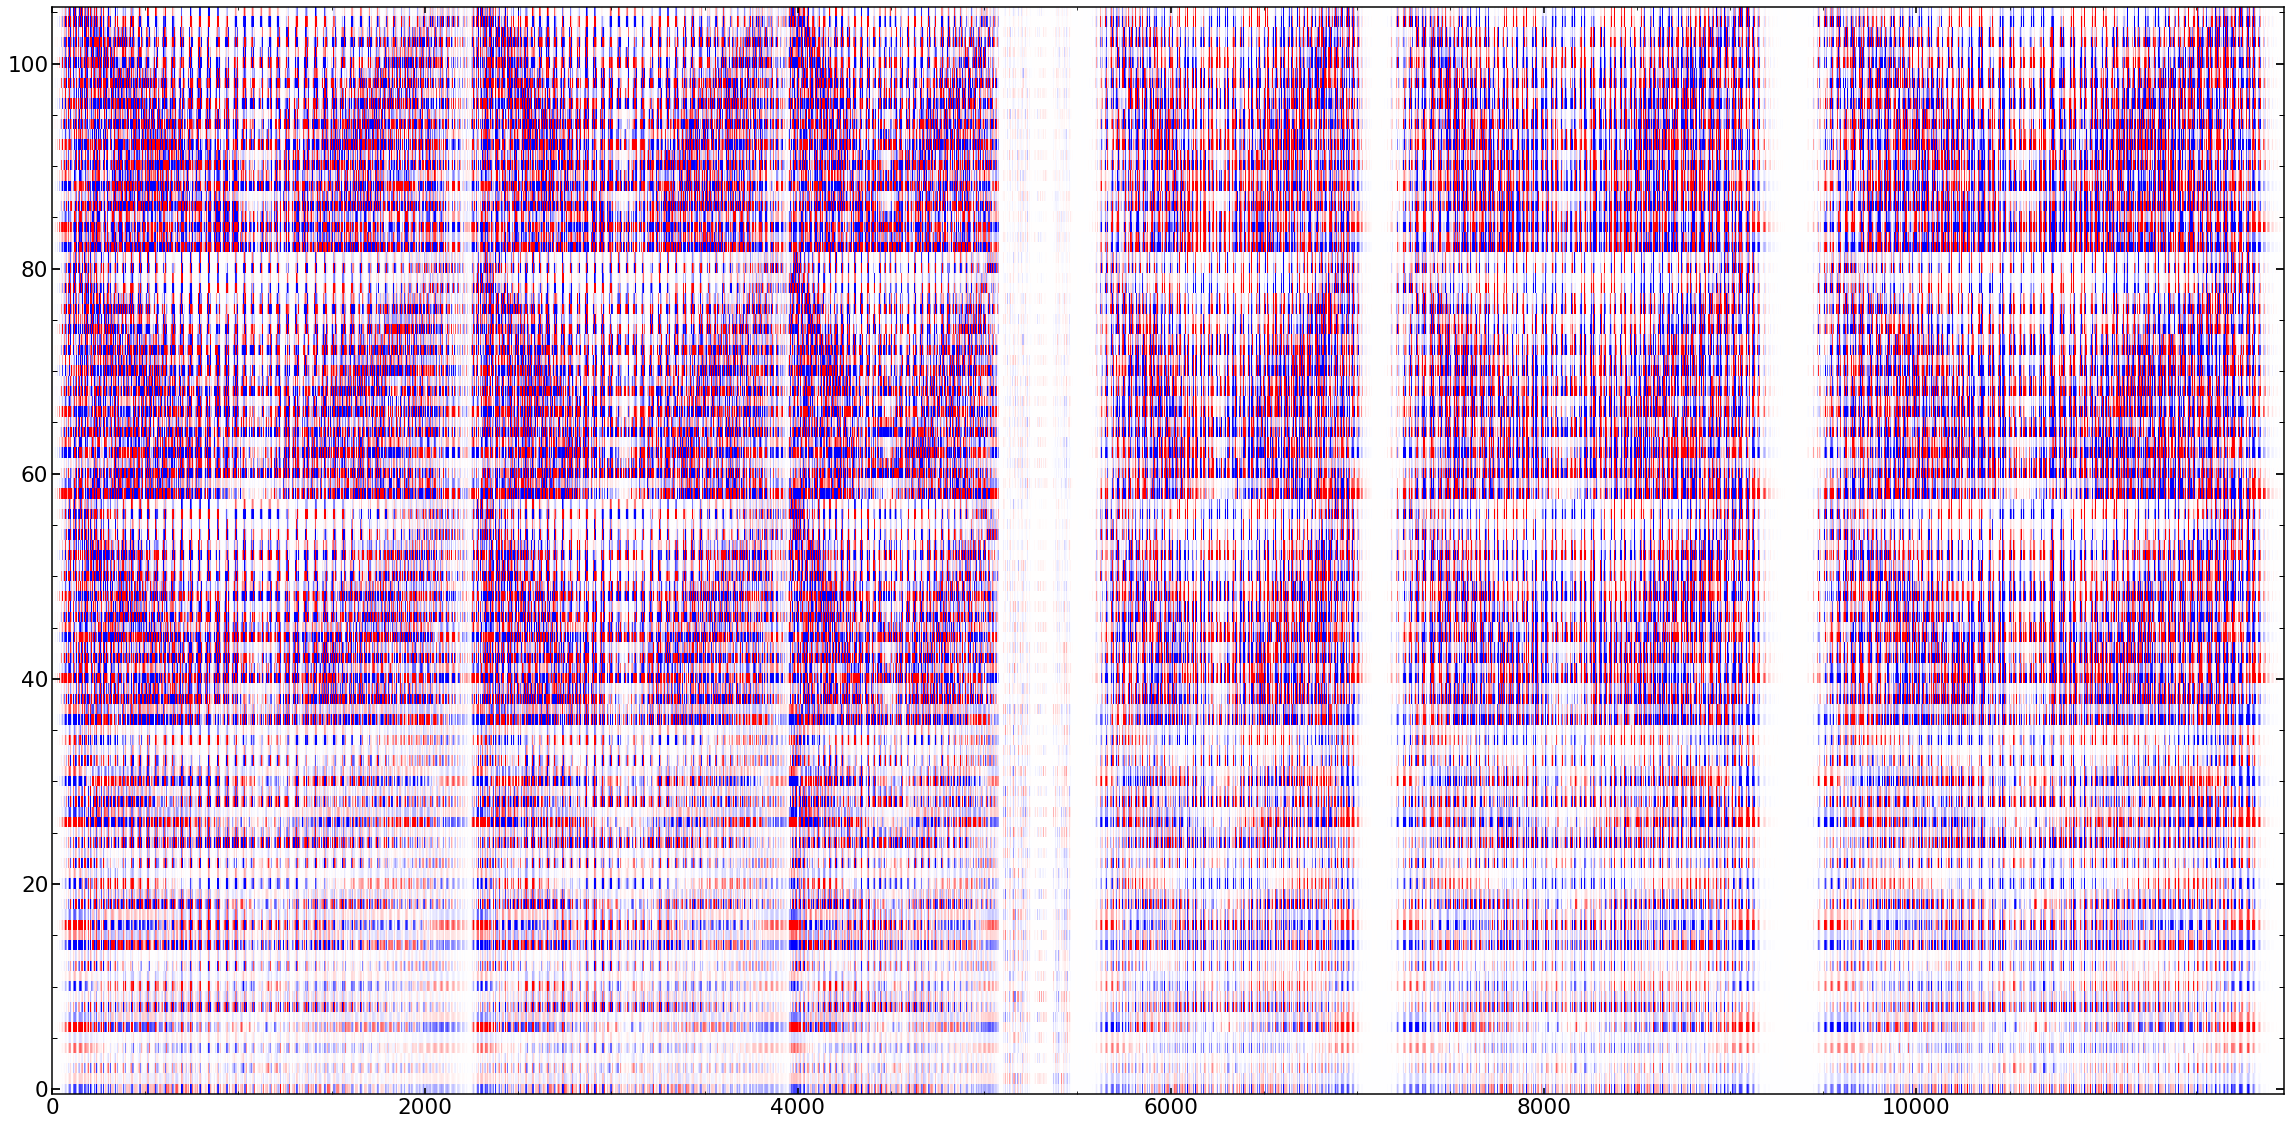

In [384]:
plt.figure(figsize=(40,20))
plt.imshow(np.transpose(H_std),cmap='bwr', aspect='auto',vmax=100,vmin=-100)

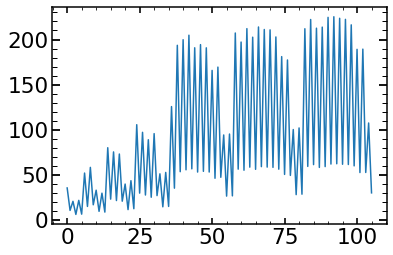

In [385]:
plt.plot(np.std(np.transpose(H_std),axis=1))

In [386]:
np.transpose(np.array([np.arange(0,108),np.std(np.transpose(H_std),axis=1)]))

array([array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107]),
       array([ 35.42990142,  10.53904959,  20.60567038,   6.09171735,
        21.67192325,   6.38955743,  51.94820213,  14.93732279,
        58.2517231 ,  16.78009927,  32.93240204,   9.50264305,
        29.64535281,   8.66099753,  80.04394267,  23.03216214,
        75.38497358,  21.46808612,  73.04821212,  20.76010737,
        39.73919342,  11.42625056,  43.4866945 ,  12.40558533,
   

In [387]:
step=17
list_of_singlular_parameters=[]
for step in range(20):
    H=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_2/H_'+str(step)+'_0.npy')
    singlular_parameters=np.arange(H.shape[1])[np.abs((np.mean(H,axis=0)))<0.01]
    non_singlular_parameters=np.arange(H.shape[1])[np.abs((np.mean(H,axis=0)))>0.01]
    list_of_singlular_parameters.append(singlular_parameters)

In [388]:
list_of_singlular_parameters

[array([35]),
 array([35]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([80]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([80]),
 array([], dtype=int64),
 array([80]),
 array([], dtype=int64),
 array([80]),
 array([35])]

In [389]:
HHt=np.matmul(np.transpose(H),H)
invHHt=np.linalg.inv(HHt)  
invHHtHt=np.matmul(invHHt,np.transpose(H))
first_proposal_Tokovnin=np.matmul(invHHtHt,uber_I-uber_M0)
if len(singlular_parameters)>0:
    for i in range(len(singlular_parameters)):
        first_proposal_Tokovnin=np.insert(first_proposal_Tokovnin,singlular_parameters[i],0)
        
#all_wavefront_z_parametrization_new=np.copy(all_wavefront_z_parametrization_old)
#all_wavefront_z_parametrization_new=all_wavefront_z_parametrization_new+Tokovnin_proposal
#up_to_z22_end=all_wavefront_z_parametrization_new[:19*2]
#from_z22_end=all_wavefront_z_parametrization_new[19*2:]
#allparameters_parametrization_proposal_after_iteration=np.concatenate((up_to_z22_end,nonwavefront_par,from_z22_end))

allparameters_parametrization_proposal_after_iteration

array([   -7.48074483,     0.73857976,     0.19693454,     0.17739246,
           0.03884171,    -0.00419576,    -0.03674335,     0.39030337,
           0.02329122,     0.56463125,     0.00557048,     0.13242414,
           0.01009117,    -0.25545718,    -0.02184837,    -0.05510234,
           0.00666271,    -0.14521028,     0.00215517,    -0.10774988,
           0.02860467,    -0.01133707,     0.0067213 ,     0.0414433 ,
           0.0145416 ,    -0.02251159,    -0.01823308,     0.03726454,
          -0.0009475 ,     0.01909885,    -0.00955235,     0.02017984,
          -0.00165279,    -0.02756967,     0.0040697 ,     0.01311077,
          -0.00553134,     0.028583  ,     0.68904049,     0.10290975,
          -0.20154677,    -0.01441376,     0.05355728,     0.05813265,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
           0.02461952,    -0.05835101,     0.93393462,     0.04867201,
           0.49904901,     1.01173008,     0.63182418, 51347.90306188,
      

In [390]:
initial_input_parameterization[:38]+first_proposal_Tokovnin_std[:38]

array([-7.48074483,  0.73857976,  0.19693454,  0.17739246,  0.03884171,
       -0.00419576, -0.03674335,  0.39030337,  0.02329122,  0.56463125,
        0.00557048,  0.13242414,  0.01009117, -0.25545718, -0.02184837,
       -0.05510234,  0.00666271, -0.14521028,  0.00215517, -0.10774988,
        0.02860467, -0.01133707,  0.0067213 ,  0.0414433 ,  0.0145416 ,
       -0.02251159, -0.01823308,  0.03726454, -0.0009475 ,  0.01909885,
       -0.00955235,  0.02017984, -0.00165279, -0.02756967,  0.0040697 ,
        0.01311077, -0.00553134,  0.028583  ])

In [391]:
allparameters_parametrization_proposal_after_iteration[:38]

array([-7.48074483,  0.73857976,  0.19693454,  0.17739246,  0.03884171,
       -0.00419576, -0.03674335,  0.39030337,  0.02329122,  0.56463125,
        0.00557048,  0.13242414,  0.01009117, -0.25545718, -0.02184837,
       -0.05510234,  0.00666271, -0.14521028,  0.00215517, -0.10774988,
        0.02860467, -0.01133707,  0.0067213 ,  0.0414433 ,  0.0145416 ,
       -0.02251159, -0.01823308,  0.03726454, -0.0009475 ,  0.01909885,
       -0.00955235,  0.02017984, -0.00165279, -0.02756967,  0.0040697 ,
        0.01311077, -0.00553134,  0.028583  ])

In [392]:
number_of_extra_zernike=56-22
list_of_delta_z_parametrizations=[]
for z_par in range(0,19*2+2*number_of_extra_zernike):
    z_par_i=z_par+4
    # if this is the parameter that change
    if np.mod(z_par_i,2)==0:
        list_of_delta_z_parametrizations.append(0.25*0.25/np.sqrt(z_par_i))
    if np.mod(z_par_i,2)==1:
        list_of_delta_z_parametrizations.append(0.25/np.sqrt(z_par_i))
        
array_of_delta_z_parametrizations=np.array(list_of_delta_z_parametrizations)

In [393]:
first_proposal_Tokovnin_std

array([-0.00008085,  0.00048294,  0.00013379,  0.00007903,  0.00007384,
       -0.00044013,  0.0000399 ,  0.00027108, -0.00026512,  0.00111153,
       -0.00003141,  0.00012735, -0.00012319,  0.0005258 ,  0.00004996,
       -0.00026817,  0.00002305, -0.0000512 , -0.00001363, -0.00015396,
        0.00000337,  0.00008063, -0.0000039 ,  0.00020305,  0.00006525,
       -0.00027658, -0.00002993,  0.00005055,  0.00000394,  0.00003977,
        0.00001585, -0.00004284,  0.00000697, -0.00008033,  0.00000323,
        0.        , -0.00005351,  0.00025291, -0.00000065,  0.00001041,
        0.00000449, -0.00000663,  0.00000209, -0.0000069 , -0.0000004 ,
        0.00000504,  0.0000046 , -0.00000122,  0.00000608, -0.00000652,
       -0.00000157, -0.000012  , -0.00000452,  0.0000054 , -0.0000007 ,
        0.00000361,  0.000006  , -0.00001221,  0.00000864, -0.00001082,
       -0.00000532,  0.00002747, -0.00000164,  0.00002097, -0.00001208,
        0.00003905,  0.00000072, -0.00000495,  0.00000029,  0.00

In [381]:
array_of_delta_z_parametrizations/first_proposal_Tokovnin_std

array([  -314.97031714,    224.22102905,    192.60985011,    996.17648077,
          277.02525678,   -207.1020936 ,    466.13782455,    271.85527271,
          -65.46703123,     62.58870167,   -494.52067905,    520.53489623,
         -125.78100461,    115.3733266 ,    290.13127963,   -209.48220667,
          686.01855159,  -1129.95324099,  -1198.12161143,   -320.1212393 ,
        -5316.84342117,    607.51669477,  -1712.0278649 ,    241.19387234,
          179.61628342,   -168.19302745,   -403.0521475 ,   1161.56003166,
         4498.17248302,   1193.79764421,    693.2047089 ,  -1103.93540651,
         1008.51624531,   -573.97236376,   2100.84569949,   3357.22825683,
         -160.71102505,    162.65044624,  -4618.69368988,   7012.07273654,
         3229.8942325 ,  -3708.51417143,   4048.97531401,  -4655.73938941,
        -6371.03951174, -49286.1852391 ,   2319.03493102,  68274.57024425,
         1813.41251207,  -3245.50732572,  -4735.47239478,  -2188.52556475,
        -1464.20673106,  

In [309]:
allparameters_parametrization_proposal_after_iteration-allparameters_parametrization_proposal_after_iteration_previous

array([-0.00002926,  0.00036253,  0.00013475,  0.00000264,  0.00006596,
       -0.00040095,  0.00001584,  0.00018675, -0.00020189,  0.00086645,
       -0.00000776, -0.00000999, -0.00007421,  0.00039804,  0.00004074,
       -0.00022119, -0.00000175, -0.00003079, -0.0000082 , -0.00009765,
       -0.00001903,  0.00004764,  0.00000503,  0.00013216,  0.00004597,
       -0.00021823, -0.00002635,  0.00002336, -0.00000183,  0.000028  ,
        0.00001029, -0.0000321 ,  0.00000968, -0.00008022, -0.00000435,
        0.        , -0.00004859,  0.00020054,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.00000081,  0.00000753, -0.00000017, -0.00001114,
       -0.0000007 , -0.00000291, -0.00000285,  0.00000335,  0.00

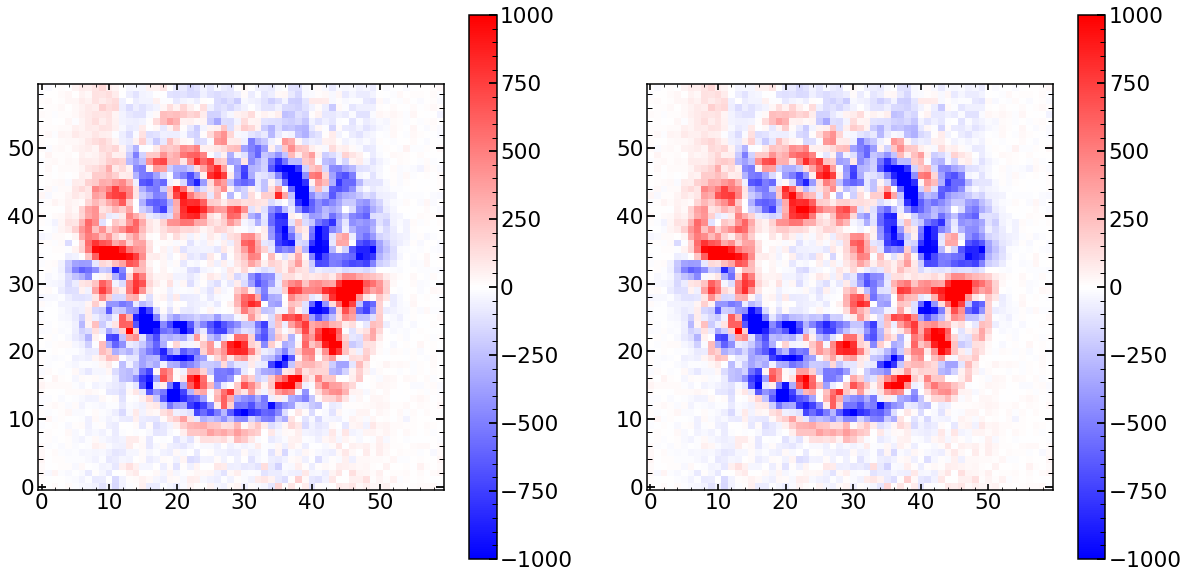

In [334]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(list_of_image_0[0]-list_of_sci_images[0],cmap='bwr',vmax=1000,vmin=-1000)
plt.colorbar()

plt.subplot(122)
plt.imshow(list_of_image_final[0]-list_of_sci_images[0],cmap='bwr',vmax=1000,vmin=-1000)
plt.colorbar()

In [317]:
array_of_delta_z_parametrizations_4

array([array([[ 5.9824886,  6.3814144,  6.7957206, ...,  6.3244734,  5.970785 ,
         5.6381817],
       [ 6.4036045,  6.839645 ,  7.294196 , ...,  6.776428 ,  6.3866534,
         6.0211782],
       [ 6.8432407,  7.319662 ,  7.81822  , ...,  7.2503247,  6.820771 ,
         6.419009 ],
       ...,
       [ 8.624733 ,  9.299497 , 10.023018 , ...,  8.486113 ,  7.9294553,
         7.414807 ],
       [ 8.064862 ,  8.674608 ,  9.324692 , ...,  7.9444876,  7.4401565,
         6.972205 ],
       [ 7.534456 ,  8.086577 ,  8.672771 , ...,  7.425625 ,  6.9689064,
         6.5438385]], dtype=float32),
       array([[ 7.7384815,  8.394864 ,  9.117614 , ..., 10.537255 ,  9.716592 ,
         8.992514 ],
       [ 8.353329 ,  9.082384 ,  9.887779 , ..., 11.510802 , 10.571805 ,
         9.747804 ],
       [ 9.001566 ,  9.811997 , 10.710803 , ..., 12.568336 , 11.490486 ,
        10.550653 ],
       ...,
       [ 8.983187 ,  9.810942 , 10.739962 , ..., 11.437538 , 10.481958 ,
         9.645002 ],
     

In [543]:
chains=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_7/chainNov0420_Single_P_2144836HgArSwarm1.npy')
likechains=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_7/likechainNov0420_Single_P_2144836HgArSwarm1.npy')
vchains=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_7/chainNov0420_Single_P_2144836HgArvelocity_Swarm1.npy')

In [548]:
chains[4][12][38:38+23]

IndexError: index 4 is out of bounds for axis 0 with size 4

In [546]:
vchains[3][12][38:38+23]

array([   -0.01850685,    -0.00121927,    -0.02823637,     0.05780023,
           0.00305556,     0.01368414,     0.        ,     0.        ,
           0.        ,     0.        ,    -0.00380044,     0.0515608 ,
          -0.05674752,    -0.00239535,     0.14435742,    -0.07625534,
          -0.01171373, 21874.69208973,     0.20539002,     0.00205284,
           0.01868351,    -0.0064509 ,    -0.00109608])

In [542]:
chains[3][12][38:38+23]

array([    0.6828852 ,     0.09566206,    -0.31493237,    -0.21399336,
           0.05788256,     0.06648021,     0.0000314 ,     0.0000314 ,
           0.9767313 ,     0.94836248,     0.37275127,    -0.18880547,
           0.99718089,     0.07603494,     0.36823432,     1.04413103,
           0.72873547, 74478.38674642,     2.84762696,     0.0182829 ,
           0.42997299,     1.80077195,     1.01501734])

In [549]:
likechains

array([[  -3214.7605464 ,  -54719.32000035,  -93287.39084912,
         -73794.48413555, -161950.76237098,  -91794.06834059,
        -225402.16455248,  -99202.68965177, -127772.66969737,
        -118203.67009434, -214105.38624556, -267987.11668636,
        -152783.24316122, -196425.47997257, -176260.79901906,
         -43693.15452112, -298195.89077281, -146435.77902857,
        -124606.1352992 , -258774.87882702, -100067.6899292 ,
        -226823.2498652 , -125371.98946392, -286893.33943919,
        -162163.62623115, -116398.85501418,  -83343.37790268,
        -102955.69385581, -170545.34662071, -188101.73551671,
        -265304.90861398,  -60804.50304559, -239726.81096936,
        -143413.78960645, -149316.70892891, -129479.93396699,
        -109352.83340157, -135555.77541779, -175224.54530507,
        -194338.66415664],
       [  -3213.62515439,   -4762.86615915,   -5912.33330433,
          -6020.45196731,   -9157.26877087,   -6239.57536857,
          -8582.09900856,   -6759.75183882,

In [540]:
chains[2][12][38:38+23]

array([    0.6828852 ,     0.09566206,    -0.31493237,    -0.21399336,
           0.05788256,     0.06648021,     0.0000314 ,     0.0000314 ,
           0.9767313 ,     0.94836248,     0.37275127,    -0.18880547,
           0.99718089,     0.07603494,     0.36823432,     1.04413103,
           0.72873547, 74478.38674642,     2.84762696,     0.0182829 ,
           0.42997299,     1.80077195,     1.01501734])

In [454]:
print(likechains[2][0],likechains[2][12])

-3213.448391466454 -124321.083754983


In [422]:
list_of_delta_z_parametrizations=[]
for z_par in range(0,19*2+2*number_of_extra_zernike):
    z_par_i=z_par+4
    # if this is the parameter that change
    if np.mod(z_par_i,2)==0:
        list_of_delta_z_parametrizations.append(0.1/np.sqrt(z_par_i))
    if np.mod(z_par_i,2)==1:
        list_of_delta_z_parametrizations.append(0.05/np.sqrt(z_par_i))
        
list_of_delta_z_parametrizations        

[0.0025000000000000005,
 0.022360679774997897,
 0.0020412414523193157,
 0.01889822365046136,
 0.001767766952966369,
 0.016666666666666666,
 0.00158113883008419,
 0.015075567228888182,
 0.0014433756729740647,
 0.01386750490563073,
 0.0013363062095621222,
 0.012909944487358056,
 0.0012500000000000002,
 0.012126781251816649,
 0.0011785113019775796,
 0.011470786693528088,
 0.001118033988749895,
 0.010910894511799621,
 0.0010660035817780524,
 0.01042572070285374,
 0.0010206207261596579,
 0.01,
 0.0009805806756909203,
 0.009622504486493762,
 0.0009449111825230682,
 0.009284766908852594,
 0.0009128709291752771,
 0.008980265101338746,
 0.0008838834764831845,
 0.008703882797784893,
 0.0008574929257125443,
 0.008451542547285166,
 0.0008333333333333335,
 0.008219949365267865,
 0.0008111071056538129,
 0.008006407690254357,
 0.000790569415042095,
 0.007808688094430304,
 0.0007715167498104597,
 0.007624928516630234,
 0.0007537783614444092,
 0.007453559924999299,
 0.0007372097807744858,
 0.0072932495

In [526]:
swarm=chains[1]
i=12
paramCount=129
particle_position=np.array(chains[1][12])
best_particle=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov1620_5/best_particle1.npy',allow_pickle=True)
best_particle_position=best_particle[1]
# if the particle failed (because it went outside global range), reduce its velocity
#if particle_likelihood<=-9999999:
#    particle_velocity=np.array(swarm[i][2])/5
#else:
#    particle_velocity=np.array(swarm[i][2])  

particle_velocity=np.array(vchains[1-1][12]) 

#print('swarm[0]: '+str(swarm[0]))

#print('particle_position'+str(particle_position))

#w = 0.5 + np.random.uniform(0,1,size=paramCount)/2
w=0.72
part_vel = w * particle_velocity
#cog_vel = c1 * numpy.random.uniform(0,1,size=paramCount) * (particle.pbest.position - particle.position)   
cog_vel = c1 * np.random.uniform(0,1,size=paramCount) * (particle_position - particle_position)         

#soc_vel = c2 * np.random.uniform(0,1,size=paramCount) * (best_particle_position - particle_position)
soc_vel = c2 * w * (best_particle_position - particle_position)


proposed_particle_velocity = part_vel + cog_vel + soc_vel
#print('part_vel, cog_vel,soc_vel:' +str([part_vel[0:5],cog_vel[0:5],soc_vel[0:5]]))
proposed_particle_position = particle_position + proposed_particle_velocity*50
particle_velocity_intermediate=np.copy(proposed_particle_velocity)

# check if the positions is ok
proposed_global_parameters=proposed_particle_position[38:38+23]
checked_global_parameters=check_global_parameters(proposed_global_parameters)
new_particle_position=np.copy(proposed_particle_position)
new_particle_position[38:38+23]=checked_global_parameters

particle_velocity=new_particle_position-particle_position 

<class 'numpy.ndarray'>


In [528]:
new_particle_position[38:38+23]

array([   0.6       ,    0.07      ,   -0.4       ,    0.4       ,
          0.05      ,    0.5       ,    0.0000314 ,    0.0000314 ,
          0.9767313 ,    0.94836248,    0.4       ,    0.4       ,
          1.        ,    0.01      ,    0.01      ,    1.15      ,
          0.8       , 1200.        ,    1.5       ,    0.        ,
          0.35      ,    1.78      ,    1.02      ])

In [523]:
particle_velocity[38:38+23]

array([    -0.14159002,     -0.03710422,     -0.36239769,      0.30671083,
           -0.00894251,      0.06944433,      0.        ,      0.        ,
            0.        ,      0.        ,      0.66931188,      0.33136718,
            0.10501673,     -0.09862356,     -0.7827764 ,      0.08099268,
            0.07499448, -91495.12745709,     -1.43083038,     -0.01725788,
           -0.02684608,     -0.02383264,      0.01352932])

In [524]:
checked_global_parameters[17]

1200.0

In [534]:
    globalparameters_output=np.copy(globalparameters)
    print(type(globalparameters_output))
    # hsc frac
    if globalparameters[0]<0.6 or globalparameters[0]>0.8:
        print('globalparameters[0] outside limits; value: '+str(globalparameters[0])) if test_print == 1 else False 
    if globalparameters[0]<=0.6:
        globalparameters_output[0]=0.6
    if globalparameters[0]>0.8:
        globalparameters_output[0]=0.8

     #strut frac
    if globalparameters[1]<0.07 or globalparameters[1]>0.13:
        print('globalparameters[1] outside limits') if test_print == 1 else False 
    if globalparameters[1]<=0.07:
        globalparameters_output[1]=0.07
    if globalparameters[1]>0.13:
        globalparameters_output[1]=0.13

    #slit_frac < strut frac 
    #if globalparameters[4]<globalparameters[1]:
        #print('globalparameters[1] not smaller than 4 outside limits')
        #return -np.inf

     #dx Focal
    if globalparameters[2]<-0.4 or globalparameters[2]>0.4:
        print('globalparameters[2] outside limits') if test_print == 1 else False 
    if globalparameters[2]<-0.4:
        globalparameters_output[2]=-0.4
    if globalparameters[2]>0.4:
        globalparameters_output[2]=0.4

    # dy Focal
    if globalparameters[3]>0.4:
        print('globalparameters[3] outside limits') if test_print == 1 else False 
        globalparameters_output[3]=0.4
    if globalparameters[3]<-0.4:
        print('globalparameters[3] outside limits') if test_print == 1 else False 
        globalparameters_output[3]=-0.4

    # slitFrac
    if globalparameters[4]<0.05:
        print('globalparameters[4] outside limits') if test_print == 1 else False 
        globalparameters_output[4]=0.05
    if globalparameters[4]>0.09:
        print('globalparameters[4] outside limits') if test_print == 1 else False 
        globalparameters_output[4]=0.09

<class 'numpy.ndarray'>
globalparameters[0] outside limits; value: -1.5153071850529496
globalparameters[1] outside limits
globalparameters[2] outside limits
globalparameters[3] outside limits
globalparameters[4] outside limits


In [533]:
globalparameters_output

0.07

In [458]:
best_particle1[1][38:38+23]

array([    0.68904049,     0.10290975,    -0.20154677,    -0.01441376,
           0.05355728,     0.05813265,     0.0000314 ,     0.0000314 ,
           0.9767313 ,     0.94836248,     0.02461952,    -0.05835101,
           0.93393462,     0.04867201,     0.49904901,     1.01173008,
           0.63182418, 51347.90306188,     2.32213302,     0.00238991,
           0.37175131,     1.79411345,     0.99627532])

In [460]:
chains[1][0][38:38+23]

array([    0.68904049,     0.10290975,    -0.20154677,    -0.01441376,
           0.05355728,     0.05813265,     0.0000314 ,     0.0000314 ,
           0.9767313 ,     0.94836248,     0.02461952,    -0.05835101,
           0.93393462,     0.04867201,     0.49904901,     1.01173008,
           0.63182418, 51347.90306188,     2.32213302,     0.00238991,
           0.37175131,     1.79411345,     0.99627532])

In [461]:
particle_position=chains[1][12]

In [575]:
len(list_of_var_images)

9

In [598]:
def create_list_of_var_or_ln_sums(list_of_var_images,sigma_offset=0):
    list_of_var_sums=[]
    for i in range(len(list_of_var_images)):
        # taking from create_chi_2_almost function in LN_PFS_single


        mask_image=list_of_mask_images[i]
        var_image=list_of_var_images[i]
        # array that has True for values which are good and False for bad values
        inverted_mask=~mask_image.astype(bool)

        #         
        var_image_masked=var_image*inverted_mask
        var_image_masked_without_nan = var_image_masked.ravel()[var_image_masked.ravel()>0]

        var_sum=-(1/2)*(len(var_image_masked_without_nan)*sigma_offset+np.sum(np.log(2*np.pi*var_image_masked_without_nan)))

        list_of_var_sums.append(var_sum)  
        
    array_of_var_sums=np.array(list_of_var_sums)    
    return array_of_var_sums

In [595]:
list_of_var_sums=create_list_of_var_or_ln_sums(list_of_var_images,0)

array_of_var_sum=np.array(list_of_var_sums)
max_of_array_of_var_sum=np.max(array_of_var_sum)
renormalization_of_var_sum=array_of_var_sum/max_of_array_of_var_sum

renormalization_of_var_sum

array([11.80486989,  8.30545349,  5.44941739,  1.08005229,  1.        ,
        1.04124848,  7.78395515, 11.18860963, 11.71800968])

In [610]:
np.mean(list_of_var_sums/renormalization_of_var_sum)

-1416.697998046875

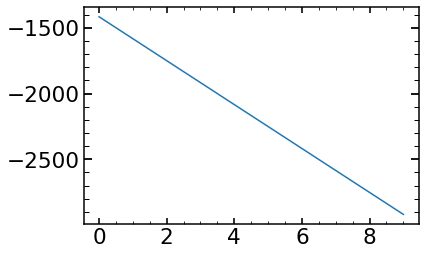

In [607]:
mean_res_as_chi=[]
for i in range(10):
    list_of_var_sums_i=create_list_of_var_or_ln_sums(list_of_var_images,i)
    mean_res_of_multi_same_spot=np.mean(list_of_var_sums_i/renormalization_of_var_sum)
    mean_res_as_chi.append([i,mean_res_of_multi_same_spot])
    
mean_res_as_chi=np.array(mean_res_as_chi)

plt.plot(mean_res_as_chi[:,0],mean_res_as_chi[:,1])

In [576]:



list_of_var_sums=[]
for i in range(len(list_of_var_images)):
    # taking from create_chi_2_almost function in LN_PFS_single


    mask_image=list_of_mask_images[i]
    var_image=list_of_var_images[i]
    # array that has True for values which are good and False for bad values
    inverted_mask=~mask_image.astype(bool)

    #         
    var_image_masked=var_image*inverted_mask
    var_image_masked_without_nan = var_image_masked.ravel()[var_image_masked.ravel()>0]

    var_sum=-(1/2)*(np.sum(np.log(2*np.pi*var_image_masked_without_nan)))

    list_of_var_sums.append(var_sum)

# renormalization needs to be reconsidered?
array_of_var_sum=np.array(list_of_var_sums)
max_of_array_of_var_sum=np.max(array_of_var_sum)
renormalization_of_var_sum=array_of_var_sum/max_of_array_of_var_sum

In [578]:
# what is array of single res if perfect, if off by 1 sigma, 2 sigma etc...

array_of_single_res=[]


# array_of_single_res=np.array(list_of_single_res)
# res_single_with_an_image=model_single(list_of_allparameters[i],return_Image=return_Images)
# res=-(1/2)*(chi_2_almost+np.sum(np.log(2*np.pi*self.var_image)))

# if perfection chi_2_almost=0
# if one sigma, then chi_2_almost=number of pixels
# if two sigma, then chi_2_almost=2 * number of pixels

array([11.80486989,  8.30545349,  5.44941739,  1.08005229,  1.        ,
        1.04124848,  7.78395515, 11.18860963, 11.71800968])

In [590]:
len(var_image_masked_without_nan)

3600

In [589]:
var_image_unit.shape[0]*[var_image_unit]

(60, 60)

In [586]:
sci_image_unit=list_of_sci_images[0]
var_image_unit=list_of_var_images[0]

In [581]:
mean_res_of_multi_same_spot=np.mean((renormalization_of_var_sum*3000)/renormalization_of_var_sum)

In [582]:
mean_res_of_multi_same_spot

3000.0

In [ ]:
array_of_single_res

In [584]:
for i in range(9):
    var_image=list_of_var_images[i]

    print(-(1/2)*(0+np.sum(np.log(2*np.pi*var_image))))

-16723.935546875
-11766.3193359375
-7720.1787109375
-1530.10791015625
-1416.697998046875
-1475.1346435546875
-11027.513671875
-15850.880859375
-16600.880859375


In [ ]:
max_of_array_of_var_sum

In [611]:
min_like_min=-3020

In [613]:
(min_like_min+zero_sigma_ln)/(one_sigma_ln-zero_sigma_ln)

NameError: name 'zero_sigma_ln' is not defined

## images 

In [99]:
custom_model_image=list_of_single_model_image[index_of_single_image]
custom_sci_image=list_of_sci_images[index_of_single_image]
custom_var_image=list_of_var_images[index_of_single_image]

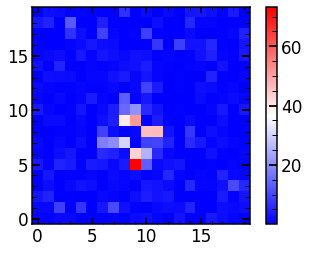

In [100]:
plt.imshow((custom_sci_image-custom_model_image)**2/custom_var_image,cmap='bwr')
plt.colorbar()

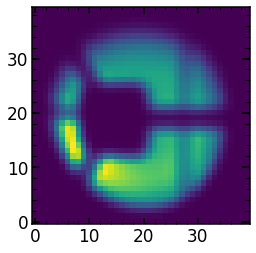

In [57]:
plt.imshow((custom_model_image)**2)

(array([19., 16., 30., 26., 32., 24., 35., 19., 19., 20.]),
 array([0.60166062, 0.62139659, 0.64113256, 0.66086853, 0.68060451,
        0.70034048, 0.72007645, 0.73981242, 0.75954839, 0.77928437,
        0.79902034]),
 <a list of 10 Patch objects>)

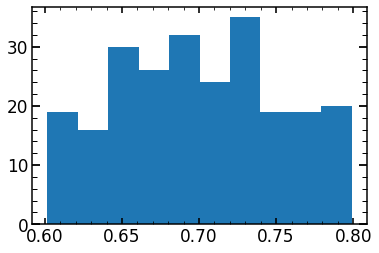

In [147]:
plt.hist(chain0_swarm_1[0][:,38])

(array([24., 16., 20., 26., 26., 28., 25., 27., 26., 22.]),
 array([0.07119043, 0.07701848, 0.08284653, 0.08867458, 0.09450262,
        0.10033067, 0.10615872, 0.11198677, 0.11781482, 0.12364287,
        0.12947091]),
 <a list of 10 Patch objects>)

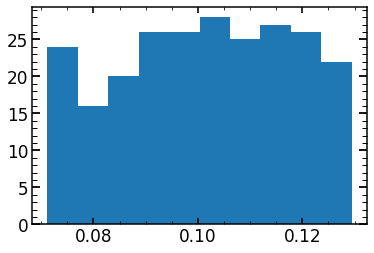

In [148]:
plt.hist(chain0_swarm_1[0][:,39])

In [149]:
array_of_polyfit_1_parameterizations_proposal_shape_2d=np.array([[   -7.48584024,     0.73497698],
       [    0.19568978,     0.15682353],
       [    0.03769565,     0.02577918],
       [   -0.03734586,     0.39183789],
       [    0.02550665,     0.556507  ],
       [    0.0072312 ,     0.1261021 ],
       [    0.01097693,    -0.26493479],
       [   -0.01831573,    -0.05247759],
       [    0.01020252,    -0.15314955],
       [    0.00343817,    -0.10475206],
       [    0.02711867,    -0.0137685 ],
       [    0.00445374,     0.0372618 ],
       [    0.01458828,    -0.02237409],
       [   -0.01880653,     0.03841714],
       [   -0.00188257,     0.02112357],
       [   -0.00910924,     0.01975998],
       [   -0.00067647,    -0.02366152],
       [    0.00463751,     0.012873  ],
       [   -0.00621102,     0.02695559],
       [    0.        ,     0.68904049],
       [    0.        ,     0.10290975],
       [    0.        ,    -0.20154677],
       [    0.        ,    -0.01441376],
       [    0.        ,     0.05355728],
       [    0.        ,     0.05813265],
       [    0.        ,     0.0000314 ],
       [    0.        ,     0.0000314 ],
       [    0.        ,     0.9767313 ],
       [    0.        ,     0.94836248],
       [    0.        ,     0.02461952],
       [    0.        ,    -0.05835101],
       [    0.        ,     0.93393462],
       [    0.        ,     0.04867201],
       [    0.        ,     0.49904901],
       [    0.        ,     1.01173008],
       [    0.        ,     0.63182418],
       [    0.        , 51347.90306188],
       [    0.        ,     2.32213302],
       [    0.        ,     0.00238991],
       [    0.        ,     0.37175131],
       [    0.        ,     1.79411345],
       [    0.        ,     0.99627532],
       [    0.00003301,    -0.00155895],
       [   -0.0007012 ,     0.00400087],
       [    0.00093449,     0.00437024],
       [    0.00096567,     0.00066246],
       [    0.00095771,     0.00368164],
       [    0.00029302,    -0.00083184],
       [    0.00196281,    -0.00503305],
       [    0.00055673,     0.00092236],
       [   -0.00170941,    -0.00397606],
       [    0.00222377,     0.01257303],
       [    0.00219571,     0.00159809],
       [   -0.00109161,     0.00276234],
       [   -0.00071055,    -0.00917837],
       [    0.00070316,    -0.00561311],
       [   -0.00074906,     0.00218633],
       [    0.00052506,     0.00031175],
       [   -0.00027124,     0.00124874],
       [    0.00056686,    -0.0004586 ],
       [   -0.00085383,     0.00176925],
       [   -0.00200233,    -0.00099071],
       [   -0.00017492,     0.00005366],
       [    0.00075724,    -0.00381397],
       [    0.0016349 ,    -0.00899893],
       [    0.00057199,    -0.01150359],
       [   -0.00085055,     0.00203238],
       [   -0.00052982,     0.0053546 ],
       [    0.00095456,    -0.00181697],
       [   -0.00055045,    -0.00379142],
       [   -0.00048768,     0.00804741],
       [   -0.00145526,     0.00574891],
       [   -0.0001161 ,    -0.00048279],
       [   -0.00099326,     0.00201623],
       [    0.00012449,     0.0103669 ],
       [    0.00272563,    -0.00187062]])

In [158]:
multi_var=True

stronger_array_01=np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            1,1,1,1,1,1,
            0.0,0.0,0.0,0.0,
            1,1,1,
            1,1,1,1,
            1,1,1,
            1,1,1]) 
zmax_input=56

parInit1=create_parInit(allparameters_proposal=array_of_polyfit_1_parameterizations_proposal_shape_2d,multi=multi_var,pupil_parameters=None,\
                        allparameters_proposal_err=None,\
                        stronger=stronger_array_01,use_optPSF=None,deduced_scattering_slope=None,zmax=zmax_input)
# the number of walkers is given by options array


globalparameters_flat.shape(774, 68)


(array([169., 156., 130., 118.,  89.,  55.,  24.,  17.,   9.,   7.]),
 array([0.00000636, 0.00426216, 0.00851795, 0.01277375, 0.01702955,
        0.02128535, 0.02554115, 0.02979694, 0.03405274, 0.03830854,
        0.04256434]),
 <a list of 10 Patch objects>)

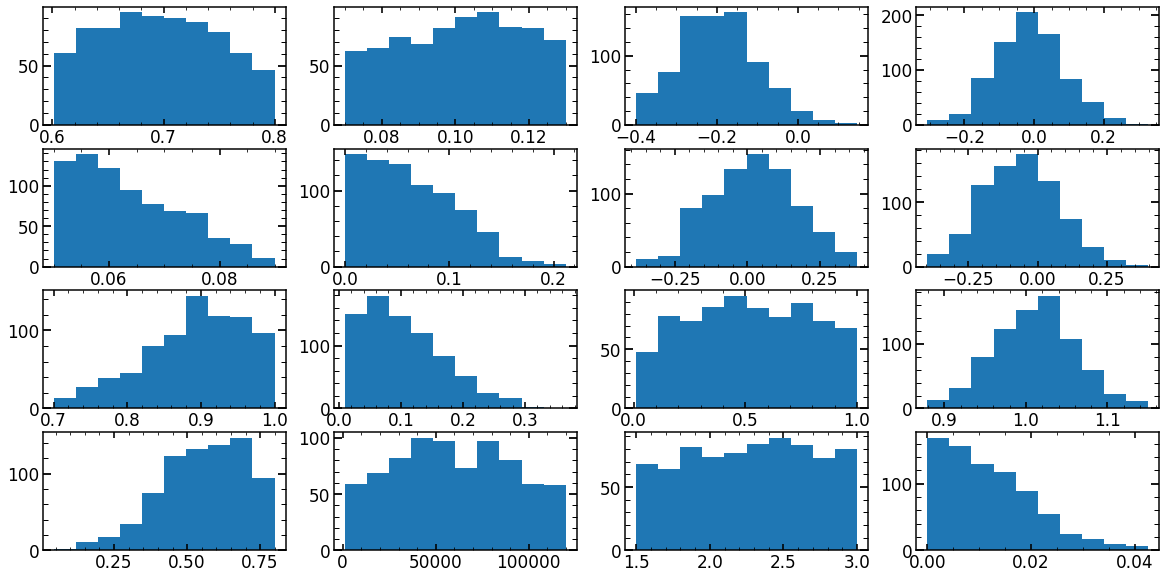

In [164]:
plt.figure(figsize=(20,10))

plt.subplot(4,4,1)
plt.hist(parInit1[:,38+0])

plt.subplot(4,4,2)
plt.hist(parInit1[:,38+1])

plt.subplot(4,4,3)
plt.hist(parInit1[:,38+2])

plt.subplot(4,4,4)
plt.hist(parInit1[:,38+3])

plt.subplot(4,4,5)
plt.hist(parInit1[:,38+4])

plt.subplot(4,4,6)
plt.hist(parInit1[:,38+5])

plt.subplot(4,4,7)
plt.hist(parInit1[:,38+10])

plt.subplot(4,4,8)
plt.hist(parInit1[:,38+11])

plt.subplot(4,4,9)
plt.hist(parInit1[:,38+12])

plt.subplot(4,4,10)
plt.hist(parInit1[:,38+13])

plt.subplot(4,4,11)
plt.hist(parInit1[:,38+14])

plt.subplot(4,4,12)
plt.hist(parInit1[:,38+15])

plt.subplot(4,4,13)
plt.hist(parInit1[:,38+16])

plt.subplot(4,4,14)
plt.hist(parInit1[:,38+17])

plt.subplot(4,4,15)
plt.hist(parInit1[:,38+18])

plt.subplot(4,4,16)
plt.hist(parInit1[:,38+19])

In [162]:
parInit1[:,38+6]

array([0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314,
       0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314,
       0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314,
       0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314,
       0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314,
       0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314,
       0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314,
       0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314,
       0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314,
       0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314,
       0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314,
       0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314,
       0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314, 0.0000314,
       0.0000314, 0.0000314, 0.0000314, 0.0000314, 

In [165]:
results_of_fit_input_HgAr

NameError: name 'results_of_fit_input_HgAr' is not defined

In [184]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes/results_of_fit_many_direct_HgAr_from_Dec04.pkl', 'rb') as f:
    results_of_fit_input_HgAr=pickle.load(f)
    
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes/results_of_fit_many_direct_Ne_from_Dec04.pkl', 'rb') as f:
    results_of_fit_input_Ne=pickle.load(f)

In [201]:
list_of_std_HgAr=[]
for i in range(19,19+23):
    list_of_std_HgAr.append(np.std(results_of_fit_input_HgAr['p4'][columns22[i]].values))
    
array_of_std_HgAr=np.array(list_of_std_HgAr)

In [198]:
list_of_std_Ne=[]
for i in range(19,19+23):
    list_of_std_Ne.append(np.std(results_of_fit_input_Ne['m4'][columns22[i]].values))
    
array_of_std_Ne=np.array(list_of_std_Ne)

In [199]:
columns22[19]

'hscFrac'

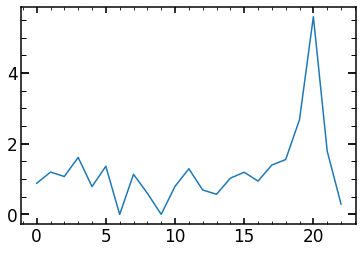

In [194]:
plt.plot(array_of_std_HgAr/array_of_std_Ne)

In [208]:
np.transpose(np.vstack((np.array(columns22[19:19+23]),array_of_std_HgAr*2)))

array([['hscFrac', '0.034257288110324496'],
       ['strutFrac', '0.01961366877017905'],
       ['dxFocal', '0.24664851902883506'],
       ['dyFocal', '0.23111596606047935'],
       ['slitFrac', '0.007495411339890314'],
       ['slitFrac_dy', '0.04784587793259848'],
       ['radiometricEffect', '2.545682038530713e-05'],
       ['radiometricExponent', '2.544672963628457e-05'],
       ['x_ilum', '0.007961263814773942'],
       ['y_ilum', '3.454405983972901e-05'],
       ['x_fiber', '0.04656530185120861'],
       ['y_fiber', '0.0578849665753993'],
       ['effective_radius_illumination', '0.04129472910085966'],
       ['frd_sigma', '0.040741208881210966'],
       ['frd_lorentz_factor', '0.3650322304347187'],
       ['det_vert', '0.0534581886500768'],
       ['slitHolder_frac_dx', '0.5836662210513971'],
       ['grating_lines', '39709.354637326716'],
       ['scattering_slope', '0.4052480417423568'],
       ['scattering_amplitude', '0.003048006202262793'],
       ['pixel_effect', '0.088185

In [205]:
np.array(columns22[19:19+23])

array(['hscFrac', 'strutFrac', 'dxFocal', 'dyFocal', 'slitFrac',
       'slitFrac_dy', 'radiometricEffect', 'radiometricExponent',
       'x_ilum', 'y_ilum', 'x_fiber', 'y_fiber',
       'effective_radius_illumination', 'frd_sigma', 'frd_lorentz_factor',
       'det_vert', 'slitHolder_frac_dx', 'grating_lines',
       'scattering_slope', 'scattering_amplitude', 'pixel_effect',
       'fiber_r', 'flux'], dtype='<U29')